In [36]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import pickle

#### Loading data after preprocessing

In [37]:
data_train  = pd.read_csv("../data/alt_maccsfp_after_preprocessing_not_log.csv")

#### Splitting data into training and test sets

In [38]:
y = data_train['ALT']
del data_train['ALT']
X = data_train.values
y = y.values

#### Configure the cross-validation procedure

In [39]:
cv_outer = KFold(n_splits=5, shuffle=True, random_state=234)
cv_inner = KFold(n_splits=5, shuffle=True, random_state=75579)

#### Helper functions for finding the best hyperparameters - we use dual cross-validation

In [40]:
def get_dual_cv_results(hyperparams_grid, model, cv_outer, cv_inner, x, y):
    cv_results = pd.DataFrame()

    for train_index, test_index in cv_outer.split(X):
        # split data
        x_train, x_test = x[train_index], [test_index]
        y_train, y_test = y[train_index], y[test_index]
        # define search
        search = GridSearchCV(model, hyperparams_grid, scoring='r2', cv=cv_inner,
                              return_train_score=True, verbose=1000)
        search_fit = search.fit(x_train, y_train)
        cv_result = pd.DataFrame(search_fit.cv_results_)
        cv_results = cv_results.append(cv_result, ignore_index=True)
    return cv_results


def group_dual_cv_results_data(cv_results):
    group_keys = [value for value in cv_results.columns.values if
                  value.startswith("param_") and 'random_state' not in value]
    groups = cv_results.groupby(by=group_keys)
    agg_arguments = {'mean_test_score': 'mean', 'std_test_score': 'mean',
                     'mean_train_score': 'mean', 'std_train_score': 'mean'}
    return groups.agg(agg_arguments)


def get_best_dual_cv_results(grouped_cv_results, key='mean_test_score'):
    return grouped_cv_results[key].max()


def get_best_hyperparameters(grouped_cv_results, key='mean_test_score'):
    return grouped_cv_results[key].idxmax()

#### In the following function the model is trained, saved and the results are stored

In [41]:
def calculate_model_results(model, cv_outer, x, y):
    results = pd.DataFrame(columns=['train_score', 'test_score', 'pred_train', 'pred_test'])

    for i, (train_index, test_index) in enumerate(cv_outer.split(x)):
        # split data
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(x_train, y_train)
        # save the model to disk
        model_name = str(model).split("(", 1)[0]
        filename = f"../models/finalized_{model_name}_model_{i}_not_log.pickle"
        pickle.dump(model, open(filename, 'wb'))
        y_pred_train = model.predict(x_train)
        train_score = model.score(x_train, y_train)
        y_pred_test = model.predict(x_test)
        test_score = model.score(x_test, y_test)
        results.loc[i] = [train_score, test_score, list(y_pred_train), list(y_pred_test)]
    results.to_csv(f"../results/{model_name}_results_not_log.csv", index=False)
    return results

def get_final_model_result(results):
    return round(results['test_score'].mean(), 3)

### LASSO 

In [14]:
hyperparams_grid_lasso = {'alpha': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 20, 40, 50, 60], 'random_state': [321321, 321]}
model_lasso = Lasso()

In [15]:
cv_results_lasso = get_dual_cv_results(hyperparams_grid_lasso, model_lasso, cv_outer, cv_inner, X, y)
cv_results_lasso

Fitting 5 folds for each of 26 candidates, totalling 130 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] alpha=0.0001, random_state=321321 ...............................
[CV]  alpha=0.0001, random_state=321321, score=(train=0.433, test=0.010), total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321321 ...............................
[CV]  alpha=0.0001, random_state=321321, score=(train=0.836, test=-2.770), total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321321 ...............................
[CV]  alpha=0.0001, random_state=321321, score=(train=0.968, test=-0.204), total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321321 ...............................
[CV]  alpha=0.0001, random_state=321321, score=(train=0.822, test=0

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6775.600037704794, tolerance: 4.616520688548387
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5968.887353757934, tolerance: 14.725472792419355
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 974.9360752224603, tolerance: 11.579225182096774
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

[CV]  alpha=0.001, random_state=321, score=(train=0.433, test=0.042), total=   0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321 ...................................
[CV]  alpha=0.001, random_state=321, score=(train=0.836, test=-2.762), total=   0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321 ...................................
[CV]  alpha=0.001, random_state=321, score=(train=0.968, test=0.046), total=   0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321 ...................................
[CV]  alpha=0.001, random_state=321, score=(train=0.822, test=0.462), total=   0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321 ...................................
[CV]  alpha=0.001, random_state=321, score=(train=0.820, te

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 925.4327862663467, tolerance: 11.579225182096774
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4825.025035006134, tolerance: 14.873399902222221
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3902.8863150453944, tolerance: 14.742577014285716
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

[CV]  alpha=0.01, random_state=321321, score=(train=0.820, test=-4.354), total=   0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.01, random_state=321 ....................................
[CV]  alpha=0.01, random_state=321, score=(train=0.433, test=-0.067), total=   0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.01, random_state=321 ....................................
[CV]  alpha=0.01, random_state=321, score=(train=0.836, test=-5.871), total=   0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.01, random_state=321 ....................................
[CV]  alpha=0.01, random_state=321, score=(train=0.968, test=-0.337), total=   0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.01, random_state=321 ....................................
[CV]  alpha=0.01, random_state=321, score=(train=0.822, t

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.86380558962446, tolerance: 11.579225182096774
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1981.913092546809, tolerance: 14.873399902222221
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2568.7721194079495, tolerance: 14.742577014285716
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

[CV]  alpha=0.1, random_state=321321, score=(train=0.818, test=0.354), total=   0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.5s remaining:    0.0s
[CV] alpha=0.1, random_state=321321 ..................................
[CV]  alpha=0.1, random_state=321321, score=(train=0.818, test=-5.390), total=   0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.5s remaining:    0.0s
[CV] alpha=0.1, random_state=321 .....................................
[CV]  alpha=0.1, random_state=321, score=(train=0.429, test=-0.098), total=   0.0s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    0.5s remaining:    0.0s
[CV] alpha=0.1, random_state=321 .....................................
[CV]  alpha=0.1, random_state=321, score=(train=0.834, test=-6.681), total=   0.0s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    0.5s remaining:    0.0s
[CV] alpha=0.1, random_state=321 .....................................
[CV]  alpha=0.1, random_state=321, score=(train=0.965, test

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.27382786541784, tolerance: 14.873399902222221
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1141.995179362166, tolerance: 11.662704474193548
  positive)



[Parallel(n_jobs=1)]: Done 112 out of 112 | elapsed:    0.6s remaining:    0.0s
[CV] alpha=50, random_state=321321 ...................................
[CV]  alpha=50, random_state=321321, score=(train=0.000, test=-0.000), total=   0.0s
[Parallel(n_jobs=1)]: Done 113 out of 113 | elapsed:    0.6s remaining:    0.0s
[CV] alpha=50, random_state=321321 ...................................
[CV]  alpha=50, random_state=321321, score=(train=0.000, test=-1.043), total=   0.0s
[Parallel(n_jobs=1)]: Done 114 out of 114 | elapsed:    0.7s remaining:    0.0s
[CV] alpha=50, random_state=321321 ...................................
[CV]  alpha=50, random_state=321321, score=(train=0.000, test=-0.579), total=   0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.7s remaining:    0.0s
[CV] alpha=50, random_state=321 ......................................
[CV]  alpha=50, random_state=321, score=(train=0.000, test=-0.134), total=   0.0s
[Parallel(n_jobs=1)]: Done 116 out of 116 | elapsed:    0.

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 864.1679068856259, tolerance: 5.867945177419355
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 694.2792677712039, tolerance: 15.67185706854839
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1206.501932319415, tolerance: 15.70280035269841
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

[CV]  alpha=0.0001, random_state=321, score=(train=0.969, test=0.686), total=   0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.962, test=0.907), total=   0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.950, test=0.498), total=   0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.979, test=-1.464), total=   0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(tr

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554.9991347885198, tolerance: 11.662704474193548
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321.8305967462072, tolerance: 5.867945177419355
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 406.3366979573748, tolerance: 15.67185706854839
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

[CV]  alpha=0.005, random_state=321, score=(train=0.962, test=0.950), total=   0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.2s remaining:    0.0s
[CV] alpha=0.005, random_state=321 ...................................
[CV]  alpha=0.005, random_state=321, score=(train=0.950, test=0.454), total=   0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.005, random_state=321 ...................................
[CV]  alpha=0.005, random_state=321, score=(train=0.979, test=-2.473), total=   0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.005, random_state=321 ...................................
[CV]  alpha=0.005, random_state=321, score=(train=0.971, test=-0.842), total=   0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.005, random_state=321 ...................................
[CV]  alpha=0.005, random_state=321, score=(train=0.969, t

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 490.83162109295563, tolerance: 15.70280035269841
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 579.7739249989654, tolerance: 15.621246657142859
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345.3166967129232, tolerance: 11.662704474193548
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

[CV]  alpha=0.05, random_state=321, score=(train=0.961, test=0.768), total=   0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    0.4s remaining:    0.0s
[CV] alpha=0.05, random_state=321 ....................................
[CV]  alpha=0.05, random_state=321, score=(train=0.948, test=0.434), total=   0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    0.4s remaining:    0.0s
[CV] alpha=0.05, random_state=321 ....................................
[CV]  alpha=0.05, random_state=321, score=(train=0.979, test=-3.485), total=   0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.4s remaining:    0.0s
[CV] alpha=0.05, random_state=321 ....................................
[CV]  alpha=0.05, random_state=321, score=(train=0.970, test=-0.161), total=   0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.5s remaining:    0.0s
[CV] alpha=0.05, random_state=321 ....................................
[CV]  alpha=0.05, random_state=321, score=(train=0.968, test=0

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.58551516433181, tolerance: 15.70280035269841
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229.68811091478437, tolerance: 15.621246657142859
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5545.563183649956, tolerance: 13.338936374193548
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

[CV]  alpha=20, random_state=321, score=(train=0.000, test=-0.893), total=   0.0s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:    0.6s remaining:    0.0s
[CV] alpha=20, random_state=321 ......................................
[CV]  alpha=20, random_state=321, score=(train=0.000, test=-0.273), total=   0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:    0.6s remaining:    0.0s
[CV] alpha=20, random_state=321 ......................................
[CV]  alpha=20, random_state=321, score=(train=0.000, test=-1.091), total=   0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s remaining:    0.0s
[CV] alpha=40, random_state=321321 ...................................
[CV]  alpha=40, random_state=321321, score=(train=0.000, test=-0.004), total=   0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:    0.6s remaining:    0.0s
[CV] alpha=40, random_state=321321 ...................................
[CV]  alpha=40, random_state=321321, score=(train=0.000, test=-0.

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5754.398639093211, tolerance: 13.767089617142856
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7159.326029419153, tolerance: 13.49254791936508
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5545.563183649956, tolerance: 13.338936374193548
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

[CV]  alpha=0.0001, random_state=321, score=(train=0.806, test=-1.258), total=   0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321 ..................................
[CV]  alpha=0.0001, random_state=321, score=(train=0.783, test=0.218), total=   0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.802, test=0.155), total=   0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.836, test=-0.330), total=   0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(tra

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3432.6324382664006, tolerance: 13.767089617142856
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2671.3720133636234, tolerance: 13.49254791936508
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1184.327568747376, tolerance: 13.338936374193548
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

[CV]  alpha=0.005, random_state=321, score=(train=0.836, test=-0.480), total=   0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.2s remaining:    0.0s
[CV] alpha=0.005, random_state=321 ...................................
[CV]  alpha=0.005, random_state=321, score=(train=0.805, test=-1.197), total=   0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.2s remaining:    0.0s
[CV] alpha=0.005, random_state=321 ...................................
[CV]  alpha=0.005, random_state=321, score=(train=0.806, test=-0.459), total=   0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.005, random_state=321 ...................................
[CV]  alpha=0.005, random_state=321, score=(train=0.783, test=-0.083), total=   0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.01, random_state=321321 .................................
[CV]  alpha=0.01, random_state=321321, score=(train=0.80

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 214.48980995189413, tolerance: 13.767089617142856
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252.70848679658593, tolerance: 13.49254791936508
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.59243870456703, tolerance: 13.338936374193548
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

[CV]  alpha=0.1, random_state=321321, score=(train=0.826, test=-0.336), total=   0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.4s remaining:    0.0s
[CV] alpha=0.1, random_state=321321 ..................................
[CV]  alpha=0.1, random_state=321321, score=(train=0.803, test=-1.037), total=   0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    0.4s remaining:    0.0s
[CV] alpha=0.1, random_state=321321 ..................................
[CV]  alpha=0.1, random_state=321321, score=(train=0.804, test=-0.250), total=   0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.4s remaining:    0.0s
[CV] alpha=0.1, random_state=321321 ..................................
[CV]  alpha=0.1, random_state=321321, score=(train=0.781, test=-0.679), total=   0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s remaining:    0.0s
[CV] alpha=0.1, random_state=321 .....................................
[CV]  alpha=0.1, random_state=321, score=(train=0.80

[CV]  alpha=60, random_state=321, score=(train=0.000, test=-0.213), total=   0.0s
[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:    0.6s remaining:    0.0s
[CV] alpha=60, random_state=321 ......................................
[CV]  alpha=60, random_state=321, score=(train=0.000, test=-0.405), total=   0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.6s remaining:    0.0s
[CV] alpha=60, random_state=321 ......................................
[CV]  alpha=60, random_state=321, score=(train=0.000, test=-0.012), total=   0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.6s remaining:    0.0s
[CV] alpha=60, random_state=321 ......................................
[CV]  alpha=60, random_state=321, score=(train=0.000, test=-0.638), total=   0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.6s finished
Fitting 5 folds for each of 26 candidates, totalling 130 fits
[Parall

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4239.566933539787, tolerance: 14.30624698857143
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1103.7432065879004, tolerance: 5.973257212698414
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5881.690759230116, tolerance: 14.041210628571429
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

[CV]  alpha=0.001, random_state=321321, score=(train=0.932, test=0.042), total=   0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.791, test=-1.353), total=   0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.751, test=-0.889), total=   0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.783, test=-0.761), total=   0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321 ...................................
[CV]  alpha=0.001, random_state=321, score=(t

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3805.7355084728188, tolerance: 10.333587564126983
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5762.935883170823, tolerance: 14.274537059375001
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3720.820164916533, tolerance: 14.30624698857143
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

[CV]  alpha=0.01, random_state=321321, score=(train=0.797, test=-6.782), total=   0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.01, random_state=321321 .................................
[CV]  alpha=0.01, random_state=321321, score=(train=0.932, test=-0.036), total=   0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.01, random_state=321321 .................................
[CV]  alpha=0.01, random_state=321321, score=(train=0.791, test=-1.540), total=   0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.01, random_state=321321 .................................
[CV]  alpha=0.01, random_state=321321, score=(train=0.751, test=-1.426), total=   0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.01, random_state=321321 .................................
[CV]  alpha=0.01, random_state=321321, score=(tr

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.84137778791819, tolerance: 5.973257212698414
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1303.045462408656, tolerance: 14.041210628571429
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 922.7045476498461, tolerance: 10.333587564126983
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

[CV]  alpha=0.1, random_state=321321, score=(train=0.788, test=-2.205), total=   0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    0.5s remaining:    0.0s
[CV] alpha=0.1, random_state=321321 ..................................
[CV]  alpha=0.1, random_state=321321, score=(train=0.746, test=-1.784), total=   0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.5s remaining:    0.0s
[CV] alpha=0.1, random_state=321321 ..................................
[CV]  alpha=0.1, random_state=321321, score=(train=0.780, test=-5.601), total=   0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.5s remaining:    0.0s
[CV] alpha=0.1, random_state=321 .....................................
[CV]  alpha=0.1, random_state=321, score=(train=0.794, test=-5.960), total=   0.0s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    0.5s remaining:    0.0s
[CV] alpha=0.1, random_state=321 .....................................
[CV]  alpha=0.1, random_state=321, score=(train=0.929, 

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.35949120635632, tolerance: 14.30624698857143
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.801839559811924, tolerance: 14.041210628571429
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6484.03652219875, tolerance: 14.533713443174603
  positive)


[CV]  alpha=60, random_state=321, score=(train=0.000, test=-0.744), total=   0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.7s remaining:    0.0s
[CV] alpha=60, random_state=321 ......................................
[CV]  alpha=60, random_state=321, score=(train=0.000, test=-0.061), total=   0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.7s remaining:    0.0s
[CV] alpha=60, random_state=321 ......................................
[CV]  alpha=60, random_state=321, score=(train=0.000, test=-0.244), total=   0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.7s finished
Fitting 5 folds for each of 26 candidates, totalling 130 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] alpha=0.0001, random_state=321321 ...............................
[CV]  alpha=0.0001, random_state=321321, score=(train=0.795, test=0.759), total=   0.0s


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4324.984803821826, tolerance: 8.830560906031746
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5247.4972894170805, tolerance: 18.70336539079365
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6454.5832149988855, tolerance: 18.81539980603175
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.655, test=0.510), total=   0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.844, test=-0.933), total=   0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.838, test=-17.674), total=   0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.975, test=-0.470), total=   0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 |

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 613.5924540100032, tolerance: 15.633449269375
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3697.4242075096117, tolerance: 14.533713443174603
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2955.8177303318334, tolerance: 8.830560906031746
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

[CV]  alpha=0.005, random_state=321, score=(train=0.975, test=-0.596), total=   0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.01, random_state=321321 .................................
[CV]  alpha=0.01, random_state=321321, score=(train=0.795, test=0.725), total=   0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.01, random_state=321321 .................................
[CV]  alpha=0.01, random_state=321321, score=(train=0.655, test=0.481), total=   0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.01, random_state=321321 .................................
[CV]  alpha=0.01, random_state=321321, score=(train=0.844, test=-1.098), total=   0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    0.3s remaining:    0.0s
[CV] alpha=0.01, random_state=321321 .................................
[CV]  alpha=0.01, random_state=321321, score=(train=

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 300.07576881607747, tolerance: 18.81539980603175
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315.0628944896898, tolerance: 15.633449269375
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1410.2339721066783, tolerance: 14.533713443174603
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

[CV]  alpha=0.05, random_state=321, score=(train=0.975, test=-0.817), total=   0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s remaining:    0.0s
[CV] alpha=0.1, random_state=321321 ..................................
[CV]  alpha=0.1, random_state=321321, score=(train=0.791, test=0.561), total=   0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    0.5s remaining:    0.0s
[CV] alpha=0.1, random_state=321321 ..................................
[CV]  alpha=0.1, random_state=321321, score=(train=0.652, test=0.470), total=   0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.5s remaining:    0.0s
[CV] alpha=0.1, random_state=321321 ..................................
[CV]  alpha=0.1, random_state=321321, score=(train=0.841, test=-1.044), total=   0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    0.5s remaining:    0.0s
[CV] alpha=0.1, random_state=321321 ..................................
[CV]  alpha=0.1, random_state=321321, score=(train=0.836

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 251.16348698361253, tolerance: 14.533713443174603
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.492855253331072, tolerance: 18.70336539079365
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.158119393192464, tolerance: 18.81539980603175
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

[CV]  alpha=40, random_state=321321, score=(train=0.000, test=-0.002), total=   0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:    0.6s remaining:    0.0s
[CV] alpha=40, random_state=321321 ...................................
[CV]  alpha=40, random_state=321321, score=(train=0.000, test=-0.127), total=   0.0s
[Parallel(n_jobs=1)]: Done 102 out of 102 | elapsed:    0.6s remaining:    0.0s
[CV] alpha=40, random_state=321321 ...................................
[CV]  alpha=40, random_state=321321, score=(train=0.000, test=-1.560), total=   0.0s
[Parallel(n_jobs=1)]: Done 103 out of 103 | elapsed:    0.6s remaining:    0.0s
[CV] alpha=40, random_state=321321 ...................................
[CV]  alpha=40, random_state=321321, score=(train=0.000, test=-1.086), total=   0.0s
[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:    0.6s remaining:    0.0s
[CV] alpha=40, random_state=321321 ...................................
[CV]  alpha=40, random_state=321321, score=(train=0.000,

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0         0.012978      0.001276         0.000592        0.000484      0.0001   
1         0.011369      0.000475         0.000000        0.000000      0.0001   
2         0.009574      0.000798         0.000599        0.000489       0.001   
3         0.010971      0.000893         0.000401        0.000491       0.001   
4         0.008776      0.000399         0.000000        0.000000       0.005   
..             ...           ...              ...             ...         ...   
125       0.001005      0.000028         0.000000        0.000000          40   
126       0.000799      0.000400         0.000399        0.000489          50   
127       0.001192      0.000384         0.000000        0.000000          50   
128       0.000804      0.000402         0.000199        0.000399          60   
129       0.000999      0.000023         0.000000        0.000000          60   

    param_random_state                                     params  \
0               321321  {'alpha': 0.0001, 'random_state': 321321}   
1                  321     {'alpha': 0.0001, 'random_state': 321}   
2               321321   {'alpha': 0.001, 'random_state': 321321}   
3                  321      {'alpha': 0.001, 'random_state': 321}   
4               321321   {'alpha': 0.005, 'random_state': 321321}   
..                 ...                                        ...   
125                321         {'alpha': 40, 'random_state': 321}   
126             321321      {'alpha': 50, 'random_state': 321321}   
127                321         {'alpha': 50, 'random_state': 321}   
128             321321      {'alpha': 60, 'random_state': 321321}   
129                321         {'alpha': 60, 'random_state': 321}   

     split0_test_score  split1_test_score  split2_test_score  ...  \
0             0.010099          -2.770123          -0.204394  ...   
1             0.010099          -2.770123          -0.204394  ...   
2             0.042338          -2.761608           0.045640  ...   
3             0.042338          -2.761608           0.045640  ...   
4            -0.066544          -4.503269          -0.231900  ...   
..                 ...                ...                ...  ...   
125          -0.001664          -0.127138          -1.559514  ...   
126          -0.001664          -0.127138          -1.559514  ...   
127          -0.001664          -0.127138          -1.559514  ...   
128          -0.001664          -0.127138          -1.559514  ...   
129          -0.001664          -0.127138          -1.559514  ...   

     mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0          -1.224079        1.582048               11            0.433288   
1          -1.224079        1.582048               11            0.433288   
2          -1.273747        1.844647               13            0.433287   
3          -1.273747        1.844647               13            0.433287   
4          -1.926907        2.425612               17            0.433270   
..               ...             ...              ...                 ...   
125        -0.555123        0.646174                3            0.000000   
126        -0.555123        0.646174                3            0.000000   
127        -0.555123        0.646174                3            0.000000   
128        -0.555123        0.646174                3            0.000000   
129        -0.555123        0.646174                3            0.000000   

     split1_train_score  split2_train_score  split3_train_score  \
0              0.836383            0.968105            0.821820   
1              0.836383            0.968105            0.821820   
2              0.836383            0.968105            0.821819   
3              0.836383            0.968105            0.821819   
4              0.836376            0.968099            0.821804   
..                  ...                 ...    

In [16]:
grouped_cv_results_data_lasso = group_dual_cv_results_data(cv_results_lasso)
grouped_cv_results_data_lasso.sort_values('mean_test_score', ascending=False).iloc[:9]

mean_test_score  std_test_score  mean_train_score  \
param_alpha                                                      
10.000             -0.424466        0.383493          0.003031   
20.000             -0.430876        0.388839          0.000000   
40.000             -0.430876        0.388839          0.000000   
50.000             -0.430876        0.388839          0.000000   
60.000             -0.430876        0.388839          0.000000   
1.000              -0.646717        0.865119          0.683393   
0.500              -1.096016        1.245446          0.782213   
0.001              -1.432098        2.503136          0.836181   
0.005              -1.466235        2.319643          0.836169   

             std_train_score  
param_alpha                   
10.000              0.003033  
20.000              0.000000  
40.000              0.000000  
50.000              0.000000  
60.000              0.000000  
1.000               0.099750  
0.500               0.078527  
0.001               0.074391  
0.005               0.074392

In [17]:
best_dual_cv_results_lasso = get_best_dual_cv_results(grouped_cv_results_data_lasso)
best_hyperparameter_lasso = get_best_hyperparameters(grouped_cv_results_data_lasso)
print("MEAN_TEST_SCORE: ",best_dual_cv_results_lasso)
print("BEST HYPERPARAMETERS: ", best_hyperparameter_lasso)

MEAN_TEST_SCORE:  -0.42446618661142077
BEST HYPERPARAMETERS:  10.0


In [42]:
lasso_model = Lasso(alpha=best_hyperparameter_lasso, random_state=6346)

In [43]:
lasso_results = calculate_model_results(lasso_model, cv_outer, X, y)
lasso_results

train_score  test_score                                         pred_train  \
0          0.0   -0.016807  [45.846538461538465, 45.846538461538465, 45.84...   
1          0.0   -0.001184  [47.42038461538462, 47.42038461538462, 47.4203...   
2          0.0   -0.001180  [47.49589743589744, 47.49589743589744, 47.4958...   
3          0.0   -0.000083  [47.028481012658226, 47.028481012658226, 47.02...   
4          0.0   -0.034435  [47.800632911392405, 47.800632911392405, 47.80...   

                                           pred_test  
0  [45.846538461538465, 45.846538461538465, 45.84...  
1  [47.42038461538462, 47.42038461538462, 47.4203...  
2  [47.49589743589744, 47.49589743589744, 47.4958...  
3  [47.028481012658226, 47.028481012658226, 47.02...  
4  [47.800632911392405, 47.800632911392405, 47.80...

In [44]:
lasso_result = get_final_model_result(lasso_results)
lasso_result

-0.011

### Decision Tree Regressor

In [20]:
param_grid_dtr = {'max_depth': range(1, 11), 'min_samples_split': range(1, 30), 'random_state': [321321, 321]}

model_dtr = DecisionTreeRegressor()

In [21]:
cv_results_dtr = get_dual_cv_results(param_grid_dtr, model_dtr, cv_outer, cv_inner, X, y)
cv_results_dtr

Fitting 5 folds for each of 580 candidates, totalling 2900 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, 

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=1, min_samples_split=11, random_state=321321, score=(train=0.313, test=-0.274), total=   0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=11, random_state=321 .............
[CV]  max_depth=1, min_samples_split=11, random_state=321, score=(train=0.110, test=-0.180), total=   0.0s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=11, random_state=321 .............
[CV]  max_depth=1, min_samples_split=11, random_state=321, score=(train=0.315, test=-0.083), total=   0.0s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=11, random_state=321 .............
[CV]  max_depth=1, min_samples_split=11, random_state=321, score=(train=0.407, test=-0.008), total=   0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=

[CV] max_depth=1, min_samples_split=21, random_state=321 .............
[CV]  max_depth=1, min_samples_split=21, random_state=321, score=(train=0.407, test=-0.008), total=   0.0s
[Parallel(n_jobs=1)]: Done 208 out of 208 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=21, random_state=321 .............
[CV]  max_depth=1, min_samples_split=21, random_state=321, score=(train=0.310, test=-0.501), total=   0.0s
[Parallel(n_jobs=1)]: Done 209 out of 209 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=21, random_state=321 .............
[CV]  max_depth=1, min_samples_split=21, random_state=321, score=(train=0.313, test=-0.274), total=   0.0s
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=22, random_state=321321, score=(train=0.110, test=-0.180), total=   0.0s
[Parallel(n_jobs=1)]: Done 211 out of 211 | e

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done 322 out of 322 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=2, min_samples_split=4, random_state=321321, score=(train=0.643, test=-0.044), total=   0.0s
[Parallel(n_jobs=1)]: Done 323 out of 323 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=2, min_samples_split=4, random_state=321321, score=(train=0.483, test=-0.048), total=   0.0s
[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=2, min_samples_split=4, random_state=321321, score=(train=0.518, test=-1.989), total=   0.0s
[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=4, random_state=321, score=(tra

[CV]  max_depth=2, min_samples_split=15, random_state=321321, score=(train=0.503, test=-0.674), total=   0.0s
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=15, random_state=321321, score=(train=0.643, test=-0.044), total=   0.0s
[Parallel(n_jobs=1)]: Done 433 out of 433 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=15, random_state=321321, score=(train=0.483, test=-0.048), total=   0.0s
[Parallel(n_jobs=1)]: Done 434 out of 434 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=15, random_state=321321, score=(train=0.518, test=-1.989), total=   0.0s
[Parallel(n_jobs=1)]: Done 435 out of 435 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_sampl

[CV]  max_depth=2, min_samples_split=25, random_state=321, score=(train=0.518, test=-1.989), total=   0.0s
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=26, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=26, random_state=321321, score=(train=0.156, test=-0.019), total=   0.0s
[Parallel(n_jobs=1)]: Done 541 out of 541 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=26, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=26, random_state=321321, score=(train=0.503, test=-0.674), total=   0.0s
[Parallel(n_jobs=1)]: Done 542 out of 542 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=26, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=26, random_state=321321, score=(train=0.643, test=-0.044), total=   0.0s
[Parallel(n_jobs=1)]: Done 543 out of 543 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done 625 out of 625 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=3, min_samples_split=5, random_state=321, score=(train=0.333, test=-0.020), total=   0.0s
[Parallel(n_jobs=1)]: Done 626 out of 626 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=3, min_samples_split=5, random_state=321, score=(train=0.554, test=-1.532), total=   0.0s
[Parallel(n_jobs=1)]: Done 627 out of 627 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=3, min_samples_split=5, random_state=321, score=(train=0.659, test=0.009), total=   0.0s
[Parallel(n_jobs=1)]: Done 628 out of 628 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=3, min_samples_split=5, random_state=321, score=(train=0.535, 

[CV]  max_depth=3, min_samples_split=12, random_state=321321, score=(train=0.659, test=0.009), total=   0.0s
[Parallel(n_jobs=1)]: Done 693 out of 693 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=12, random_state=321321, score=(train=0.535, test=-3.180), total=   0.0s
[Parallel(n_jobs=1)]: Done 694 out of 694 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=12, random_state=321321, score=(train=0.556, test=-2.199), total=   0.0s
[Parallel(n_jobs=1)]: Done 695 out of 695 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=12, random_state=321 .............
[CV]  max_depth=3, min_samples_split=12, random_state=321, score=(train=0.201, test=-0.024), total=   0.0s
[Parallel(n_jobs=1)]: Done 696 out of 696 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_s

[CV]  max_depth=3, min_samples_split=22, random_state=321321, score=(train=0.659, test=0.009), total=   0.0s
[Parallel(n_jobs=1)]: Done 793 out of 793 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=3, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=22, random_state=321321, score=(train=0.535, test=-3.180), total=   0.0s
[Parallel(n_jobs=1)]: Done 794 out of 794 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=3, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=22, random_state=321321, score=(train=0.556, test=-2.199), total=   0.0s
[Parallel(n_jobs=1)]: Done 795 out of 795 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=3, min_samples_split=22, random_state=321 .............
[CV]  max_depth=3, min_samples_split=22, random_state=321, score=(train=0.201, test=-0.024), total=   0.0s
[Parallel(n_jobs=1)]: Done 796 out of 796 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=3, min_samples_s

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=4, min_samples_split=4, random_state=321321, score=(train=0.364, test=-0.014), total=   0.0s
[Parallel(n_jobs=1)]: Done 901 out of 901 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=4, random_state=321321, score=(train=0.593, test=-0.738), total=   0.0s
[Parallel(n_jobs=1)]: Done 902 out of 902 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=4, random_state=321321, score=(train=0.949, test=-0.001), total=   0.0s
[Parallel(n_jobs=1)]: Done 903 out of 903 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=4, random_state=321321, score=(train=0.774, test=0.138), total=   0.0s
[Parallel(n_jobs=1)]: Done 904 out of 904 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_sp

[CV]  max_depth=4, min_samples_split=14, random_state=321321, score=(train=0.232, test=-0.018), total=   0.0s
[CV] max_depth=4, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=14, random_state=321321, score=(train=0.565, test=-1.534), total=   0.0s
[CV] max_depth=4, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=14, random_state=321321, score=(train=0.687, test=-0.001), total=   0.0s
[CV] max_depth=4, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=14, random_state=321321, score=(train=0.551, test=-3.036), total=   0.0s
[CV] max_depth=4, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=14, random_state=321321, score=(train=0.572, test=-2.408), total=   0.0s
[CV] max_depth=4, min_samples_split=14, random_state=321 .............
[CV]  max_depth=4, min_samples_split=14, random_state=321, score=(train=0.232, test=-0.018), to

[CV]  max_depth=4, min_samples_split=23, random_state=321321, score=(train=0.551, test=-3.036), total=   0.0s
[CV] max_depth=4, min_samples_split=23, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=23, random_state=321321, score=(train=0.572, test=-2.408), total=   0.0s
[CV] max_depth=4, min_samples_split=23, random_state=321 .............
[CV]  max_depth=4, min_samples_split=23, random_state=321, score=(train=0.232, test=-0.018), total=   0.0s
[CV] max_depth=4, min_samples_split=23, random_state=321 .............
[CV]  max_depth=4, min_samples_split=23, random_state=321, score=(train=0.565, test=-1.534), total=   0.0s
[CV] max_depth=4, min_samples_split=23, random_state=321 .............
[CV]  max_depth=4, min_samples_split=23, random_state=321, score=(train=0.673, test=-0.025), total=   0.0s
[CV] max_depth=4, min_samples_split=23, random_state=321 .............
[CV]  max_depth=4, min_samples_split=23, random_state=321, score=(train=0.551, test=-3.036), total=   0.

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=5, min_samples_split=3, random_state=321, score=(train=0.386, test=-0.018), total=   0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=3, random_state=321, score=(train=0.808, test=-0.057), total=   0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=3, random_state=321, score=(train=0.961, test=0.058), total=   0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=3, random_state=321, score=(train=0.797, test=0.171), total=   0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=3, random_state=321, score=(train=0.805, test=-0.376), total=   0.0s
[CV] max_depth=5, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=4, random_state=321321, score=(train=0.386, test=-0.018), total=   0.0s
[CV] max

[CV]  max_depth=5, min_samples_split=13, random_state=321, score=(train=0.694, test=0.088), total=   0.0s
[CV] max_depth=5, min_samples_split=13, random_state=321 .............
[CV]  max_depth=5, min_samples_split=13, random_state=321, score=(train=0.570, test=-2.992), total=   0.0s
[CV] max_depth=5, min_samples_split=13, random_state=321 .............
[CV]  max_depth=5, min_samples_split=13, random_state=321, score=(train=0.586, test=-2.500), total=   0.0s
[CV] max_depth=5, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=14, random_state=321321, score=(train=0.254, test=-0.022), total=   0.0s
[CV] max_depth=5, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=14, random_state=321321, score=(train=0.576, test=-1.620), total=   0.0s
[CV] max_depth=5, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=14, random_state=321321, score=(train=0.694, test=0.088), total=   0

[CV] max_depth=5, min_samples_split=23, random_state=321 .............
[CV]  max_depth=5, min_samples_split=23, random_state=321, score=(train=0.570, test=-2.992), total=   0.0s
[CV] max_depth=5, min_samples_split=23, random_state=321 .............
[CV]  max_depth=5, min_samples_split=23, random_state=321, score=(train=0.586, test=-2.500), total=   0.0s
[CV] max_depth=5, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=24, random_state=321321, score=(train=0.254, test=-0.022), total=   0.0s
[CV] max_depth=5, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=24, random_state=321321, score=(train=0.576, test=-1.620), total=   0.0s
[CV] max_depth=5, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=24, random_state=321321, score=(train=0.677, test=0.038), total=   0.0s
[CV] max_depth=5, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=5, min_samples_

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=6, min_samples_split=5, random_state=321321, score=(train=0.422, test=-0.025), total=   0.0s
[CV] max_depth=6, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=5, random_state=321321, score=(train=0.620, test=-0.949), total=   0.0s
[CV] max_depth=6, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=5, random_state=321321, score=(train=0.703, test=0.047), total=   0.0s
[CV] max_depth=6, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=5, random_state=321321, score=(train=0.581, test=-3.003), total=   0.0s
[CV] max_depth=6, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=5, random_state=321321, score=(train=0.641, test=-1.942), total=   0.0s
[CV] max_depth=6, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=5, random_state=321, score=(train=0.422, test=-0.025), total=   

[CV]  max_depth=6, min_samples_split=11, random_state=321, score=(train=0.591, test=-2.419), total=   0.0s
[CV] max_depth=6, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=12, random_state=321321, score=(train=0.281, test=-0.032), total=   0.0s
[CV] max_depth=6, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=12, random_state=321321, score=(train=0.585, test=-1.553), total=   0.0s
[CV] max_depth=6, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=12, random_state=321321, score=(train=0.697, test=0.060), total=   0.0s
[CV] max_depth=6, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=12, random_state=321321, score=(train=0.578, test=-2.996), total=   0.0s
[CV] max_depth=6, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=12, random_state=321321, score=(train=0.591, test=-2.419), tot

[CV]  max_depth=6, min_samples_split=20, random_state=321, score=(train=0.591, test=-2.419), total=   0.0s
[CV] max_depth=6, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=21, random_state=321321, score=(train=0.281, test=-0.032), total=   0.0s
[CV] max_depth=6, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=21, random_state=321321, score=(train=0.585, test=-1.553), total=   0.0s
[CV] max_depth=6, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=21, random_state=321321, score=(train=0.690, test=0.061), total=   0.0s
[CV] max_depth=6, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=21, random_state=321321, score=(train=0.578, test=-2.996), total=   0.0s
[CV] max_depth=6, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=21, random_state=321321, score=(train=0.591, test=-2.419), tot

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=7, min_samples_split=2, random_state=321, score=(train=0.834, test=-9.797), total=   0.0s
[CV] max_depth=7, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=2, random_state=321, score=(train=0.968, test=0.043), total=   0.0s
[CV] max_depth=7, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=2, random_state=321, score=(train=0.818, test=0.431), total=   0.0s
[CV] max_depth=7, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=2, random_state=321, score=(train=0.818, test=-0.279), total=   0.0s
[CV] max_depth=7, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=3, random_state=321321, score=(train=0.425, test=-0.014), total=   0.0s
[CV] max_depth=7, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=3, random_state=321321, score=(train=0.833, test=-9.797), total=   0.0s
[CV] 

[CV]  max_depth=7, min_samples_split=12, random_state=321, score=(train=0.592, test=-1.544), total=   0.0s
[CV] max_depth=7, min_samples_split=12, random_state=321 .............
[CV]  max_depth=7, min_samples_split=12, random_state=321, score=(train=0.698, test=0.060), total=   0.0s
[CV] max_depth=7, min_samples_split=12, random_state=321 .............
[CV]  max_depth=7, min_samples_split=12, random_state=321, score=(train=0.591, test=-2.723), total=   0.0s
[CV] max_depth=7, min_samples_split=12, random_state=321 .............
[CV]  max_depth=7, min_samples_split=12, random_state=321, score=(train=0.594, test=-2.444), total=   0.0s
[CV] max_depth=7, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=13, random_state=321321, score=(train=0.284, test=-0.021), total=   0.0s
[CV] max_depth=7, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=13, random_state=321321, score=(train=0.592, test=-1.544), total=   0.0

[CV]  max_depth=7, min_samples_split=23, random_state=321321, score=(train=0.284, test=-0.021), total=   0.0s
[CV] max_depth=7, min_samples_split=23, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=23, random_state=321321, score=(train=0.592, test=-1.544), total=   0.0s
[CV] max_depth=7, min_samples_split=23, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=23, random_state=321321, score=(train=0.677, test=0.038), total=   0.0s
[CV] max_depth=7, min_samples_split=23, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=23, random_state=321321, score=(train=0.584, test=-2.988), total=   0.0s
[CV] max_depth=7, min_samples_split=23, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=23, random_state=321321, score=(train=0.594, test=-2.444), total=   0.0s
[CV] max_depth=7, min_samples_split=23, random_state=321 .............
[CV]  max_depth=7, min_samples_split=23, random_state=321, score=(train=0.284, test=-0.021), tot

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=8, min_samples_split=4, random_state=321, score=(train=0.966, test=0.076), total=   0.0s
[CV] max_depth=8, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=4, random_state=321, score=(train=0.820, test=0.379), total=   0.0s
[CV] max_depth=8, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=4, random_state=321, score=(train=0.646, test=-2.898), total=   0.0s
[CV] max_depth=8, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=5, random_state=321321, score=(train=0.427, test=-0.015), total=   0.0s
[CV] max_depth=8, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=5, random_state=321321, score=(train=0.633, test=-0.970), total=   0.0s
[CV] max_depth=8, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=5, random_state=321321, score=(train=0.704, test=0.038), total=   0.0s
[CV

[CV]  max_depth=8, min_samples_split=14, random_state=321321, score=(train=0.592, test=-2.731), total=   0.0s
[CV] max_depth=8, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=14, random_state=321321, score=(train=0.595, test=-2.503), total=   0.0s
[CV] max_depth=8, min_samples_split=14, random_state=321 .............
[CV]  max_depth=8, min_samples_split=14, random_state=321, score=(train=0.286, test=-0.001), total=   0.0s
[CV] max_depth=8, min_samples_split=14, random_state=321 .............
[CV]  max_depth=8, min_samples_split=14, random_state=321, score=(train=0.592, test=-1.524), total=   0.0s
[CV] max_depth=8, min_samples_split=14, random_state=321 .............
[CV]  max_depth=8, min_samples_split=14, random_state=321, score=(train=0.698, test=0.060), total=   0.0s
[CV] max_depth=8, min_samples_split=14, random_state=321 .............
[CV]  max_depth=8, min_samples_split=14, random_state=321, score=(train=0.592, test=-2.731), total=   0.0

[CV]  max_depth=8, min_samples_split=25, random_state=321321, score=(train=0.578, test=-2.996), total=   0.0s
[CV] max_depth=8, min_samples_split=25, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=25, random_state=321321, score=(train=0.594, test=-2.444), total=   0.0s
[CV] max_depth=8, min_samples_split=25, random_state=321 .............
[CV]  max_depth=8, min_samples_split=25, random_state=321, score=(train=0.284, test=-0.021), total=   0.0s
[CV] max_depth=8, min_samples_split=25, random_state=321 .............
[CV]  max_depth=8, min_samples_split=25, random_state=321, score=(train=0.592, test=-1.524), total=   0.0s
[CV] max_depth=8, min_samples_split=25, random_state=321 .............
[CV]  max_depth=8, min_samples_split=25, random_state=321, score=(train=0.677, test=0.038), total=   0.0s
[CV] max_depth=8, min_samples_split=25, random_state=321 .............
[CV]  max_depth=8, min_samples_split=25, random_state=321, score=(train=0.578, test=-2.996), total=   0.0

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=9, min_samples_split=7, random_state=321321, score=(train=0.595, test=-2.715), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=7, random_state=321321, score=(train=0.633, test=-2.663), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=7, random_state=321, score=(train=0.427, test=0.006), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=7, random_state=321, score=(train=0.627, test=-0.802), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=7, random_state=321, score=(train=0.704, test=0.035), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=7, random_state=321, score=(train=0.595, test=-2.715), total=   0.0s
[CV] 

[CV]  max_depth=9, min_samples_split=17, random_state=321321, score=(train=0.585, test=-2.996), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=17, random_state=321321, score=(train=0.595, test=-2.503), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321 .............
[CV]  max_depth=9, min_samples_split=17, random_state=321, score=(train=0.286, test=-0.001), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321 .............
[CV]  max_depth=9, min_samples_split=17, random_state=321, score=(train=0.592, test=-1.526), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321 .............
[CV]  max_depth=9, min_samples_split=17, random_state=321, score=(train=0.697, test=0.060), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321 .............
[CV]  max_depth=9, min_samples_split=17, random_state=321, score=(train=0.585, test=-2.996), total=   0.0

[CV]  max_depth=9, min_samples_split=27, random_state=321321, score=(train=0.594, test=-2.444), total=   0.0s
[CV] max_depth=9, min_samples_split=27, random_state=321 .............
[CV]  max_depth=9, min_samples_split=27, random_state=321, score=(train=0.284, test=-0.021), total=   0.0s
[CV] max_depth=9, min_samples_split=27, random_state=321 .............
[CV]  max_depth=9, min_samples_split=27, random_state=321, score=(train=0.592, test=-1.524), total=   0.0s
[CV] max_depth=9, min_samples_split=27, random_state=321 .............
[CV]  max_depth=9, min_samples_split=27, random_state=321, score=(train=0.673, test=-0.025), total=   0.0s
[CV] max_depth=9, min_samples_split=27, random_state=321 .............
[CV]  max_depth=9, min_samples_split=27, random_state=321, score=(train=0.578, test=-2.996), total=   0.0s
[CV] max_depth=9, min_samples_split=27, random_state=321 .............
[CV]  max_depth=9, min_samples_split=27, random_state=321, score=(train=0.594, test=-2.444), total=   0.0s


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=10, min_samples_split=9, random_state=321321, score=(train=0.703, test=0.057), total=   0.0s
[CV] max_depth=10, min_samples_split=9, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=9, random_state=321321, score=(train=0.595, test=-2.728), total=   0.0s
[CV] max_depth=10, min_samples_split=9, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=9, random_state=321321, score=(train=0.600, test=-2.958), total=   0.0s
[CV] max_depth=10, min_samples_split=9, random_state=321 .............
[CV]  max_depth=10, min_samples_split=9, random_state=321, score=(train=0.412, test=0.003), total=   0.0s
[CV] max_depth=10, min_samples_split=9, random_state=321 .............
[CV]  max_depth=10, min_samples_split=9, random_state=321, score=(train=0.593, test=-1.547), total=   0.0s
[CV] max_depth=10, min_samples_split=9, random_state=321 .............
[CV]  max_depth=10, min_samples_split=9, random_state=321, score=(train=0.703, test=0.050), total=   0.

[CV]  max_depth=10, min_samples_split=19, random_state=321, score=(train=0.284, test=-0.021), total=   0.0s
[CV] max_depth=10, min_samples_split=19, random_state=321 ............
[CV]  max_depth=10, min_samples_split=19, random_state=321, score=(train=0.592, test=-1.524), total=   0.0s
[CV] max_depth=10, min_samples_split=19, random_state=321 ............
[CV]  max_depth=10, min_samples_split=19, random_state=321, score=(train=0.694, test=0.088), total=   0.0s
[CV] max_depth=10, min_samples_split=19, random_state=321 ............
[CV]  max_depth=10, min_samples_split=19, random_state=321, score=(train=0.585, test=-2.996), total=   0.0s
[CV] max_depth=10, min_samples_split=19, random_state=321 ............
[CV]  max_depth=10, min_samples_split=19, random_state=321, score=(train=0.595, test=-2.503), total=   0.0s
[CV] max_depth=10, min_samples_split=20, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=20, random_state=321321, score=(train=0.284, test=-0.021), total=   

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_stat

[CV]  max_depth=1, min_samples_split=12, random_state=321, score=(train=0.549, test=-0.222), total=   0.0s
[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=12, random_state=321 .............
[CV]  max_depth=1, min_samples_split=12, random_state=321, score=(train=0.553, test=-0.016), total=   0.0s
[Parallel(n_jobs=1)]: Done 119 out of 119 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=12, random_state=321 .............
[CV]  max_depth=1, min_samples_split=12, random_state=321, score=(train=0.550, test=-0.349), total=   0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=13, random_state=321321, score=(train=0.400, test=0.895), total=   0.0s
[Parallel(n_jobs=1)]: Done 121 out of 121 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1

[CV]  max_depth=1, min_samples_split=23, random_state=321, score=(train=0.549, test=-0.222), total=   0.0s
[Parallel(n_jobs=1)]: Done 228 out of 228 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=23, random_state=321 .............
[CV]  max_depth=1, min_samples_split=23, random_state=321, score=(train=0.553, test=-0.016), total=   0.0s
[Parallel(n_jobs=1)]: Done 229 out of 229 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=23, random_state=321 .............
[CV]  max_depth=1, min_samples_split=23, random_state=321, score=(train=0.550, test=-0.349), total=   0.0s
[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=24, random_state=321321, score=(train=0.400, test=0.895), total=   0.0s
[Parallel(n_jobs=1)]: Done 231 out of 231 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=2

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=2, min_samples_split=6, random_state=321321, score=(train=0.850, test=0.438), total=   0.0s
[Parallel(n_jobs=1)]: Done 342 out of 342 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=6, random_state=321321 ...........
[CV]  max_depth=2, min_samples_split=6, random_state=321321, score=(train=0.747, test=-1.514), total=   0.0s
[Parallel(n_jobs=1)]: Done 343 out of 343 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=6, random_state=321321 ...........
[CV]  max_depth=2, min_samples_split=6, random_state=321321, score=(train=0.744, test=-0.668), total=   0.0s
[Parallel(n_jobs=1)]: Done 344 out of 344 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=6, random_state=321321 ...........
[CV]  max_depth=2, min_samples_split=6, random_state=321321, score=(train=0.724, test=-0.045), total=   0.0s
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_sp

[CV]  max_depth=2, min_samples_split=16, random_state=321, score=(train=0.747, test=-1.514), total=   0.0s
[Parallel(n_jobs=1)]: Done 448 out of 448 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=16, random_state=321 .............
[CV]  max_depth=2, min_samples_split=16, random_state=321, score=(train=0.744, test=-0.668), total=   0.0s
[Parallel(n_jobs=1)]: Done 449 out of 449 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=16, random_state=321 .............
[CV]  max_depth=2, min_samples_split=16, random_state=321, score=(train=0.724, test=-0.045), total=   0.0s
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=17, random_state=321321, score=(train=0.644, test=0.868), total=   0.0s
[Parallel(n_jobs=1)]: Done 451 out of 451 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=1

[CV]  max_depth=2, min_samples_split=27, random_state=321321, score=(train=0.724, test=-0.045), total=   0.0s
[Parallel(n_jobs=1)]: Done 555 out of 555 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=27, random_state=321 .............
[CV]  max_depth=2, min_samples_split=27, random_state=321, score=(train=0.644, test=0.868), total=   0.0s
[Parallel(n_jobs=1)]: Done 556 out of 556 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=27, random_state=321 .............
[CV]  max_depth=2, min_samples_split=27, random_state=321, score=(train=0.850, test=0.438), total=   0.0s
[Parallel(n_jobs=1)]: Done 557 out of 557 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=27, random_state=321 .............
[CV]  max_depth=2, min_samples_split=27, random_state=321, score=(train=0.747, test=-1.514), total=   0.0s
[Parallel(n_jobs=1)]: Done 558 out of 558 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=27

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=3, min_samples_split=9, random_state=321321, score=(train=0.770, test=-2.195), total=   0.0s
[Parallel(n_jobs=1)]: Done 663 out of 663 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=9, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=9, random_state=321321, score=(train=0.762, test=-0.578), total=   0.0s
[Parallel(n_jobs=1)]: Done 664 out of 664 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=9, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=9, random_state=321321, score=(train=0.738, test=0.274), total=   0.0s
[Parallel(n_jobs=1)]: Done 665 out of 665 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=9, random_state=321 ..............
[CV]  max_depth=3, min_samples_split=9, random_state=321, score=(train=0.668, test=0.879), total=   0.0s
[Parallel(n_jobs=1)]: Done 666 out of 666 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=

[CV]  max_depth=3, min_samples_split=19, random_state=321, score=(train=0.762, test=-0.578), total=   0.0s
[Parallel(n_jobs=1)]: Done 769 out of 769 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=19, random_state=321 .............
[CV]  max_depth=3, min_samples_split=19, random_state=321, score=(train=0.738, test=0.274), total=   0.0s
[Parallel(n_jobs=1)]: Done 770 out of 770 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=20, random_state=321321, score=(train=0.668, test=0.879), total=   0.0s
[Parallel(n_jobs=1)]: Done 771 out of 771 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=20, random_state=321321, score=(train=0.877, test=0.439), total=   0.0s
[Parallel(n_jobs=1)]: Done 772 out of 772 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=4, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=4, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=2, random_state=321321, score=(train=0.936, test=0.954), total=   0.0s
[Parallel(n_jobs=1)]: Done 881 out of 881 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=4, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=2, random_state=321321, score=(train=0.933, test=0.445), total=   0.0s
[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=4, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=2, random_state=321321, score=(train=0.961, test=-0.695), total=   0.0s
[Parallel(n_jobs=1)]: Done 883 out of 883 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=4, min_samples_split=2, ra

[CV]  max_depth=4, min_samples_split=12, random_state=321321, score=(train=0.749, test=0.454), total=   0.0s
[Parallel(n_jobs=1)]: Done 985 out of 985 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split=12, random_state=321 .............
[CV]  max_depth=4, min_samples_split=12, random_state=321, score=(train=0.701, test=0.882), total=   0.0s
[Parallel(n_jobs=1)]: Done 986 out of 986 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split=12, random_state=321 .............
[CV]  max_depth=4, min_samples_split=12, random_state=321, score=(train=0.926, test=0.443), total=   0.0s
[Parallel(n_jobs=1)]: Done 987 out of 987 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split=12, random_state=321 .............
[CV]  max_depth=4, min_samples_split=12, random_state=321, score=(train=0.797, test=-2.422), total=   0.0s
[Parallel(n_jobs=1)]: Done 988 out of 988 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split=12,

[CV]  max_depth=4, min_samples_split=23, random_state=321, score=(train=0.771, test=-0.386), total=   0.0s
[CV] max_depth=4, min_samples_split=23, random_state=321 .............
[CV]  max_depth=4, min_samples_split=23, random_state=321, score=(train=0.749, test=0.454), total=   0.0s
[CV] max_depth=4, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=24, random_state=321321, score=(train=0.691, test=0.869), total=   0.0s
[CV] max_depth=4, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=24, random_state=321321, score=(train=0.926, test=0.443), total=   0.0s
[CV] max_depth=4, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=24, random_state=321321, score=(train=0.797, test=-2.422), total=   0.0s
[CV] max_depth=4, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=24, random_state=321321, score=(train=0.771, test=-0.386), total=  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=5, min_samples_split=5, random_state=321, score=(train=0.941, test=0.445), total=   0.0s
[CV] max_depth=5, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=5, random_state=321, score=(train=0.809, test=-3.237), total=   0.0s
[CV] max_depth=5, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=5, random_state=321, score=(train=0.794, test=-0.286), total=   0.0s
[CV] max_depth=5, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=5, random_state=321, score=(train=0.771, test=0.442), total=   0.0s
[CV] max_depth=5, min_samples_split=6, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=6, random_state=321321, score=(train=0.711, test=0.884), total=   0.0s
[CV] max_depth=5, min_samples_split=6, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=6, random_state=321321, score=(train=0.940, test=0.417), total=   0.0s
[CV] ma

[CV]  max_depth=5, min_samples_split=16, random_state=321321, score=(train=0.755, test=0.409), total=   0.0s
[CV] max_depth=5, min_samples_split=16, random_state=321 .............
[CV]  max_depth=5, min_samples_split=16, random_state=321, score=(train=0.695, test=0.871), total=   0.0s
[CV] max_depth=5, min_samples_split=16, random_state=321 .............
[CV]  max_depth=5, min_samples_split=16, random_state=321, score=(train=0.934, test=0.446), total=   0.0s
[CV] max_depth=5, min_samples_split=16, random_state=321 .............
[CV]  max_depth=5, min_samples_split=16, random_state=321, score=(train=0.802, test=-2.454), total=   0.0s
[CV] max_depth=5, min_samples_split=16, random_state=321 .............
[CV]  max_depth=5, min_samples_split=16, random_state=321, score=(train=0.776, test=-0.461), total=   0.0s
[CV] max_depth=5, min_samples_split=16, random_state=321 .............
[CV]  max_depth=5, min_samples_split=16, random_state=321, score=(train=0.755, test=0.409), total=   0.0s
[CV]

[CV]  max_depth=5, min_samples_split=26, random_state=321, score=(train=0.926, test=0.443), total=   0.0s
[CV] max_depth=5, min_samples_split=26, random_state=321 .............
[CV]  max_depth=5, min_samples_split=26, random_state=321, score=(train=0.787, test=-2.156), total=   0.0s
[CV] max_depth=5, min_samples_split=26, random_state=321 .............
[CV]  max_depth=5, min_samples_split=26, random_state=321, score=(train=0.776, test=-0.461), total=   0.0s
[CV] max_depth=5, min_samples_split=26, random_state=321 .............
[CV]  max_depth=5, min_samples_split=26, random_state=321, score=(train=0.755, test=0.409), total=   0.0s
[CV] max_depth=5, min_samples_split=27, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=27, random_state=321321, score=(train=0.695, test=0.871), total=   0.0s
[CV] max_depth=5, min_samples_split=27, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=27, random_state=321321, score=(train=0.889, test=0.439), total=   0.0s
[

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=6, min_samples_split=9, random_state=321321, score=(train=0.938, test=0.450), total=   0.0s
[CV] max_depth=6, min_samples_split=9, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=9, random_state=321321, score=(train=0.812, test=-3.174), total=   0.0s
[CV] max_depth=6, min_samples_split=9, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=9, random_state=321321, score=(train=0.793, test=-0.589), total=   0.0s
[CV] max_depth=6, min_samples_split=9, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=9, random_state=321321, score=(train=0.768, test=0.636), total=   0.0s
[CV] max_depth=6, min_samples_split=9, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=9, random_state=321, score=(train=0.716, test=0.882), total=   0.0s
[CV] max_depth=6, min_samples_split=9, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=9, random_state=321, score=(train=0.938, test=0.450), total=   0.0s
[

[CV]  max_depth=6, min_samples_split=19, random_state=321, score=(train=0.934, test=0.446), total=   0.0s
[CV] max_depth=6, min_samples_split=19, random_state=321 .............
[CV]  max_depth=6, min_samples_split=19, random_state=321, score=(train=0.805, test=-2.396), total=   0.0s
[CV] max_depth=6, min_samples_split=19, random_state=321 .............
[CV]  max_depth=6, min_samples_split=19, random_state=321, score=(train=0.779, test=-0.452), total=   0.0s
[CV] max_depth=6, min_samples_split=19, random_state=321 .............
[CV]  max_depth=6, min_samples_split=19, random_state=321, score=(train=0.757, test=0.433), total=   0.0s
[CV] max_depth=6, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=20, random_state=321321, score=(train=0.700, test=0.870), total=   0.0s
[CV] max_depth=6, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=20, random_state=321321, score=(train=0.934, test=0.446), total=   0.0s
[

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=7, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=7, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=7, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=7, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=7, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=7, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=7, min_samples_

[CV]  max_depth=7, min_samples_split=12, random_state=321321, score=(train=0.936, test=0.450), total=   0.0s
[CV] max_depth=7, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=12, random_state=321321, score=(train=0.811, test=-3.190), total=   0.0s
[CV] max_depth=7, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=12, random_state=321321, score=(train=0.789, test=-0.376), total=   0.0s
[CV] max_depth=7, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=12, random_state=321321, score=(train=0.760, test=0.470), total=   0.0s
[CV] max_depth=7, min_samples_split=12, random_state=321 .............
[CV]  max_depth=7, min_samples_split=12, random_state=321, score=(train=0.713, test=0.887), total=   0.0s
[CV] max_depth=7, min_samples_split=12, random_state=321 .............
[CV]  max_depth=7, min_samples_split=12, random_state=321, score=(train=0.936, test=0.450), total=   

[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.780, test=-0.368), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321 .............
[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.757, test=0.433), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=22, random_state=321321, score=(train=0.702, test=0.874), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=22, random_state=321321, score=(train=0.934, test=0.446), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=22, random_state=321321, score=(train=0.805, test=-2.396), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=22, random_state=321321, score=(train=0.780, test=-0.368), total=  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=8, min_samples_split=3, random_state=321321, score=(train=0.969, test=0.660), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=3, random_state=321321, score=(train=0.969, test=0.455), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.961, test=0.967), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.950, test=0.451), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.979, test=-1.737), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.969, test=0.660), total=   0.0s
[CV] max

[CV]  max_depth=8, min_samples_split=13, random_state=321321, score=(train=0.936, test=0.450), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=13, random_state=321321, score=(train=0.811, test=-3.134), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=13, random_state=321321, score=(train=0.780, test=-0.363), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=13, random_state=321321, score=(train=0.760, test=0.463), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321 .............
[CV]  max_depth=8, min_samples_split=13, random_state=321, score=(train=0.702, test=0.874), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321 .............
[CV]  max_depth=8, min_samples_split=13, random_state=321, score=(train=0.936, test=0.450), total=   

[CV]  max_depth=8, min_samples_split=21, random_state=321, score=(train=0.934, test=0.446), total=   0.0s
[CV] max_depth=8, min_samples_split=21, random_state=321 .............
[CV]  max_depth=8, min_samples_split=21, random_state=321, score=(train=0.805, test=-2.396), total=   0.0s
[CV] max_depth=8, min_samples_split=21, random_state=321 .............
[CV]  max_depth=8, min_samples_split=21, random_state=321, score=(train=0.780, test=-0.363), total=   0.0s
[CV] max_depth=8, min_samples_split=21, random_state=321 .............
[CV]  max_depth=8, min_samples_split=21, random_state=321, score=(train=0.757, test=0.433), total=   0.0s
[CV] max_depth=8, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=22, random_state=321321, score=(train=0.702, test=0.874), total=   0.0s
[CV] max_depth=8, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=22, random_state=321321, score=(train=0.934, test=0.446), total=   0.0s
[

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=9, min_samples_split=2, random_state=321, score=(train=0.969, test=0.464), total=   0.0s
[CV] max_depth=9, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=3, random_state=321321, score=(train=0.961, test=0.966), total=   0.0s
[CV] max_depth=9, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=3, random_state=321321, score=(train=0.950, test=0.451), total=   0.0s
[CV] max_depth=9, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=3, random_state=321321, score=(train=0.979, test=-1.094), total=   0.0s
[CV] max_depth=9, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=3, random_state=321321, score=(train=0.969, test=0.544), total=   0.0s
[CV] max_depth=9, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=3, random_state=321321, score=(train=0.969, test=0.653), total=   0.0s

[CV]  max_depth=9, min_samples_split=13, random_state=321321, score=(train=0.936, test=0.450), total=   0.0s
[CV] max_depth=9, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=13, random_state=321321, score=(train=0.811, test=-3.134), total=   0.0s
[CV] max_depth=9, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=13, random_state=321321, score=(train=0.781, test=-0.370), total=   0.0s
[CV] max_depth=9, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=13, random_state=321321, score=(train=0.760, test=0.468), total=   0.0s
[CV] max_depth=9, min_samples_split=13, random_state=321 .............
[CV]  max_depth=9, min_samples_split=13, random_state=321, score=(train=0.702, test=0.874), total=   0.0s
[CV] max_depth=9, min_samples_split=13, random_state=321 .............
[CV]  max_depth=9, min_samples_split=13, random_state=321, score=(train=0.936, test=0.450), total=   

[CV]  max_depth=9, min_samples_split=24, random_state=321321, score=(train=0.702, test=0.874), total=   0.0s
[CV] max_depth=9, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=24, random_state=321321, score=(train=0.929, test=0.443), total=   0.0s
[CV] max_depth=9, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=24, random_state=321321, score=(train=0.805, test=-2.396), total=   0.0s
[CV] max_depth=9, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=24, random_state=321321, score=(train=0.780, test=-0.363), total=   0.0s
[CV] max_depth=9, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=24, random_state=321321, score=(train=0.757, test=0.433), total=   0.0s
[CV] max_depth=9, min_samples_split=24, random_state=321 .............
[CV]  max_depth=9, min_samples_split=24, random_state=321, score=(train=0.702, test=0.874), total=

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=10, min_samples_split=6, random_state=321321, score=(train=0.815, test=-3.165), total=   0.0s
[CV] max_depth=10, min_samples_split=6, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=6, random_state=321321, score=(train=0.795, test=-0.534), total=   0.0s
[CV] max_depth=10, min_samples_split=6, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=6, random_state=321321, score=(train=0.772, test=0.366), total=   0.0s
[CV] max_depth=10, min_samples_split=6, random_state=321 .............
[CV]  max_depth=10, min_samples_split=6, random_state=321, score=(train=0.719, test=0.888), total=   0.0s
[CV] max_depth=10, min_samples_split=6, random_state=321 .............
[CV]  max_depth=10, min_samples_split=6, random_state=321, score=(train=0.947, test=0.421), total=   0.0s
[CV] max_depth=10, min_samples_split=6, random_state=321 .............
[CV]  max_depth=10, min_samples_split=6, random_state=321, score=(train=0.815, test=-3.165), total=   0.

[CV]  max_depth=10, min_samples_split=16, random_state=321, score=(train=0.807, test=-2.356), total=   0.0s
[CV] max_depth=10, min_samples_split=16, random_state=321 ............
[CV]  max_depth=10, min_samples_split=16, random_state=321, score=(train=0.781, test=-0.389), total=   0.0s
[CV] max_depth=10, min_samples_split=16, random_state=321 ............
[CV]  max_depth=10, min_samples_split=16, random_state=321, score=(train=0.760, test=0.463), total=   0.0s
[CV] max_depth=10, min_samples_split=17, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=17, random_state=321321, score=(train=0.702, test=0.874), total=   0.0s
[CV] max_depth=10, min_samples_split=17, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=17, random_state=321321, score=(train=0.934, test=0.446), total=   0.0s
[CV] max_depth=10, min_samples_split=17, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=17, random_state=321321, score=(train=0.807, test=-2.356), total

[CV]  max_depth=10, min_samples_split=27, random_state=321, score=(train=0.780, test=-0.368), total=   0.0s
[CV] max_depth=10, min_samples_split=27, random_state=321 ............
[CV]  max_depth=10, min_samples_split=27, random_state=321, score=(train=0.757, test=0.433), total=   0.0s
[CV] max_depth=10, min_samples_split=28, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=28, random_state=321321, score=(train=0.702, test=0.874), total=   0.0s
[CV] max_depth=10, min_samples_split=28, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=28, random_state=321321, score=(train=0.889, test=0.439), total=   0.0s
[CV] max_depth=10, min_samples_split=28, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=28, random_state=321321, score=(train=0.789, test=-2.098), total=   0.0s
[CV] max_depth=10, min_samples_split=28, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=28, random_state=321321, score=(train=0.779, test=-0.452), to

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=1, min_samples_split=7, random_state=321, score=(train=0.636, test=-0.043), total=   0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=1, min_samples_split=7, random_state=321, score=(train=0.639, test=-0.104), total=   0.0s
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=1, min_samples_split=7, random_state=321, score=(train=0.638, test=-0.162), total=   0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=8, random_state=321321, score=(train=0.6

[CV]  max_depth=1, min_samples_split=18, random_state=321321, score=(train=0.636, test=-0.043), total=   0.0s
[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=18, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=18, random_state=321321, score=(train=0.639, test=-0.104), total=   0.0s
[Parallel(n_jobs=1)]: Done 174 out of 174 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=18, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=18, random_state=321321, score=(train=0.638, test=-0.162), total=   0.0s
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=18, random_state=321 .............
[CV]  max_depth=1, min_samples_split=18, random_state=321, score=(train=0.646, test=-0.097), total=   0.0s
[Parallel(n_jobs=1)]: Done 176 out of 176 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_

[CV]  max_depth=1, min_samples_split=29, random_state=321321, score=(train=0.638, test=-0.162), total=   0.0s
[Parallel(n_jobs=1)]: Done 285 out of 285 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=1, min_samples_split=29, random_state=321 .............
[CV]  max_depth=1, min_samples_split=29, random_state=321, score=(train=0.646, test=-0.097), total=   0.0s
[Parallel(n_jobs=1)]: Done 286 out of 286 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=1, min_samples_split=29, random_state=321 .............
[CV]  max_depth=1, min_samples_split=29, random_state=321, score=(train=0.215, test=-0.248), total=   0.0s
[Parallel(n_jobs=1)]: Done 287 out of 287 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=1, min_samples_split=29, random_state=321 .............
[CV]  max_depth=1, min_samples_split=29, random_state=321, score=(train=0.636, test=-0.043), total=   0.0s
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=1, min_samples_split=

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=11, random_state=321 .............
[CV]  max_depth=2, min_samples_split=11, random_state=321, score=(train=0.353, test=-0.226), total=   0.0s
[Parallel(n_jobs=1)]: Done 397 out of 397 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=11, random_state=321 .............
[CV]  max_depth=2, min_samples_split=11, random_state=321, score=(train=0.674, test=-0.221), total=   0.0s
[Parallel(n_jobs=1)]: Done 398 out of 398 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=11, random_state=321 .............
[CV]  max_depth=2, min_samples_split=11, random_state=321, score=(train=0.693, test=-1.218), total=   0.0s
[Parallel(n_jobs=1)]: Done 399 out of 399 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=11, random_state=321 .............
[CV]  max_depth=2, min_samples_split=11, random_state=321, score=(train=0.

[CV]  max_depth=2, min_samples_split=21, random_state=321321, score=(train=0.693, test=-1.218), total=   0.0s
[Parallel(n_jobs=1)]: Done 494 out of 494 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=21, random_state=321321, score=(train=0.688, test=-0.501), total=   0.0s
[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=21, random_state=321 .............
[CV]  max_depth=2, min_samples_split=21, random_state=321, score=(train=0.699, test=-0.762), total=   0.0s
[Parallel(n_jobs=1)]: Done 496 out of 496 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=21, random_state=321 .............
[CV]  max_depth=2, min_samples_split=21, random_state=321, score=(train=0.353, test=-0.226), total=   0.0s
[Parallel(n_jobs=1)]: Done 497 out of 497 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_spl

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done 602 out of 602 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=3, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=3, random_state=321321, score=(train=0.733, test=-0.398), total=   0.0s
[Parallel(n_jobs=1)]: Done 603 out of 603 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=3, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=3, random_state=321321, score=(train=0.731, test=-0.739), total=   0.0s
[Parallel(n_jobs=1)]: Done 604 out of 604 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=3, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=3, random_state=321321, score=(train=0.745, test=-0.043), total=   0.0s
[Parallel(n_jobs=1)]: Done 605 out of 605 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=3, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=3, min_samples_split=3, random_state=321, score=(tra

[CV]  max_depth=3, min_samples_split=13, random_state=321, score=(train=0.729, test=-0.841), total=   0.0s
[Parallel(n_jobs=1)]: Done 706 out of 706 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_split=13, random_state=321 .............
[CV]  max_depth=3, min_samples_split=13, random_state=321, score=(train=0.462, test=-0.153), total=   0.0s
[Parallel(n_jobs=1)]: Done 707 out of 707 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_split=13, random_state=321 .............
[CV]  max_depth=3, min_samples_split=13, random_state=321, score=(train=0.702, test=-0.105), total=   0.0s
[Parallel(n_jobs=1)]: Done 708 out of 708 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_split=13, random_state=321 .............
[CV]  max_depth=3, min_samples_split=13, random_state=321, score=(train=0.716, test=-1.085), total=   0.0s
[Parallel(n_jobs=1)]: Done 709 out of 709 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_split=13,

[CV]  max_depth=3, min_samples_split=23, random_state=321321, score=(train=0.716, test=-1.085), total=   0.0s
[Parallel(n_jobs=1)]: Done 804 out of 804 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=23, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=23, random_state=321321, score=(train=0.745, test=-0.043), total=   0.0s
[Parallel(n_jobs=1)]: Done 805 out of 805 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=23, random_state=321 .............
[CV]  max_depth=3, min_samples_split=23, random_state=321, score=(train=0.729, test=-0.841), total=   0.0s
[Parallel(n_jobs=1)]: Done 806 out of 806 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=23, random_state=321 .............
[CV]  max_depth=3, min_samples_split=23, random_state=321, score=(train=0.462, test=-0.153), total=   0.0s
[Parallel(n_jobs=1)]: Done 807 out of 807 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_spl

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=4, min_samples_split=4, random_state=321, score=(train=0.766, test=-0.302), total=   0.0s
[Parallel(n_jobs=1)]: Done 910 out of 910 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=4, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=5, random_state=321321, score=(train=0.787, test=-1.320), total=   0.0s
[Parallel(n_jobs=1)]: Done 911 out of 911 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=4, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=5, random_state=321321, score=(train=0.621, test=-0.208), total=   0.0s
[Parallel(n_jobs=1)]: Done 912 out of 912 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=4, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=5, random_state=321321, score=(train=0.765, test=-0.814), total=   0.0s
[Parallel(n_jobs=1)]: Done 913 out of 913 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=4, min_samples_spli

[CV]  max_depth=4, min_samples_split=13, random_state=321, score=(train=0.730, test=-0.551), total=   0.0s
[Parallel(n_jobs=1)]: Done 998 out of 998 | elapsed:    1.7s remaining:    0.0s
[CV] max_depth=4, min_samples_split=13, random_state=321 .............
[CV]  max_depth=4, min_samples_split=13, random_state=321, score=(train=0.731, test=-1.617), total=   0.0s
[Parallel(n_jobs=1)]: Done 999 out of 999 | elapsed:    1.7s remaining:    0.0s
[CV] max_depth=4, min_samples_split=13, random_state=321 .............
[CV]  max_depth=4, min_samples_split=13, random_state=321, score=(train=0.766, test=-0.302), total=   0.0s
[CV] max_depth=4, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=14, random_state=321321, score=(train=0.777, test=-1.329), total=   0.0s
[CV] max_depth=4, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=14, random_state=321321, score=(train=0.596, test=-0.212), total=   0.0s
[CV] max_depth=

[CV]  max_depth=4, min_samples_split=21, random_state=321, score=(train=0.743, test=-0.914), total=   0.0s
[CV] max_depth=4, min_samples_split=21, random_state=321 .............
[CV]  max_depth=4, min_samples_split=21, random_state=321, score=(train=0.596, test=-0.212), total=   0.0s
[CV] max_depth=4, min_samples_split=21, random_state=321 .............
[CV]  max_depth=4, min_samples_split=21, random_state=321, score=(train=0.730, test=-0.551), total=   0.0s
[CV] max_depth=4, min_samples_split=21, random_state=321 .............
[CV]  max_depth=4, min_samples_split=21, random_state=321, score=(train=0.731, test=-1.617), total=   0.0s
[CV] max_depth=4, min_samples_split=21, random_state=321 .............
[CV]  max_depth=4, min_samples_split=21, random_state=321, score=(train=0.766, test=-0.302), total=   0.0s
[CV] max_depth=4, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=22, random_state=321321, score=(train=0.743, test=-0.914), total=   0.0s


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=5, min_samples_split=4, random_state=321321, score=(train=0.797, test=-0.185), total=   0.0s
[CV] max_depth=5, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=4, random_state=321321, score=(train=0.778, test=-0.944), total=   0.0s
[CV] max_depth=5, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=4, random_state=321321, score=(train=0.773, test=-0.526), total=   0.0s
[CV] max_depth=5, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=4, random_state=321321, score=(train=0.777, test=-0.706), total=   0.0s
[CV] max_depth=5, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=4, random_state=321, score=(train=0.798, test=-1.123), total=   0.0s
[CV] max_depth=5, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=4, random_state=321, score=(train=0.797, test=-0.185), total=   0.

[CV]  max_depth=5, min_samples_split=15, random_state=321321, score=(train=0.779, test=-1.159), total=   0.0s
[CV] max_depth=5, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=15, random_state=321321, score=(train=0.683, test=-0.190), total=   0.0s
[CV] max_depth=5, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=15, random_state=321321, score=(train=0.743, test=-0.681), total=   0.0s
[CV] max_depth=5, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=15, random_state=321321, score=(train=0.746, test=-1.749), total=   0.0s
[CV] max_depth=5, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=15, random_state=321321, score=(train=0.775, test=-0.631), total=   0.0s
[CV] max_depth=5, min_samples_split=15, random_state=321 .............
[CV]  max_depth=5, min_samples_split=15, random_state=321, score=(train=0.779, test=-1.159), to

[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.729, test=-0.841), total=   0.0s
[CV] max_depth=5, min_samples_split=25, random_state=321 .............
[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.581, test=-0.210), total=   0.0s
[CV] max_depth=5, min_samples_split=25, random_state=321 .............
[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.743, test=-0.681), total=   0.0s
[CV] max_depth=5, min_samples_split=25, random_state=321 .............
[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.746, test=-1.749), total=   0.0s
[CV] max_depth=5, min_samples_split=25, random_state=321 .............
[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.698, test=-0.554), total=   0.0s
[CV] max_depth=5, min_samples_split=26, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=26, random_state=321321, score=(train=0.709, test=-0.568), total=   0.0s


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=6, min_samples_split=8, random_state=321321, score=(train=0.793, test=-0.846), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=8, random_state=321321, score=(train=0.752, test=-1.590), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=8, random_state=321321, score=(train=0.779, test=-0.648), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=8, random_state=321, score=(train=0.798, test=-1.032), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=8, random_state=321, score=(train=0.702, test=-0.171), total=   0.0s
[CV] max_depth=6, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=8, random_state=321, score=(train=0.793, test=-0.713), total=   0.0s


[CV]  max_depth=6, min_samples_split=18, random_state=321, score=(train=0.750, test=-1.684), total=   0.0s
[CV] max_depth=6, min_samples_split=18, random_state=321 .............
[CV]  max_depth=6, min_samples_split=18, random_state=321, score=(train=0.768, test=-0.313), total=   0.0s
[CV] max_depth=6, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=19, random_state=321321, score=(train=0.781, test=-1.057), total=   0.0s
[CV] max_depth=6, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=19, random_state=321321, score=(train=0.694, test=-0.171), total=   0.0s
[CV] max_depth=6, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=19, random_state=321321, score=(train=0.762, test=-0.420), total=   0.0s
[CV] max_depth=6, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=19, random_state=321321, score=(train=0.750, test=-1.684), total

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[CV]  max_depth=7, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=7, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=7, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=7, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=7, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=2, random_state=321321, score=(train=0.802, test=-1.454), total=   0.0s
[CV] max_depth=7, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=2, random_state=321321, score=(train=0.835, test=-0.545), total=   0.0s
[CV] max_depth=7, min_

[CV]  max_depth=7, min_samples_split=11, random_state=321321, score=(train=0.776, test=-0.648), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321 .............
[CV]  max_depth=7, min_samples_split=11, random_state=321, score=(train=0.791, test=-1.095), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321 .............
[CV]  max_depth=7, min_samples_split=11, random_state=321, score=(train=0.703, test=-0.171), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321 .............
[CV]  max_depth=7, min_samples_split=11, random_state=321, score=(train=0.766, test=-0.389), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321 .............
[CV]  max_depth=7, min_samples_split=11, random_state=321, score=(train=0.753, test=-1.709), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321 .............
[CV]  max_depth=7, min_samples_split=11, random_state=321, score=(train=0.776, test=-0.648), total=   0.0s


[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.676, test=-0.189), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321 .............
[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.755, test=-0.656), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321 .............
[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.752, test=-1.770), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321 .............
[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.767, test=-0.295), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=22, random_state=321321, score=(train=0.745, test=-0.744), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=22, random_state=321321, score=(train=0.596, test=-0.212), total=   0.

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.835, test=-0.183), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.804, test=-0.816), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.806, test=-0.510), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.783, test=-0.702), total=   0.0s
[CV] max_depth=8, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=4, random_state=321321, score=(train=0.802, test=-1.012), total=   0.0s
[CV] max_depth=8, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=4, random_state=321321, score=(train=0.826, test=-0.182), total=   0.0s
[CV

[CV]  max_depth=8, min_samples_split=13, random_state=321, score=(train=0.768, test=-0.379), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321 .............
[CV]  max_depth=8, min_samples_split=13, random_state=321, score=(train=0.752, test=-1.730), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321 .............
[CV]  max_depth=8, min_samples_split=13, random_state=321, score=(train=0.776, test=-0.655), total=   0.0s
[CV] max_depth=8, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=14, random_state=321321, score=(train=0.781, test=-1.057), total=   0.0s
[CV] max_depth=8, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=14, random_state=321321, score=(train=0.701, test=-0.172), total=   0.0s
[CV] max_depth=8, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=14, random_state=321321, score=(train=0.768, test=-0.379), total=  

[CV]  max_depth=8, min_samples_split=24, random_state=321321, score=(train=0.698, test=-0.554), total=   0.0s
[CV] max_depth=8, min_samples_split=24, random_state=321 .............
[CV]  max_depth=8, min_samples_split=24, random_state=321, score=(train=0.743, test=-0.914), total=   0.0s
[CV] max_depth=8, min_samples_split=24, random_state=321 .............
[CV]  max_depth=8, min_samples_split=24, random_state=321, score=(train=0.596, test=-0.212), total=   0.0s
[CV] max_depth=8, min_samples_split=24, random_state=321 .............
[CV]  max_depth=8, min_samples_split=24, random_state=321, score=(train=0.755, test=-0.656), total=   0.0s
[CV] max_depth=8, min_samples_split=24, random_state=321 .............
[CV]  max_depth=8, min_samples_split=24, random_state=321, score=(train=0.752, test=-1.770), total=   0.0s
[CV] max_depth=8, min_samples_split=24, random_state=321 .............
[CV]  max_depth=8, min_samples_split=24, random_state=321, score=(train=0.698, test=-0.554), total=   0.0s


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=9, min_samples_split=6, random_state=321321, score=(train=0.782, test=-0.726), total=   0.0s
[CV] max_depth=9, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=6, random_state=321, score=(train=0.801, test=-1.007), total=   0.0s
[CV] max_depth=9, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=6, random_state=321, score=(train=0.755, test=-0.145), total=   0.0s
[CV] max_depth=9, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=6, random_state=321, score=(train=0.804, test=-0.650), total=   0.0s
[CV] max_depth=9, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=6, random_state=321, score=(train=0.794, test=-1.313), total=   0.0s
[CV] max_depth=9, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=6, random_state=321, score=(train=0.782, test=-0.718), total=   0.0s
[CV] m

[CV]  max_depth=9, min_samples_split=13, random_state=321321, score=(train=0.752, test=-1.730), total=   0.0s
[CV] max_depth=9, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=13, random_state=321321, score=(train=0.776, test=-0.655), total=   0.0s
[CV] max_depth=9, min_samples_split=13, random_state=321 .............
[CV]  max_depth=9, min_samples_split=13, random_state=321, score=(train=0.781, test=-1.057), total=   0.0s
[CV] max_depth=9, min_samples_split=13, random_state=321 .............
[CV]  max_depth=9, min_samples_split=13, random_state=321, score=(train=0.701, test=-0.172), total=   0.0s
[CV] max_depth=9, min_samples_split=13, random_state=321 .............
[CV]  max_depth=9, min_samples_split=13, random_state=321, score=(train=0.768, test=-0.379), total=   0.0s
[CV] max_depth=9, min_samples_split=13, random_state=321 .............
[CV]  max_depth=9, min_samples_split=13, random_state=321, score=(train=0.752, test=-1.730), total=   0.

[CV]  max_depth=9, min_samples_split=21, random_state=321, score=(train=0.755, test=-0.656), total=   0.0s
[CV] max_depth=9, min_samples_split=21, random_state=321 .............
[CV]  max_depth=9, min_samples_split=21, random_state=321, score=(train=0.752, test=-1.730), total=   0.0s
[CV] max_depth=9, min_samples_split=21, random_state=321 .............
[CV]  max_depth=9, min_samples_split=21, random_state=321, score=(train=0.767, test=-0.295), total=   0.0s
[CV] max_depth=9, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=22, random_state=321321, score=(train=0.745, test=-0.744), total=   0.0s
[CV] max_depth=9, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=22, random_state=321321, score=(train=0.596, test=-0.212), total=   0.0s
[CV] max_depth=9, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=22, random_state=321321, score=(train=0.755, test=-0.656), total=  

[CV]  max_depth=9, min_samples_split=29, random_state=321, score=(train=0.750, test=-1.684), total=   0.0s
[CV] max_depth=9, min_samples_split=29, random_state=321 .............
[CV]  max_depth=9, min_samples_split=29, random_state=321, score=(train=0.698, test=-0.554), total=   0.0s
[CV] max_depth=10, min_samples_split=1, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=10, min_samples_split=1, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=10, min_samples_split=1, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=10, min_samples_split=1, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[CV] max_de

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[CV] max_depth=10, min_samples_split=9, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=9, random_state=321321, score=(train=0.793, test=-0.966), total=   0.0s
[CV] max_depth=10, min_samples_split=9, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=9, random_state=321321, score=(train=0.707, test=-0.183), total=   0.0s
[CV] max_depth=10, min_samples_split=9, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=9, random_state=321321, score=(train=0.800, test=-0.680), total=   0.0s
[CV] max_depth=10, min_samples_split=9, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=9, random_state=321321, score=(train=0.756, test=-1.575), total=   0.0s
[CV] max_depth=10, min_samples_split=9, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=9, random_state=321321, score=(train=0.779, test=-0.646), total=   0.0s
[CV] max_depth=10, min_samples_split=9, random_state=321 .............
[CV]  max_depth=10, min

[CV]  max_depth=10, min_samples_split=19, random_state=321321, score=(train=0.767, test=-0.295), total=   0.0s
[CV] max_depth=10, min_samples_split=19, random_state=321 ............
[CV]  max_depth=10, min_samples_split=19, random_state=321, score=(train=0.781, test=-1.057), total=   0.0s
[CV] max_depth=10, min_samples_split=19, random_state=321 ............
[CV]  max_depth=10, min_samples_split=19, random_state=321, score=(train=0.694, test=-0.171), total=   0.0s
[CV] max_depth=10, min_samples_split=19, random_state=321 ............
[CV]  max_depth=10, min_samples_split=19, random_state=321, score=(train=0.766, test=-0.389), total=   0.0s
[CV] max_depth=10, min_samples_split=19, random_state=321 ............
[CV]  max_depth=10, min_samples_split=19, random_state=321, score=(train=0.752, test=-1.730), total=   0.0s
[CV] max_depth=10, min_samples_split=19, random_state=321 ............
[CV]  max_depth=10, min_samples_split=19, random_state=321, score=(train=0.767, test=-0.295), total=  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_state

[CV]  max_depth=1, min_samples_split=12, random_state=321, score=(train=0.279, test=-0.354), total=   0.0s
[Parallel(n_jobs=1)]: Done 116 out of 116 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=12, random_state=321 .............
[CV]  max_depth=1, min_samples_split=12, random_state=321, score=(train=0.714, test=-0.123), total=   0.0s
[Parallel(n_jobs=1)]: Done 117 out of 117 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=12, random_state=321 .............
[CV]  max_depth=1, min_samples_split=12, random_state=321, score=(train=0.282, test=-0.460), total=   0.0s
[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=12, random_state=321 .............
[CV]  max_depth=1, min_samples_split=12, random_state=321, score=(train=0.242, test=-0.195), total=   0.0s
[Parallel(n_jobs=1)]: Done 119 out of 119 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=12,

[CV]  max_depth=1, min_samples_split=23, random_state=321321, score=(train=0.281, test=-0.096), total=   0.0s
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=23, random_state=321 .............
[CV]  max_depth=1, min_samples_split=23, random_state=321, score=(train=0.279, test=-0.354), total=   0.0s
[Parallel(n_jobs=1)]: Done 226 out of 226 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=23, random_state=321 .............
[CV]  max_depth=1, min_samples_split=23, random_state=321, score=(train=0.714, test=-0.123), total=   0.0s
[Parallel(n_jobs=1)]: Done 227 out of 227 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=23, random_state=321 .............
[CV]  max_depth=1, min_samples_split=23, random_state=321, score=(train=0.282, test=-0.460), total=   0.0s
[Parallel(n_jobs=1)]: Done 228 out of 228 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=1, min_samples_split=

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=2, min_samples_split=5, random_state=321, score=(train=0.438, test=-0.038), total=   0.0s
[Parallel(n_jobs=1)]: Done 336 out of 336 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=5, random_state=321, score=(train=0.784, test=0.033), total=   0.0s
[Parallel(n_jobs=1)]: Done 337 out of 337 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=5, random_state=321, score=(train=0.461, test=-0.878), total=   0.0s
[Parallel(n_jobs=1)]: Done 338 out of 338 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=5, random_state=321, score=(train=0.298, test=-0.317), total=   0.0s
[Parallel(n_jobs=1)]: Done 339 out of 339 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=5, rando

[CV]  max_depth=2, min_samples_split=16, random_state=321, score=(train=0.438, test=-0.038), total=   0.0s
[Parallel(n_jobs=1)]: Done 446 out of 446 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=16, random_state=321 .............
[CV]  max_depth=2, min_samples_split=16, random_state=321, score=(train=0.784, test=0.033), total=   0.0s
[Parallel(n_jobs=1)]: Done 447 out of 447 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=16, random_state=321 .............
[CV]  max_depth=2, min_samples_split=16, random_state=321, score=(train=0.461, test=-0.878), total=   0.0s
[Parallel(n_jobs=1)]: Done 448 out of 448 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=16, random_state=321 .............
[CV]  max_depth=2, min_samples_split=16, random_state=321, score=(train=0.298, test=-0.317), total=   0.0s
[Parallel(n_jobs=1)]: Done 449 out of 449 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=2, min_samples_split=16, 

[CV]  max_depth=2, min_samples_split=27, random_state=321, score=(train=0.784, test=0.033), total=   0.0s
[Parallel(n_jobs=1)]: Done 557 out of 557 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=27, random_state=321 .............
[CV]  max_depth=2, min_samples_split=27, random_state=321, score=(train=0.461, test=-0.878), total=   0.0s
[Parallel(n_jobs=1)]: Done 558 out of 558 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=27, random_state=321 .............
[CV]  max_depth=2, min_samples_split=27, random_state=321, score=(train=0.298, test=-0.317), total=   0.0s
[Parallel(n_jobs=1)]: Done 559 out of 559 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=27, random_state=321 .............
[CV]  max_depth=2, min_samples_split=27, random_state=321, score=(train=0.457, test=-0.543), total=   0.0s
[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=28, 

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[CV]  max_depth=3, min_samples_split=9, random_state=321, score=(train=0.486, test=-0.659), total=   0.0s
[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=10, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=10, random_state=321321, score=(train=0.473, test=-0.165), total=   0.0s
[Parallel(n_jobs=1)]: Done 671 out of 671 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=10, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=10, random_state=321321, score=(train=0.823, test=0.044), total=   0.0s
[Parallel(n_jobs=1)]: Done 672 out of 672 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=10, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=10, random_state=321321, score=(train=0.496, test=-0.943), total=   0.0s
[Parallel(n_jobs=1)]: Done 673 out of 673 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_s

[CV]  max_depth=3, min_samples_split=20, random_state=321321, score=(train=0.328, test=-0.277), total=   0.0s
[Parallel(n_jobs=1)]: Done 774 out of 774 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=20, random_state=321321, score=(train=0.486, test=-0.659), total=   0.0s
[Parallel(n_jobs=1)]: Done 775 out of 775 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=20, random_state=321 .............
[CV]  max_depth=3, min_samples_split=20, random_state=321, score=(train=0.473, test=-0.165), total=   0.0s
[Parallel(n_jobs=1)]: Done 776 out of 776 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_split=20, random_state=321 .............
[CV]  max_depth=3, min_samples_split=20, random_state=321, score=(train=0.823, test=0.044), total=   0.0s
[Parallel(n_jobs=1)]: Done 777 out of 777 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=3, min_samples_spli

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=4, min_samples_split=2, random_state=321, score=(train=0.753, test=-1.448), total=   0.0s
[Parallel(n_jobs=1)]: Done 886 out of 886 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=4, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=4, min_samples_split=2, random_state=321, score=(train=0.874, test=0.083), total=   0.0s
[Parallel(n_jobs=1)]: Done 887 out of 887 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=4, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=4, min_samples_split=2, random_state=321, score=(train=0.744, test=-0.111), total=   0.0s
[Parallel(n_jobs=1)]: Done 888 out of 888 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=4, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=4, min_samples_split=2, random_state=321, score=(train=0.716, test=-0.337), total=   0.0s
[Parallel(n_jobs=1)]: Done 889 out of 889 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=4, min_samples_split=2, rando

[CV]  max_depth=4, min_samples_split=12, random_state=321, score=(train=0.503, test=-0.661), total=   0.0s
[Parallel(n_jobs=1)]: Done 990 out of 990 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=13, random_state=321321, score=(train=0.523, test=-1.448), total=   0.0s
[Parallel(n_jobs=1)]: Done 991 out of 991 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=13, random_state=321321, score=(train=0.842, test=0.034), total=   0.0s
[Parallel(n_jobs=1)]: Done 992 out of 992 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=13, random_state=321321, score=(train=0.531, test=-0.875), total=   0.0s
[Parallel(n_jobs=1)]: Done 993 out of 993 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=4, min_samples_s

[CV]  max_depth=4, min_samples_split=24, random_state=321321, score=(train=0.518, test=-1.030), total=   0.0s
[CV] max_depth=4, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=24, random_state=321321, score=(train=0.343, test=-0.303), total=   0.0s
[CV] max_depth=4, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=24, random_state=321321, score=(train=0.503, test=-0.661), total=   0.0s
[CV] max_depth=4, min_samples_split=24, random_state=321 .............
[CV]  max_depth=4, min_samples_split=24, random_state=321, score=(train=0.491, test=-0.407), total=   0.0s
[CV] max_depth=4, min_samples_split=24, random_state=321 .............
[CV]  max_depth=4, min_samples_split=24, random_state=321, score=(train=0.842, test=0.034), total=   0.0s
[CV] max_depth=4, min_samples_split=24, random_state=321 .............
[CV]  max_depth=4, min_samples_split=24, random_state=321, score=(train=0.518, test=-1.030), total=   

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=5, min_samples_split=6, random_state=321, score=(train=0.560, test=-0.875), total=   0.0s
[CV] max_depth=5, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=6, random_state=321, score=(train=0.459, test=-0.503), total=   0.0s
[CV] max_depth=5, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=6, random_state=321, score=(train=0.549, test=-0.270), total=   0.0s
[CV] max_depth=5, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=7, random_state=321321, score=(train=0.558, test=-1.195), total=   0.0s
[CV] max_depth=5, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=7, random_state=321321, score=(train=0.870, test=0.034), total=   0.0s
[CV] max_depth=5, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=7, random_state=321321, score=(train=0.560, test=-0.875), total=   0.0s
[

[CV]  max_depth=5, min_samples_split=17, random_state=321, score=(train=0.870, test=0.034), total=   0.0s
[CV] max_depth=5, min_samples_split=17, random_state=321 .............
[CV]  max_depth=5, min_samples_split=17, random_state=321, score=(train=0.536, test=-1.388), total=   0.0s
[CV] max_depth=5, min_samples_split=17, random_state=321 .............
[CV]  max_depth=5, min_samples_split=17, random_state=321, score=(train=0.349, test=-0.331), total=   0.0s
[CV] max_depth=5, min_samples_split=17, random_state=321 .............
[CV]  max_depth=5, min_samples_split=17, random_state=321, score=(train=0.523, test=-0.367), total=   0.0s
[CV] max_depth=5, min_samples_split=18, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=18, random_state=321321, score=(train=0.524, test=-0.153), total=   0.0s
[CV] max_depth=5, min_samples_split=18, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=18, random_state=321321, score=(train=0.870, test=0.034), total=   0.0s

[CV]  max_depth=5, min_samples_split=29, random_state=321321, score=(train=0.859, test=0.032), total=   0.0s
[CV] max_depth=5, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=29, random_state=321321, score=(train=0.536, test=-1.388), total=   0.0s
[CV] max_depth=5, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=29, random_state=321321, score=(train=0.349, test=-0.331), total=   0.0s
[CV] max_depth=5, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=29, random_state=321321, score=(train=0.523, test=-0.367), total=   0.0s
[CV] max_depth=5, min_samples_split=29, random_state=321 .............
[CV]  max_depth=5, min_samples_split=29, random_state=321, score=(train=0.491, test=-0.407), total=   0.0s
[CV] max_depth=5, min_samples_split=29, random_state=321 .............
[CV]  max_depth=5, min_samples_split=29, random_state=321, score=(train=0.859, test=0.032), total= 

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=6, min_samples_split=11, random_state=321321, score=(train=0.559, test=-0.112), total=   0.0s
[CV] max_depth=6, min_samples_split=11, random_state=321 .............
[CV]  max_depth=6, min_samples_split=11, random_state=321, score=(train=0.561, test=-0.837), total=   0.0s
[CV] max_depth=6, min_samples_split=11, random_state=321 .............
[CV]  max_depth=6, min_samples_split=11, random_state=321, score=(train=0.885, test=0.029), total=   0.0s
[CV] max_depth=6, min_samples_split=11, random_state=321 .............
[CV]  max_depth=6, min_samples_split=11, random_state=321, score=(train=0.561, test=-1.300), total=   0.0s
[CV] max_depth=6, min_samples_split=11, random_state=321 .............
[CV]  max_depth=6, min_samples_split=11, random_state=321, score=(train=0.387, test=-0.311), total=   0.0s
[CV] max_depth=6, min_samples_split=11, random_state=321 .............
[CV]  max_depth=6, min_samples_split=11, random_state=321, score=(train=0.559, test=-0.112), total=   0.0s
[

[CV]  max_depth=6, min_samples_split=22, random_state=321321, score=(train=0.880, test=0.030), total=   0.0s
[CV] max_depth=6, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=22, random_state=321321, score=(train=0.539, test=-1.380), total=   0.0s
[CV] max_depth=6, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=22, random_state=321321, score=(train=0.349, test=-0.331), total=   0.0s
[CV] max_depth=6, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=22, random_state=321321, score=(train=0.531, test=-0.270), total=   0.0s
[CV] max_depth=6, min_samples_split=22, random_state=321 .............
[CV]  max_depth=6, min_samples_split=22, random_state=321, score=(train=0.515, test=-0.151), total=   0.0s
[CV] max_depth=6, min_samples_split=22, random_state=321 .............
[CV]  max_depth=6, min_samples_split=22, random_state=321, score=(train=0.880, test=0.030), total= 

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=7, min_samples_split=4, random_state=321, score=(train=0.796, test=-0.851), total=   0.0s
[CV] max_depth=7, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=4, random_state=321, score=(train=0.923, test=0.088), total=   0.0s
[CV] max_depth=7, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=4, random_state=321, score=(train=0.789, test=-0.965), total=   0.0s
[CV] max_depth=7, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=4, random_state=321, score=(train=0.466, test=-0.561), total=   0.0s
[CV] max_depth=7, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=4, random_state=321, score=(train=0.778, test=0.646), total=   0.0s
[CV] max_depth=7, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=5, random_state=321321, score=(train=0.795, test=-0.851), total=   0.0s
[CV] max

[CV]  max_depth=7, min_samples_split=15, random_state=321321, score=(train=0.531, test=0.188), total=   0.0s
[CV] max_depth=7, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=15, random_state=321321, score=(train=0.884, test=0.049), total=   0.0s
[CV] max_depth=7, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=15, random_state=321321, score=(train=0.541, test=-1.398), total=   0.0s
[CV] max_depth=7, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=15, random_state=321321, score=(train=0.351, test=-0.324), total=   0.0s
[CV] max_depth=7, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=15, random_state=321321, score=(train=0.532, test=-0.216), total=   0.0s
[CV] max_depth=7, min_samples_split=15, random_state=321 .............
[CV]  max_depth=7, min_samples_split=15, random_state=321, score=(train=0.531, test=0.188), total

[CV]  max_depth=7, min_samples_split=26, random_state=321321, score=(train=0.349, test=-0.331), total=   0.0s
[CV] max_depth=7, min_samples_split=26, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=26, random_state=321321, score=(train=0.531, test=-0.270), total=   0.0s
[CV] max_depth=7, min_samples_split=26, random_state=321 .............
[CV]  max_depth=7, min_samples_split=26, random_state=321, score=(train=0.491, test=-0.407), total=   0.0s
[CV] max_depth=7, min_samples_split=26, random_state=321 .............
[CV]  max_depth=7, min_samples_split=26, random_state=321, score=(train=0.873, test=0.047), total=   0.0s
[CV] max_depth=7, min_samples_split=26, random_state=321 .............
[CV]  max_depth=7, min_samples_split=26, random_state=321, score=(train=0.536, test=-1.388), total=   0.0s
[CV] max_depth=7, min_samples_split=26, random_state=321 .............
[CV]  max_depth=7, min_samples_split=26, random_state=321, score=(train=0.349, test=-0.331), total=   0.0

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=8, min_samples_split=8, random_state=321321, score=(train=0.566, test=-0.009), total=   0.0s
[CV] max_depth=8, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=8, random_state=321, score=(train=0.564, test=-0.985), total=   0.0s
[CV] max_depth=8, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=8, random_state=321, score=(train=0.891, test=0.061), total=   0.0s
[CV] max_depth=8, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=8, random_state=321, score=(train=0.564, test=-1.354), total=   0.0s
[CV] max_depth=8, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=8, random_state=321, score=(train=0.399, test=-0.404), total=   0.0s
[CV] max_depth=8, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=8, random_state=321, score=(train=0.566, test=-0.009), total=   0.0s
[CV] ma

[CV]  max_depth=8, min_samples_split=18, random_state=321, score=(train=0.534, test=-0.165), total=   0.0s
[CV] max_depth=8, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=19, random_state=321321, score=(train=0.530, test=0.204), total=   0.0s
[CV] max_depth=8, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=19, random_state=321321, score=(train=0.884, test=0.049), total=   0.0s
[CV] max_depth=8, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=19, random_state=321321, score=(train=0.541, test=-1.398), total=   0.0s
[CV] max_depth=8, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=19, random_state=321321, score=(train=0.351, test=-0.311), total=   0.0s
[CV] max_depth=8, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=19, random_state=321321, score=(train=0.532, test=-0.216), tota

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[CV]  max_depth=9, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=9, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=9, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=9, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=9, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=9, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=2, random_state=321321, score=(train=0.797, test=-1.034), total=   0.0s
[CV] max_depth=9, min_samples_

[CV]  max_depth=9, min_samples_split=11, random_state=321, score=(train=0.563, test=-0.010), total=   0.0s
[CV] max_depth=9, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=12, random_state=321321, score=(train=0.562, test=-0.970), total=   0.0s
[CV] max_depth=9, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=12, random_state=321321, score=(train=0.891, test=0.049), total=   0.0s
[CV] max_depth=9, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=12, random_state=321321, score=(train=0.564, test=-1.354), total=   0.0s
[CV] max_depth=9, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=12, random_state=321321, score=(train=0.355, test=-0.404), total=   0.0s
[CV] max_depth=9, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=12, random_state=321321, score=(train=0.546, test=-0.114), tot

[CV]  max_depth=9, min_samples_split=22, random_state=321, score=(train=0.541, test=-1.398), total=   0.0s
[CV] max_depth=9, min_samples_split=22, random_state=321 .............
[CV]  max_depth=9, min_samples_split=22, random_state=321, score=(train=0.349, test=-0.331), total=   0.0s
[CV] max_depth=9, min_samples_split=22, random_state=321 .............
[CV]  max_depth=9, min_samples_split=22, random_state=321, score=(train=0.532, test=-0.216), total=   0.0s
[CV] max_depth=9, min_samples_split=23, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=23, random_state=321321, score=(train=0.515, test=-0.151), total=   0.0s
[CV] max_depth=9, min_samples_split=23, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=23, random_state=321321, score=(train=0.873, test=0.047), total=   0.0s
[CV] max_depth=9, min_samples_split=23, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=23, random_state=321321, score=(train=0.539, test=-1.380), total=   

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=10, min_samples_split=4, random_state=321, score=(train=0.780, test=-9.052), total=   0.0s
[CV] max_depth=10, min_samples_split=5, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=5, random_state=321321, score=(train=0.796, test=-0.865), total=   0.0s
[CV] max_depth=10, min_samples_split=5, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=5, random_state=321321, score=(train=0.921, test=0.070), total=   0.0s
[CV] max_depth=10, min_samples_split=5, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=5, random_state=321321, score=(train=0.578, test=-1.716), total=   0.0s
[CV] max_depth=10, min_samples_split=5, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=5, random_state=321321, score=(train=0.466, test=-0.577), total=   0.0s
[CV] max_depth=10, min_samples_split=5, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=5, random_state=321321, score=(train=0.567, test=-0.065), tot

[CV]  max_depth=10, min_samples_split=15, random_state=321321, score=(train=0.886, test=0.049), total=   0.0s
[CV] max_depth=10, min_samples_split=15, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=15, random_state=321321, score=(train=0.542, test=-1.434), total=   0.0s
[CV] max_depth=10, min_samples_split=15, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=15, random_state=321321, score=(train=0.351, test=-0.324), total=   0.0s
[CV] max_depth=10, min_samples_split=15, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=15, random_state=321321, score=(train=0.534, test=-0.165), total=   0.0s
[CV] max_depth=10, min_samples_split=15, random_state=321 ............
[CV]  max_depth=10, min_samples_split=15, random_state=321, score=(train=0.531, test=0.188), total=   0.0s
[CV] max_depth=10, min_samples_split=15, random_state=321 ............
[CV]  max_depth=10, min_samples_split=15, random_state=321, score=(train=0.886, test=0.049), to

[CV]  max_depth=10, min_samples_split=26, random_state=321321, score=(train=0.349, test=-0.331), total=   0.0s
[CV] max_depth=10, min_samples_split=26, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=26, random_state=321321, score=(train=0.531, test=-0.270), total=   0.0s
[CV] max_depth=10, min_samples_split=26, random_state=321 ............
[CV]  max_depth=10, min_samples_split=26, random_state=321, score=(train=0.491, test=-0.407), total=   0.0s
[CV] max_depth=10, min_samples_split=26, random_state=321 ............
[CV]  max_depth=10, min_samples_split=26, random_state=321, score=(train=0.873, test=0.047), total=   0.0s
[CV] max_depth=10, min_samples_split=26, random_state=321 ............
[CV]  max_depth=10, min_samples_split=26, random_state=321, score=(train=0.536, test=-1.388), total=   0.0s
[CV] max_depth=10, min_samples_split=26, random_state=321 ............
[CV]  max_depth=10, min_samples_split=26, random_state=321, score=(train=0.349, test=-0.331), total=

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=8, random_state=321321, score=(train=0.457, test=-0.465), total=   0.0s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=8, random_state=321321, score=(train=0.457, test=-0.206), total=   0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=8, random_state=321321, score=(train=0.564, test=-0.028), total=   0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=1, min_samples_split=8, random_state=321, score=(tra

[CV]  max_depth=1, min_samples_split=19, random_state=321321, score=(train=0.316, test=0.877), total=   0.0s
[Parallel(n_jobs=1)]: Done 181 out of 181 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=19, random_state=321321, score=(train=0.485, test=0.362), total=   0.0s
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=19, random_state=321321, score=(train=0.457, test=-0.465), total=   0.0s
[Parallel(n_jobs=1)]: Done 183 out of 183 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=19, random_state=321321, score=(train=0.457, test=-0.206), total=   0.0s
[Parallel(n_jobs=1)]: Done 184 out of 184 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV] max_depth=2, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=2, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done 295 out of 295 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=2, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done 296 out of 296 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=2, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done 297 out of 297 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=2, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=1, random_state=321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:    0.4s remainin

[CV]  max_depth=2, min_samples_split=12, random_state=321, score=(train=0.539, test=0.330), total=   0.0s
[Parallel(n_jobs=1)]: Done 407 out of 407 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=12, random_state=321 .............
[CV]  max_depth=2, min_samples_split=12, random_state=321, score=(train=0.592, test=-0.084), total=   0.0s
[Parallel(n_jobs=1)]: Done 408 out of 408 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=12, random_state=321 .............
[CV]  max_depth=2, min_samples_split=12, random_state=321, score=(train=0.632, test=-5.507), total=   0.0s
[Parallel(n_jobs=1)]: Done 409 out of 409 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=12, random_state=321 .............
[CV]  max_depth=2, min_samples_split=12, random_state=321, score=(train=0.775, test=-0.322), total=   0.0s
[Parallel(n_jobs=1)]: Done 410 out of 410 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=2, min_samples_split=13, 

[CV]  max_depth=2, min_samples_split=23, random_state=321, score=(train=0.487, test=0.906), total=   0.0s
[Parallel(n_jobs=1)]: Done 516 out of 516 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=23, random_state=321 .............
[CV]  max_depth=2, min_samples_split=23, random_state=321, score=(train=0.539, test=0.330), total=   0.0s
[Parallel(n_jobs=1)]: Done 517 out of 517 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=23, random_state=321 .............
[CV]  max_depth=2, min_samples_split=23, random_state=321, score=(train=0.592, test=-0.084), total=   0.0s
[Parallel(n_jobs=1)]: Done 518 out of 518 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=23, random_state=321 .............
[CV]  max_depth=2, min_samples_split=23, random_state=321, score=(train=0.632, test=-5.507), total=   0.0s
[Parallel(n_jobs=1)]: Done 519 out of 519 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=2, min_samples_split=23, r

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done 627 out of 627 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=3, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=3, min_samples_split=5, random_state=321, score=(train=0.620, test=-0.320), total=   0.0s
[Parallel(n_jobs=1)]: Done 628 out of 628 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=3, min_samples_split=5, random_state=321, score=(train=0.659, test=-5.910), total=   0.0s
[Parallel(n_jobs=1)]: Done 629 out of 629 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=5, random_state=321 ..............
[CV]  max_depth=3, min_samples_split=5, random_state=321, score=(train=0.789, test=-0.383), total=   0.0s
[Parallel(n_jobs=1)]: Done 630 out of 630 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=3, min_samples_split=6, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=6, random_state=321321, score=(train=0.5

[CV]  max_depth=3, min_samples_split=16, random_state=321321, score=(train=0.564, test=0.347), total=   0.0s
[Parallel(n_jobs=1)]: Done 732 out of 732 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_split=16, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=16, random_state=321321, score=(train=0.620, test=-0.320), total=   0.0s
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_split=16, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=16, random_state=321321, score=(train=0.659, test=-5.910), total=   0.0s
[Parallel(n_jobs=1)]: Done 734 out of 734 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_samples_split=16, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=16, random_state=321321, score=(train=0.789, test=-0.383), total=   0.0s
[Parallel(n_jobs=1)]: Done 735 out of 735 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=3, min_sample

[CV]  max_depth=3, min_samples_split=27, random_state=321321, score=(train=0.524, test=0.898), total=   0.0s
[Parallel(n_jobs=1)]: Done 841 out of 841 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=27, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=27, random_state=321321, score=(train=0.564, test=0.347), total=   0.0s
[Parallel(n_jobs=1)]: Done 842 out of 842 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=27, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=27, random_state=321321, score=(train=0.620, test=-0.320), total=   0.0s
[Parallel(n_jobs=1)]: Done 843 out of 843 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples_split=27, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=27, random_state=321321, score=(train=0.659, test=-5.910), total=   0.0s
[Parallel(n_jobs=1)]: Done 844 out of 844 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=3, min_samples

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=4, min_samples_split=9, random_state=321321, score=(train=0.592, test=0.437), total=   0.0s
[Parallel(n_jobs=1)]: Done 952 out of 952 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=4, min_samples_split=9, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=9, random_state=321321, score=(train=0.651, test=-1.222), total=   0.0s
[Parallel(n_jobs=1)]: Done 953 out of 953 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=4, min_samples_split=9, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=9, random_state=321321, score=(train=0.688, test=-5.304), total=   0.0s
[Parallel(n_jobs=1)]: Done 954 out of 954 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=4, min_samples_split=9, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=9, random_state=321321, score=(train=0.810, test=-0.350), total=   0.0s
[Parallel(n_jobs=1)]: Done 955 out of 955 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=4, min_samples_sp

[CV]  max_depth=4, min_samples_split=19, random_state=321, score=(train=0.688, test=-5.304), total=   0.0s
[CV] max_depth=4, min_samples_split=19, random_state=321 .............
[CV]  max_depth=4, min_samples_split=19, random_state=321, score=(train=0.810, test=-0.350), total=   0.0s
[CV] max_depth=4, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=20, random_state=321321, score=(train=0.539, test=0.863), total=   0.0s
[CV] max_depth=4, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=20, random_state=321321, score=(train=0.592, test=0.437), total=   0.0s
[CV] max_depth=4, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=20, random_state=321321, score=(train=0.630, test=-0.332), total=   0.0s
[CV] max_depth=4, min_samples_split=20, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=20, random_state=321321, score=(train=0.688, test=-5.304), total= 

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[CV] max_depth=5, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=2, random_state=321, score=(train=0.642, test=0.494), total=   0.0s
[CV] max_depth=5, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=2, random_state=321, score=(train=0.828, test=-1.019), total=   0.0s
[CV] max_depth=5, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=2, random_state=321, score=(train=0.826, test=-0.202), total=   0.0s
[CV] max_depth=5, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=2, random_state=321, score=(train=0.969, test=-1.246), total=   0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=3, random_state=321321, score=(train=0.783, test=0.712), total=   0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=3, ra

[CV]  max_depth=5, min_samples_split=13, random_state=321321, score=(train=0.713, test=-5.918), total=   0.0s
[CV] max_depth=5, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=13, random_state=321321, score=(train=0.820, test=-0.344), total=   0.0s
[CV] max_depth=5, min_samples_split=13, random_state=321 .............
[CV]  max_depth=5, min_samples_split=13, random_state=321, score=(train=0.573, test=0.673), total=   0.0s
[CV] max_depth=5, min_samples_split=13, random_state=321 .............
[CV]  max_depth=5, min_samples_split=13, random_state=321, score=(train=0.598, test=0.437), total=   0.0s
[CV] max_depth=5, min_samples_split=13, random_state=321 .............
[CV]  max_depth=5, min_samples_split=13, random_state=321, score=(train=0.640, test=0.042), total=   0.0s
[CV] max_depth=5, min_samples_split=13, random_state=321 .............
[CV]  max_depth=5, min_samples_split=13, random_state=321, score=(train=0.713, test=-5.918), total=   0.0s


[CV]  max_depth=5, min_samples_split=24, random_state=321321, score=(train=0.688, test=-5.304), total=   0.0s
[CV] max_depth=5, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=24, random_state=321321, score=(train=0.820, test=-0.344), total=   0.0s
[CV] max_depth=5, min_samples_split=24, random_state=321 .............
[CV]  max_depth=5, min_samples_split=24, random_state=321, score=(train=0.552, test=0.684), total=   0.0s
[CV] max_depth=5, min_samples_split=24, random_state=321 .............
[CV]  max_depth=5, min_samples_split=24, random_state=321, score=(train=0.598, test=0.437), total=   0.0s
[CV] max_depth=5, min_samples_split=24, random_state=321 .............
[CV]  max_depth=5, min_samples_split=24, random_state=321, score=(train=0.640, test=0.042), total=   0.0s
[CV] max_depth=5, min_samples_split=24, random_state=321 .............
[CV]  max_depth=5, min_samples_split=24, random_state=321, score=(train=0.688, test=-5.304), total=   0.0s


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[CV] max_depth=6, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=6, random_state=321, score=(train=0.682, test=-1.012), total=   0.0s
[CV] max_depth=6, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=6, random_state=321, score=(train=0.722, test=-5.828), total=   0.0s
[CV] max_depth=6, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=6, random_state=321, score=(train=0.829, test=-0.299), total=   0.0s
[CV] max_depth=6, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=7, random_state=321321, score=(train=0.580, test=0.678), total=   0.0s
[CV] max_depth=6, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=7, random_state=321321, score=(train=0.645, test=0.484), total=   0.0s
[CV] max_depth=6, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=7,

[CV]  max_depth=6, min_samples_split=17, random_state=321321, score=(train=0.820, test=-0.344), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321 .............
[CV]  max_depth=6, min_samples_split=17, random_state=321, score=(train=0.558, test=0.684), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321 .............
[CV]  max_depth=6, min_samples_split=17, random_state=321, score=(train=0.603, test=0.437), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321 .............
[CV]  max_depth=6, min_samples_split=17, random_state=321, score=(train=0.646, test=0.049), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321 .............
[CV]  max_depth=6, min_samples_split=17, random_state=321, score=(train=0.714, test=-5.827), total=   0.0s
[CV] max_depth=6, min_samples_split=17, random_state=321 .............
[CV]  max_depth=6, min_samples_split=17, random_state=321, score=(train=0.820, test=-0.344), total=   0.0s
[CV

[CV]  max_depth=6, min_samples_split=28, random_state=321, score=(train=0.603, test=0.437), total=   0.0s
[CV] max_depth=6, min_samples_split=28, random_state=321 .............
[CV]  max_depth=6, min_samples_split=28, random_state=321, score=(train=0.646, test=0.049), total=   0.0s
[CV] max_depth=6, min_samples_split=28, random_state=321 .............
[CV]  max_depth=6, min_samples_split=28, random_state=321, score=(train=0.675, test=-5.346), total=   0.0s
[CV] max_depth=6, min_samples_split=28, random_state=321 .............
[CV]  max_depth=6, min_samples_split=28, random_state=321, score=(train=0.810, test=-0.350), total=   0.0s
[CV] max_depth=6, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=29, random_state=321321, score=(train=0.558, test=0.684), total=   0.0s
[CV] max_depth=6, min_samples_split=29, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=29, random_state=321321, score=(train=0.603, test=0.437), total=   0.0s
[

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=7, min_samples_split=10, random_state=321, score=(train=0.679, test=-0.805), total=   0.0s
[CV] max_depth=7, min_samples_split=10, random_state=321 .............
[CV]  max_depth=7, min_samples_split=10, random_state=321, score=(train=0.723, test=-5.971), total=   0.0s
[CV] max_depth=7, min_samples_split=10, random_state=321 .............
[CV]  max_depth=7, min_samples_split=10, random_state=321, score=(train=0.825, test=-0.300), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=11, random_state=321321, score=(train=0.580, test=0.674), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=11, random_state=321321, score=(train=0.607, test=0.437), total=   0.0s
[CV] max_depth=7, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=11, random_state=321321, score=(train=0.679, test=-0.805), total=   0

[CV]  max_depth=7, min_samples_split=21, random_state=321321, score=(train=0.820, test=-0.344), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321 .............
[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.560, test=0.685), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321 .............
[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.607, test=0.437), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321 .............
[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.649, test=0.113), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321 .............
[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.697, test=-5.776), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321 .............
[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.820, test=-0.344), total=   0.0s
[CV

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.654, test=0.521), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.842, test=-0.909), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.724, test=-5.787), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.832, test=-0.272), total=   0.0s
[CV] max_depth=8, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=4, random_state=321321, score=(train=0.593, test=0.710), total=   0.0s
[CV] max_depth=8, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=4, random_state=321321, score=(train=0.654, test=0.516), total=   0.0s
[CV] m

[CV]  max_depth=8, min_samples_split=13, random_state=321, score=(train=0.650, test=0.152), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321 .............
[CV]  max_depth=8, min_samples_split=13, random_state=321, score=(train=0.719, test=-5.928), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321 .............
[CV]  max_depth=8, min_samples_split=13, random_state=321, score=(train=0.822, test=-0.310), total=   0.0s
[CV] max_depth=8, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=14, random_state=321321, score=(train=0.582, test=0.677), total=   0.0s
[CV] max_depth=8, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=14, random_state=321321, score=(train=0.608, test=0.436), total=   0.0s
[CV] max_depth=8, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=14, random_state=321321, score=(train=0.650, test=0.152), total=   0.0

[CV]  max_depth=8, min_samples_split=24, random_state=321, score=(train=0.688, test=-5.304), total=   0.0s
[CV] max_depth=8, min_samples_split=24, random_state=321 .............
[CV]  max_depth=8, min_samples_split=24, random_state=321, score=(train=0.820, test=-0.344), total=   0.0s
[CV] max_depth=8, min_samples_split=25, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=25, random_state=321321, score=(train=0.561, test=0.688), total=   0.0s
[CV] max_depth=8, min_samples_split=25, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=25, random_state=321321, score=(train=0.608, test=0.436), total=   0.0s
[CV] max_depth=8, min_samples_split=25, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=25, random_state=321321, score=(train=0.649, test=0.113), total=   0.0s
[CV] max_depth=8, min_samples_split=25, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=25, random_state=321321, score=(train=0.688, test=-5.304), total=  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=9, min_samples_split=6, random_state=321, score=(train=0.724, test=-5.788), total=   0.0s
[CV] max_depth=9, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=6, random_state=321, score=(train=0.831, test=-0.273), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=7, random_state=321321, score=(train=0.583, test=0.681), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=7, random_state=321321, score=(train=0.651, test=0.483), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=7, random_state=321321, score=(train=0.686, test=-0.915), total=   0.0s
[CV] max_depth=9, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=7, random_state=321321, score=(train=0.724, test=-5.788), total=   0.0s

[CV]  max_depth=9, min_samples_split=17, random_state=321321, score=(train=0.649, test=0.113), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=17, random_state=321321, score=(train=0.715, test=-5.861), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=17, random_state=321321, score=(train=0.820, test=-0.344), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321 .............
[CV]  max_depth=9, min_samples_split=17, random_state=321, score=(train=0.561, test=0.688), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321 .............
[CV]  max_depth=9, min_samples_split=17, random_state=321, score=(train=0.609, test=0.436), total=   0.0s
[CV] max_depth=9, min_samples_split=17, random_state=321 .............
[CV]  max_depth=9, min_samples_split=17, random_state=321, score=(train=0.649, test=0.113), total=   0.0

[CV]  max_depth=9, min_samples_split=28, random_state=321321, score=(train=0.675, test=-5.346), total=   0.0s
[CV] max_depth=9, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=28, random_state=321321, score=(train=0.810, test=-0.350), total=   0.0s
[CV] max_depth=9, min_samples_split=28, random_state=321 .............
[CV]  max_depth=9, min_samples_split=28, random_state=321, score=(train=0.561, test=0.688), total=   0.0s
[CV] max_depth=9, min_samples_split=28, random_state=321 .............
[CV]  max_depth=9, min_samples_split=28, random_state=321, score=(train=0.607, test=0.437), total=   0.0s
[CV] max_depth=9, min_samples_split=28, random_state=321 .............
[CV]  max_depth=9, min_samples_split=28, random_state=321, score=(train=0.649, test=0.113), total=   0.0s
[CV] max_depth=9, min_samples_split=28, random_state=321 .............
[CV]  max_depth=9, min_samples_split=28, random_state=321, score=(train=0.675, test=-5.346), total=   0.0s


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=10, min_samples_split=10, random_state=321321, score=(train=0.680, test=-0.773), total=   0.0s
[CV] max_depth=10, min_samples_split=10, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=10, random_state=321321, score=(train=0.723, test=-6.014), total=   0.0s
[CV] max_depth=10, min_samples_split=10, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=10, random_state=321321, score=(train=0.825, test=-0.313), total=   0.0s
[CV] max_depth=10, min_samples_split=10, random_state=321 ............
[CV]  max_depth=10, min_samples_split=10, random_state=321, score=(train=0.582, test=0.678), total=   0.0s
[CV] max_depth=10, min_samples_split=10, random_state=321 ............
[CV]  max_depth=10, min_samples_split=10, random_state=321, score=(train=0.609, test=0.436), total=   0.0s
[CV] max_depth=10, min_samples_split=10, random_state=321 ............
[CV]  max_depth=10, min_samples_split=10, random_state=321, score=(train=0.680, test=-0.773), tota

[CV]  max_depth=10, min_samples_split=20, random_state=321321, score=(train=0.697, test=-5.776), total=   0.0s
[CV] max_depth=10, min_samples_split=20, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=20, random_state=321321, score=(train=0.820, test=-0.344), total=   0.0s
[CV] max_depth=10, min_samples_split=20, random_state=321 ............
[CV]  max_depth=10, min_samples_split=20, random_state=321, score=(train=0.561, test=0.689), total=   0.0s
[CV] max_depth=10, min_samples_split=20, random_state=321 ............
[CV]  max_depth=10, min_samples_split=20, random_state=321, score=(train=0.609, test=0.436), total=   0.0s
[CV] max_depth=10, min_samples_split=20, random_state=321 ............
[CV]  max_depth=10, min_samples_split=20, random_state=321, score=(train=0.649, test=0.113), total=   0.0s
[CV] max_depth=10, min_samples_split=20, random_state=321 ............
[CV]  max_depth=10, min_samples_split=20, random_state=321, score=(train=0.697, test=-5.776), total=  

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0          0.001203      0.000398         0.000000        0.000000   
1          0.000399      0.000489         0.000000        0.000000   
2          0.000199      0.000399         0.000597        0.000487   
3          0.000602      0.000491         0.000204        0.000409   
4          0.000990      0.000025         0.000401        0.000491   
...             ...           ...              ...             ...   
2895       0.000797      0.000399         0.000392        0.000481   
2896       0.000604      0.000494         0.000398        0.000488   
2897       0.000999      0.000005         0.000000        0.000000   
2898       0.000602      0.000492         0.000396        0.000485   
2899       0.000796      0.000398         0.000195        0.000389   

     param_max_depth param_min_samples_split param_random_state  \
0                  1                       1             321321   
1                  1                       1                321   
2                  1                       2             321321   
3                  1                       2                321   
4                  1                       3             321321   
...              ...                     ...                ...   
2895              10                      27                321   
2896              10                      28             321321   
2897              10                      28                321   
2898              10                      29             321321   
2899              10                      29                321   

                                                 params  split0_test_score  \
0     {'max_depth': 1, 'min_samples_split': 1, 'rand...                NaN   
1     {'max_depth': 1, 'min_samples_split': 1, 'rand...                NaN   
2     {'max_depth': 1, 'min_samples_split': 2, 'rand...          -0.179604   
3     {'max_depth': 1, 'min_samples_split': 2, 'rand...          -0.179604   
4     {'max_depth': 1, 'min_samples_split': 3, 'rand...          -0.179604   
...                                                 ...                ...   
2895  {'max_depth': 10, 'min_samples_split': 27, 'ra...           0.687922   
2896  {'max_depth': 10, 'min_samples_split': 28, 'ra...           0.688171   
2897  {'max_depth': 10, 'min_samples_split': 28, 'ra...           0.688171   
2898  {'max_depth': 10, 'min_samples_split': 29, 'ra...           0.688171   
2899  {'max_depth': 10, 'min_samples_split': 29, 'ra...           0.688171   

      split1_test_score  ...  mean_test_score  std_test_score  \
0                   NaN  ...              NaN             NaN   
1                   NaN  ...              NaN             NaN   
2             -0.082898  ...        -0.209204        0.171099   
3             -0.082898  ...        -0.209204        0.171099   
4             -0.082898  ...        -0.209204        0.171099   
...                 ...  ...              ...             ...   
2895           0.435928  ...        -0.896693        2.252663   
2896           0.436529  ...        -0.891545        2.253943   
2897           0.436529  ...        -0.891545        2.253943   
2898           0.437010  ...        -0.891859        2.253901   
2899           0.437010  ...        -0.891859        2.253901   

      rank_test_score  split0_train_score  split1_train_score  \
0                 580                 NaN                 NaN   
1                 566                 NaN                 NaN   
2                  13            0.109535            0.314634   
3                  41            0.109535            0.314634   
4                  13            0.109535            0.314634   
...               ...                 ...                 ...   
2895              127            0.561192            0.607914   
2896              103            0.560770            0.606820   
2897              103            0.560770            0.60

In [22]:
grouped_cv_results_data_dtr = group_dual_cv_results_data(cv_results_dtr)
grouped_cv_results_data_dtr.sort_values('mean_test_score', ascending=False).iloc[:9]

mean_test_score  std_test_score  \
param_max_depth param_min_samples_split                                    
1               2                              -0.070464        0.259186   
                17                             -0.070464        0.259186   
                3                              -0.070464        0.259186   
                29                             -0.070464        0.259186   
                28                             -0.070464        0.259186   
                27                             -0.070464        0.259186   
                26                             -0.070464        0.259186   
                25                             -0.070464        0.259186   
                24                             -0.070464        0.259186   

                                         mean_train_score  std_train_score  
param_max_depth param_min_samples_split                                     
1               2                                0.444017         0.126776  
                17                               0.444017         0.126776  
                3                                0.444017         0.126776  
                29                               0.444017         0.126776  
                28                               0.444017         0.126776  
                27                               0.444017         0.126776  
                26                               0.444017         0.126776  
                25                               0.444017         0.126776  
                24                               0.444017         0.126776

In [23]:
best_dual_cv_results_dtr = get_best_dual_cv_results(grouped_cv_results_data_dtr)
best_hyperparameter_dtr = get_best_hyperparameters(grouped_cv_results_data_dtr)
print("MEAN_TEST_SCORE: ", best_dual_cv_results_dtr)
print("BEST HYPERPARAMETERS: ", best_hyperparameter_dtr)

MEAN_TEST_SCORE:  -0.07046413848135133
BEST HYPERPARAMETERS:  (1, 2)


In [45]:
dtr_model = DecisionTreeRegressor(max_depth = 1, min_samples_split = 2,  random_state=6346)

In [46]:
dtr_results = calculate_model_results(dtr_model, cv_outer, X, y)
dtr_results

train_score  test_score                                         pred_train  \
0     0.308392    0.863094  [43.05233766233766, 43.05233766233766, 43.0523...   
1     0.540875   -0.008610  [41.977500000000006, 41.977500000000006, 41.97...   
2     0.620522   -0.004501  [42.05500000000001, 42.05500000000001, 42.0550...   
3     0.275015    0.912577  [44.458333333333336, 44.458333333333336, 44.45...   
4     0.455482   -0.009572  [42.438311688311686, 42.438311688311686, 42.43...   

                                           pred_test  
0  [43.05233766233766, 43.05233766233766, 43.0523...  
1  [41.977500000000006, 41.977500000000006, 41.97...  
2  [42.05500000000001, 42.05500000000001, 42.0550...  
3  [44.458333333333336, 44.458333333333336, 44.45...  
4  [42.438311688311686, 42.438311688311686, 42.43...

In [47]:
dtr_result = get_final_model_result(dtr_results)
dtr_result

0.351

### RANDOM FOREST REGRESSOR

In [27]:
param_grid_rfr={"n_estimators": [1, 5, 10, 20, 30, 40, 50, 100],
            "max_features": ["auto", "sqrt", "log2"],
            "min_samples_split": [2, 4, 8, 16],
            "bootstrap": [True, False],
            'random_state': [321321, 321]
}

model_rfr = RandomForestRegressor()

In [28]:
cv_results_rfr = get_dual_cv_results(param_grid_rfr, model_rfr, cv_outer, cv_inner, X, y)
cv_results_rfr

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.120, test=-0.409), total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=-0.283, test=-10.044), total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321, score=

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.708, test=-0.100), total=   0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.408, test=-0.051), total=   0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.744, test=-1.269), total=   0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    0.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.369, test=-0.117), total=   0.1s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    1.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.748, test=-1.102), total=   0.1s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    1.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.827, test=-0.093), total=   0.1s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    1.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=Tru

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.361, test=-0.067), total=   0.0s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:    3.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.603, test=-1.523), total=   0.0s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:    3.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.732, test=0.033), total=   0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    3.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=aut

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.721, test=-0.096), total=   0.0s
[Parallel(n_jobs=1)]: Done 133 out of 133 | elapsed:    4.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.581, test=-1.423), total=   0.0s
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:    4.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.641, test=-0.878), total=   0.0s
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    4.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.631, test=-1.678), total=   0.1s
[Parallel(n_jobs=1)]: Done 159 out of 159 | elapsed:    6.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.629, test=-1.116), total=   0.1s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    6.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321, score=(train=0.124, test=-0.374), total=   0.0s
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed:    6.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.590, test=-1.731), total=   0.0s
[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:    6.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.554, test=-0.066), total=   0.0s
[Parallel(n_jobs=1)]: Done 193 out of 193 | elapsed:    6.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.499, test=-3.566), total=   0.0s
[Parallel(n_jobs=1)]: Done 194 out of 194 | elapsed:    6.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=Tru

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.630, test=0.006), total=   0.0s
[Parallel(n_jobs=1)]: Done 218 out of 218 | elapsed:    7.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.519, test=-2.552), total=   0.0s
[Parallel(n_jobs=1)]: Done 219 out of 219 | elapsed:    7.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.556, test=-1.587), total=   0.0s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    7.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.545, test=-3.780), total=   0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed:    9.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.586, test=-0.035), total=   0.0s
[Parallel(n_jobs=1)]: Done 258 out of 258 | elapsed:    9.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.507, test=0.066), total=   0.0s
[Parallel(n_jobs=1)]: Done 259 out of 259 | elapsed:    9.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=aut

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.558, test=-1.037), total=   0.0s
[Parallel(n_jobs=1)]: Done 287 out of 287 | elapsed:   10.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.626, test=0.021), total=   0.0s
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:   10.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.505, test=-2.161), total=   0.0s
[Parallel(n_jobs=1)]: Done 289 out of 289 | elapsed:   10.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_featur

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.499, test=-2.778), total=   0.1s
[Parallel(n_jobs=1)]: Done 314 out of 314 | elapsed:   12.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.516, test=-1.464), total=   0.1s
[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:   12.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.267, test=-0.090), total=   0.1s
[Parallel(n_jobs=1)]: Done 316 out of 316 | elapsed:   12.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.834, test=-0.026), total=   0.0s
[Parallel(n_jobs=1)]: Done 348 out of 348 | elapsed:   12.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.749, test=-0.208), total=   0.0s
[Parallel(n_jobs=1)]: Done 349 out of 349 | elapsed:   12.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.731, test=-0.462), total=   0.0s
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:   12.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.731, test=-0.938), total=   0.0s
[Parallel(n_jobs=1)]: Done 377 out of 377 | elapsed:   13.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.862, test=0.005), total=   0.0s
[Parallel(n_jobs=1)]: Done 378 out of 378 | elapsed:   13.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.730, test=-0.619), total=   0.0s
[Parallel(n_jobs=1)]: Done 379 out of 379 | elapsed:   13.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqr

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.700, test=-0.059), total=   0.0s
[Parallel(n_jobs=1)]: Done 428 out of 428 | elapsed:   15.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.532, test=-1.356), total=   0.0s
[Parallel(n_jobs=1)]: Done 429 out of 429 | elapsed:   15.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.648, test=-1.632), total=   0.0s
[Parallel(n_jobs=1)]: Done 430 out of 430 | elapsed:   15.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.614, test=-2.018), total=   0.0s
[Parallel(n_jobs=1)]: Done 459 out of 459 | elapsed:   16.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.666, test=-0.974), total=   0.0s
[Parallel(n_jobs=1)]: Done 460 out of 460 | elapsed:   16.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.387, test=-0.042), total=   0.0s
[Parallel(n_jobs=1)]: Done 461 out of 461 | elapsed:   16.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.383, test=-0.138), total=   0.0s
[Parallel(n_jobs=1)]: Done 508 out of 508 | elapsed:   18.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.382, test=-0.623), total=   0.0s
[Parallel(n_jobs=1)]: Done 509 out of 509 | elapsed:   18.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.460, test=-0.876), total=   0.0s
[Parallel(n_jobs=1)]: Done 510 out of 510 | elapsed:   18.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.468, test=-1.181), total=   0.0s
[Parallel(n_jobs=1)]: Done 539 out of 539 | elapsed:   19.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.523, test=-0.922), total=   0.0s
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:   19.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.304, test=-0.067), total=   0.0s
[Parallel(n_jobs=1)]: Done 541 out of 541 | elapsed:   19.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.189, test=-0.043), total=   0.0s
[Parallel(n_jobs=1)]: Done 586 out of 586 | elapsed:   20.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.402, test=-0.559), total=   0.0s
[Parallel(n_jobs=1)]: Done 587 out of 587 | elapsed:   20.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.328, test=-0.088), total=   0.0s
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:   20.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.411, test=-0.086), total=   0.0s
[Parallel(n_jobs=1)]: Done 613 out of 613 | elapsed:   21.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.356, test=-1.310), total=   0.0s
[Parallel(n_jobs=1)]: Done 614 out of 614 | elapsed:   21.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.387, test=-0.897), total=   0.0s
[Parallel(n_jobs=1)]: Done 615 out of 615 | elapsed:   21.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.230, test=-0.001), total=   0.0s
[Parallel(n_jobs=1)]: Done 641 out of 641 | elapsed:   23.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.210, test=-10.388), total=   0.0s
[Parallel(n_jobs=1)]: Done 642 out of 642 | elapsed:   23.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.461, test=0.126), total=   0.0s
[Parallel(n_jobs=1)]: Done 643 out of 643 | elapsed:   23.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.743, test=-2.560), total=   0.0s
[Parallel(n_jobs=1)]: Done 667 out of 667 | elapsed:   23.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.838, test=0.005), total=   0.0s
[Parallel(n_jobs=1)]: Done 668 out of 668 | elapsed:   23.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.728, test=-1.050), total=   0.0s
[Parallel(n_jobs=1)]: Done 669 out of 669 | elapsed:   23.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.722, test=-0.607), total=   0.0s
[Parallel(n_jobs=1)]: Done 697 out of 697 | elapsed:   24.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.866, test=-0.022), total=   0.0s
[Parallel(n_jobs=1)]: Done 698 out of 698 | elapsed:   24.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.719, test=-1.091), total=   0.0s
[Parallel(n_jobs=1)]: Done 699 out of 699 | elapsed:   24.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=lo

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.716, test=-0.972), total=   0.0s
[Parallel(n_jobs=1)]: Done 740 out of 740 | elapsed:   26.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.380, test=0.028), total=   0.0s
[Parallel(n_jobs=1)]: Done 741 out of 741 | elapsed:   26.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.707, test=-0.706), total=   0.0s
[Parallel(n_jobs=1)]: Done 742 out of 742 | elapsed:   26.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, ma

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.650, test=-1.101), total=   0.0s
[Parallel(n_jobs=1)]: Done 770 out of 770 | elapsed:   26.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.385, test=-0.034), total=   0.0s
[Parallel(n_jobs=1)]: Done 771 out of 771 | elapsed:   26.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.650, test=-0.733), total=   0.0s
[Parallel(n_jobs=1)]: Done 772 out of 772 | elapsed:   26.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.402, test=-0.054), total=   0.1s
[Parallel(n_jobs=1)]: Done 796 out of 796 | elapsed:   28.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.628, test=-0.298), total=   0.1s
[Parallel(n_jobs=1)]: Done 797 out of 797 | elapsed:   28.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.695, test=-0.071), total=   0.1s
[Parallel(n_jobs=1)]: Done 798 out of 798 | elapsed:   28.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.445, test=-3.466), total=   0.0s
[Parallel(n_jobs=1)]: Done 834 out of 834 | elapsed:   29.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.434, test=-0.986), total=   0.0s
[Parallel(n_jobs=1)]: Done 835 out of 835 | elapsed:   29.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.255, test=-0.089), total=   0.0s
[Parallel(n_jobs=1)]: Done 836 out of 836 | elapsed:   29.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.491, test=-0.596), total=   0.0s
[Parallel(n_jobs=1)]: Done 862 out of 862 | elapsed:   30.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.511, test=-0.065), total=   0.0s
[Parallel(n_jobs=1)]: Done 863 out of 863 | elapsed:   30.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.451, test=-2.631), total=   0.0s
[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed:   30.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=Tru

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.269, test=-0.070), total=   0.0s
[Parallel(n_jobs=1)]: Done 908 out of 908 | elapsed:   31.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.311, test=-1.538), total=   0.0s
[Parallel(n_jobs=1)]: Done 909 out of 909 | elapsed:   31.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.191, test=-1.324), total=   0.0s
[Parallel(n_jobs=1)]: Done 910 out of 910 | elapsed:   31.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.284, test=-1.446), total=   0.0s
[Parallel(n_jobs=1)]: Done 934 out of 934 | elapsed:   32.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.261, test=-1.111), total=   0.0s
[Parallel(n_jobs=1)]: Done 935 out of 935 | elapsed:   32.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.218, test=-0.071), total=   0.0s
[Parallel(n_jobs=1)]: Done 936 out of 936 | elapsed:   32.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, 

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.822, test=0.380), total=   0.0s
[Parallel(n_jobs=1)]: Done 979 out of 979 | elapsed:   34.0s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.820, test=-0.279), total=   0.0s
[Parallel(n_jobs=1)]: Done 980 out of 980 | elapsed:   34.0s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.433, test=0.013), total=   0.0s
[Parallel(n_jobs=1)]: Done 981 out of 981 | elapsed:   34.0s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.433, test=0.022), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.836, test=-4.692), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.968, test=0.050), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.822, test=0.376), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_feat

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.820, test=-0.160), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.429, test=-0.018), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.649, test=-0.947), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.966, test=0.038), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstra

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.649, test=-0.947), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.966, test=0.046), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.820, test=0.397), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.647, test=-2.117), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.429, test=-0.002), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.649, test=-0.947), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.966, test=0.053), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.820, test=0.397), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.427, test=-0.008), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.627, test=-0.800), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.703, test=0.063), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.595, test=-2.718), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV] 

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.427, test=-0.003), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.627, test=-0.800), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.703, test=0.070), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.595, test=-2.718), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.286, test=-0.005), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.593, test=-1.524), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.697, test=0.073), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.592, test=-2.731), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.697, test=0.071), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.592, test=-2.731), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.595, test=-2.503), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.286, test=-0.009), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.820, test=-0.770), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.433, test=-0.003), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.836, test=-3.245), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.968, test=0.046), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bo

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.822, test=0.070), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.820, test=-0.267), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.433, test=0.003), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.836, test=-3.065), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.737, test=-1.641), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.856, test=0.053), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.775, test=-0.039), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.724, test=-0.223), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bo

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.760, test=-0.862), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.868, test=0.023), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.770, test=-0.477), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.726, test=-1.045), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bo

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.683, test=-0.031), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.621, test=-1.800), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.675, test=-0.496), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.421, test=-0.043), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstr

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.422, test=-0.012), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.651, test=-1.158), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.683, test=-0.043), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.649, test=-1.859), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=3213

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.431, test=-1.379), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.458, test=-0.924), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.279, test=-0.054), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.473, test=-1.071), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  boots

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.507, test=-0.827), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.482, test=-0.104), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.453, test=-1.256), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.477, test=-0.639), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_st

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.836, test=-1.816), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.968, test=-0.028), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.822, test=-0.038), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.820, test=-0.691), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, ma

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.836, test=-2.903), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.968, test=-0.057), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.822, test=-0.753), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.820, test=-0.410), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  b

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.733, test=-0.736), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.714, test=-0.832), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.430, test=0.036), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.787, test=-1.299), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.431, test=0.003), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.771, test=-1.482), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.870, test=-0.018), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.759, test=-0.408), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=32132

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.626, test=-0.977), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.641, test=-0.168), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.565, test=-2.947), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.630, test=-0.966), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  b

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.414, test=-0.022), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.667, test=-1.030), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.697, test=0.001), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.602, test=-2.745), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.474, test=-1.163), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.502, test=-0.013), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.434, test=-1.551), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.412, test=-0.102), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=F

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.515, test=-0.088), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.440, test=-1.274), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.418, test=-0.410), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.270, test=-0.070), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=32

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.916, test=0.116), total=   0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.795, test=0.858), total=   0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.661, test=0.270), total=   0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=au

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.914, test=-1.097), total=   0.1s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    1.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.871, test=0.623), total=   0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    1.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.890, test=0.599), total=   0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    1.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, ma

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.916, test=0.454), total=   0.1s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    3.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.572, test=0.957), total=   0.0s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    3.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.910, test=0.443), total=   0.0s
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:    3.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.704, test=0.814), total=   0.0s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:    3.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.659, test=0.248), total=   0.0s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:    3.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.858, test=-1.636), total=   0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    3.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.757, test=0.270), total=   0.1s
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:    4.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.839, test=0.609), total=   0.0s
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    4.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.699, test=0.808), total=   0.0s
[Parallel(n_jobs=1)]: Done 136 out of 136 | elapsed:    4.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.839, test=0.385), total=   0.1s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    6.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321, score=(train=0.524, test=0.955), total=   0.0s
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed:    6.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321, score=(train=0.833, test=0.435), total=   0.0s
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:    6.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.647, test=0.232), total=   0.0s
[Parallel(n_jobs=1)]: Done 187 out of 187 | elapsed:    6.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.783, test=-2.273), total=   0.0s
[Parallel(n_jobs=1)]: Done 188 out of 188 | elapsed:    6.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.754, test=0.222), total=   0.0s
[Parallel(n_jobs=1)]: Done 189 out of 189 | elapsed:    6.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.613, test=0.727), total=   0.0s
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    7.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.802, test=0.344), total=   0.0s
[Parallel(n_jobs=1)]: Done 217 out of 217 | elapsed:    7.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.761, test=-1.311), total=   0.0s
[Parallel(n_jobs=1)]: Done 218 out of 218 | elapsed:    7.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.633, test=0.224), total=   0.0s
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    9.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.777, test=-2.087), total=   0.0s
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    9.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.745, test=0.275), total=   0.0s
[Parallel(n_jobs=1)]: Done 269 out of 269 | elapsed:    9.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_feature

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.793, test=0.340), total=   0.0s
[Parallel(n_jobs=1)]: Done 297 out of 297 | elapsed:   10.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.754, test=-1.124), total=   0.0s
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   10.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.769, test=-0.013), total=   0.0s
[Parallel(n_jobs=1)]: Done 299 out of 299 | elapsed:   10.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_featur

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.673, test=0.270), total=   0.0s
[Parallel(n_jobs=1)]: Done 347 out of 347 | elapsed:   12.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.938, test=-6.373), total=   0.0s
[Parallel(n_jobs=1)]: Done 348 out of 348 | elapsed:   12.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.835, test=0.049), total=   0.0s
[Parallel(n_jobs=1)]: Done 349 out of 349 | elapsed:   12.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.923, test=-2.055), total=   0.0s
[Parallel(n_jobs=1)]: Done 373 out of 373 | elapsed:   13.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.877, test=0.158), total=   0.0s
[Parallel(n_jobs=1)]: Done 374 out of 374 | elapsed:   13.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.892, test=0.653), total=   0.0s
[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:   13.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, ma

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.539, test=0.950), total=   0.0s
[Parallel(n_jobs=1)]: Done 401 out of 401 | elapsed:   15.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.190, test=-0.610), total=   0.0s
[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:   15.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.585, test=-0.630), total=   0.0s
[Parallel(n_jobs=1)]: Done 403 out of 403 | elapsed:   15.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.851, test=-6.335), total=   0.0s
[Parallel(n_jobs=1)]: Done 428 out of 428 | elapsed:   15.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.802, test=-0.023), total=   0.0s
[Parallel(n_jobs=1)]: Done 429 out of 429 | elapsed:   15.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.732, test=-0.293), total=   0.0s
[Parallel(n_jobs=1)]: Done 430 out of 430 | elapsed:   15.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.822, test=-2.415), total=   0.0s
[Parallel(n_jobs=1)]: Done 458 out of 458 | elapsed:   16.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.799, test=-0.102), total=   0.0s
[Parallel(n_jobs=1)]: Done 459 out of 459 | elapsed:   16.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.773, test=0.345), total=   0.0s
[Parallel(n_jobs=1)]: Done 460 out of 460 | elapsed:   16.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.634, test=-0.085), total=   0.0s
[Parallel(n_jobs=1)]: Done 509 out of 509 | elapsed:   18.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.566, test=-0.115), total=   0.0s
[Parallel(n_jobs=1)]: Done 510 out of 510 | elapsed:   18.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.411, test=0.582), total=   0.0s
[Parallel(n_jobs=1)]: Done 511 out of 511 | elapsed:   18.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.654, test=0.058), total=   0.0s
[Parallel(n_jobs=1)]: Done 539 out of 539 | elapsed:   19.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.624, test=0.127), total=   0.0s
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:   19.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.461, test=0.511), total=   0.0s
[Parallel(n_jobs=1)]: Done 541 out of 541 | elapsed:   19.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.472, test=-1.035), total=   0.0s
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:   20.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.468, test=0.029), total=   0.0s
[Parallel(n_jobs=1)]: Done 589 out of 589 | elapsed:   20.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.497, test=-0.619), total=   0.0s
[Parallel(n_jobs=1)]: Done 590 out of 590 | elapsed:   20.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.430, test=0.049), total=   0.0s
[Parallel(n_jobs=1)]: Done 619 out of 619 | elapsed:   21.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.468, test=-0.585), total=   0.0s
[Parallel(n_jobs=1)]: Done 620 out of 620 | elapsed:   21.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.353, test=0.388), total=   0.0s
[Parallel(n_jobs=1)]: Done 621 out of 621 | elapsed:   21.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, ma

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.944, test=-2.694), total=   0.0s
[Parallel(n_jobs=1)]: Done 668 out of 668 | elapsed:   23.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.802, test=-0.663), total=   0.0s
[Parallel(n_jobs=1)]: Done 669 out of 669 | elapsed:   23.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.896, test=-0.637), total=   0.0s
[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed:   23.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.890, test=0.200), total=   0.0s
[Parallel(n_jobs=1)]: Done 699 out of 699 | elapsed:   24.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.898, test=0.152), total=   0.0s
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:   24.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.828, test=0.808), total=   0.0s
[Parallel(n_jobs=1)]: Done 701 out of 701 | elapsed:   24.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.877, test=-6.033), total=   0.0s
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:   26.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.728, test=-0.337), total=   0.0s
[Parallel(n_jobs=1)]: Done 749 out of 749 | elapsed:   26.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.712, test=-1.185), total=   0.0s
[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:   26.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.763, test=-0.166), total=   0.0s
[Parallel(n_jobs=1)]: Done 779 out of 779 | elapsed:   27.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.750, test=0.123), total=   0.0s
[Parallel(n_jobs=1)]: Done 780 out of 780 | elapsed:   27.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.623, test=0.601), total=   0.1s
[Parallel(n_jobs=1)]: Done 781 out of 781 | elapsed:   27.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_feat

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.446, test=-0.553), total=   0.0s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:   28.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.521, test=-0.803), total=   0.0s
[Parallel(n_jobs=1)]: Done 830 out of 830 | elapsed:   28.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.395, test=0.480), total=   0.0s
[Parallel(n_jobs=1)]: Done 831 out of 831 | elapsed:   28.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.580, test=-0.200), total=   0.0s
[Parallel(n_jobs=1)]: Done 860 out of 860 | elapsed:   29.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.464, test=0.449), total=   0.0s
[Parallel(n_jobs=1)]: Done 861 out of 861 | elapsed:   29.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.494, test=0.112), total=   0.0s
[Parallel(n_jobs=1)]: Done 862 out of 862 | elapsed:   29.9s remaining:    0.0s
[CV] bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.234, test=-0.320), total=   0.0s
[Parallel(n_jobs=1)]: Done 909 out of 909 | elapsed:   31.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.377, test=-1.301), total=   0.0s
[Parallel(n_jobs=1)]: Done 910 out of 910 | elapsed:   31.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.274, test=0.385), total=   0.0s
[Parallel(n_jobs=1)]: Done 911 out of 911 | elapsed:   31.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, m

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.475, test=-0.541), total=   0.0s
[Parallel(n_jobs=1)]: Done 940 out of 940 | elapsed:   32.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.284, test=0.290), total=   0.0s
[Parallel(n_jobs=1)]: Done 941 out of 941 | elapsed:   32.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.339, test=0.007), total=   0.0s
[Parallel(n_jobs=1)]: Done 942 out of 942 | elapsed:   32.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=Tr

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.950, test=0.448), total=   0.0s
[Parallel(n_jobs=1)]: Done 977 out of 977 | elapsed:   33.9s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.979, test=-2.205), total=   0.0s
[Parallel(n_jobs=1)]: Done 978 out of 978 | elapsed:   33.9s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.971, test=0.713), total=   0.0s
[Parallel(n_jobs=1)]: Done 979 out of 979 | elapsed:   33.9s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=aut

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.950, test=0.449), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.979, test=-1.614), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.971, test=0.663), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.969, test=0.742), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_f

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.950, test=0.447), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.815, test=-3.202), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.800, test=-0.346), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.968, test=0.749), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.950, test=0.448), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.815, test=-3.202), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.800, test=-0.328), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.968, test=0.751), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  boo

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.940, test=0.450), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.815, test=-3.188), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.795, test=-0.357), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.772, test=0.576), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.815, test=-3.188), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.795, test=-0.384), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.772, test=0.613), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.719, test=0.886), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.934, test=0.446), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.807, test=-2.356), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.781, test=-0.389), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.760, test=0.463), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.760, test=0.463), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.702, test=0.874), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.934, test=0.446), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.807, test=-2.356), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.979, test=-3.540), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.971, test=0.678), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.969, test=0.696), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.962, test=0.955), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.971, test=0.725), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.969, test=0.740), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.962, test=0.960), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.950, test=0.462), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=F

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.845, test=-2.587), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.874, test=0.098), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.880, test=0.696), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.730, test=0.796), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.914, test=0.431), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.904, test=-2.311), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.868, test=-0.274), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.885, test=0.634), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  boo

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.763, test=-0.396), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.763, test=0.588), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.668, test=0.754), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.763, test=0.312), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.811, test=0.360), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.832, test=-2.467), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.810, test=-0.088), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.761, test=0.519), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321 
[

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.535, test=-0.240), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.539, test=0.641), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.559, test=0.197), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.542, test=-1.467), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.591, test=-1.038), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.541, test=0.268), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.518, test=-0.352), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.530, test=0.660), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321 

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.971, test=0.631), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.969, test=0.531), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321, score=(train=0.962, test=0.950), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321, score=(train=0.950, test=0.454), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=F

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.971, test=0.634), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.969, test=0.747), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.962, test=0.960), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.950, test=0.468), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.802, test=0.947), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.921, test=0.460), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.892, test=-2.738), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.855, test=-0.126), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.898, test=0.736), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.759, test=0.911), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.917, test=0.444), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.906, test=-2.436), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_f

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.764, test=0.851), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.815, test=0.368), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.754, test=-2.905), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.732, test=-0.304), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.727, test=0.487), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.654, test=0.763), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.739, test=0.306), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.811, test=-1.972), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_f

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.505, test=0.573), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.484, test=0.135), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.506, test=-0.864), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.526, test=0.398), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.563, test=0.175), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.571, test=-0.985), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.506, test=0.235), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.524, test=-0.132), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_stat

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.752, test=-0.812), total=   0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.709, test=-2.129), total=   0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.755, test=-0.616), total=   0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.758, test=-0.314), total=   0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    0.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.752, test=-0.213), total=   0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    0.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.751, test=-0.379), total=   0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=au

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.779, test=-0.198), total=   0.1s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    2.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.757, test=-0.723), total=   0.1s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:    2.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.787, test=-0.381), total=   0.1s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    2.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstr

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.754, test=-0.172), total=   0.0s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:    3.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.686, test=-0.199), total=   0.0s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:    3.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.732, test=-0.454), total=   0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    3.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=au

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.780, test=-0.358), total=   0.0s
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:    4.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.765, test=-0.087), total=   0.0s
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    4.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.755, test=-0.129), total=   0.0s
[Parallel(n_jobs=1)]: Done 136 out of 136 | elapsed:    4.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.723, test=-0.009), total=   0.0s
[Parallel(n_jobs=1)]: Done 176 out of 176 | elapsed:    6.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.541, test=-0.206), total=   0.0s
[Parallel(n_jobs=1)]: Done 177 out of 177 | elapsed:    6.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.651, test=-0.348), total=   0.0s
[Parallel(n_jobs=1)]: Done 178 out of 178 | elapsed:    6.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=auto, mi

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.743, test=-0.166), total=   0.0s
[Parallel(n_jobs=1)]: Done 206 out of 206 | elapsed:    7.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.691, test=-0.224), total=   0.0s
[Parallel(n_jobs=1)]: Done 207 out of 207 | elapsed:    7.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.722, test=-0.147), total=   0.0s
[Parallel(n_jobs=1)]: Done 208 out of 208 | elapsed:    7.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=au

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.725, test=-0.205), total=   0.1s
[Parallel(n_jobs=1)]: Done 232 out of 232 | elapsed:    8.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.744, test=-0.250), total=   0.1s
[Parallel(n_jobs=1)]: Done 233 out of 233 | elapsed:    8.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.770, test=-0.633), total=   0.1s
[Parallel(n_jobs=1)]: Done 234 out of 234 | elapsed:    8.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstr

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.546, test=-0.197), total=   0.0s
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    9.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.688, test=-0.196), total=   0.0s
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    9.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.643, test=-1.862), total=   0.0s
[Parallel(n_jobs=1)]: Done 269 out of 269 | elapsed:    9.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.617, test=-0.200), total=   0.0s
[Parallel(n_jobs=1)]: Done 297 out of 297 | elapsed:   10.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.702, test=-0.076), total=   0.0s
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   10.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.741, test=-0.997), total=   0.0s
[Parallel(n_jobs=1)]: Done 299 out of 299 | elapsed:   10.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.754, test=-0.186), total=   0.0s
[Parallel(n_jobs=1)]: Done 347 out of 347 | elapsed:   12.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.743, test=-2.733), total=   0.0s
[Parallel(n_jobs=1)]: Done 348 out of 348 | elapsed:   12.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.660, test=-1.134), total=   0.0s
[Parallel(n_jobs=1)]: Done 349 out of 349 | elapsed:   12.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sq

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.757, test=-0.838), total=   0.0s
[Parallel(n_jobs=1)]: Done 373 out of 373 | elapsed:   13.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.777, test=-0.249), total=   0.0s
[Parallel(n_jobs=1)]: Done 374 out of 374 | elapsed:   13.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.760, test=-0.212), total=   0.0s
[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:   13.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.717, test=-0.120), total=   0.0s
[Parallel(n_jobs=1)]: Done 401 out of 401 | elapsed:   15.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.132, test=-0.075), total=   0.0s
[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:   15.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.005, test=-0.036), total=   0.0s
[Parallel(n_jobs=1)]: Done 403 out of 403 | elapsed:   15.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.718, test=-2.205), total=   0.0s
[Parallel(n_jobs=1)]: Done 428 out of 428 | elapsed:   15.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.615, test=-1.095), total=   0.0s
[Parallel(n_jobs=1)]: Done 429 out of 429 | elapsed:   15.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.718, test=-1.166), total=   0.0s
[Parallel(n_jobs=1)]: Done 430 out of 430 | elapsed:   15.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.721, test=-0.562), total=   0.0s
[Parallel(n_jobs=1)]: Done 458 out of 458 | elapsed:   16.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.747, test=-0.672), total=   0.0s
[Parallel(n_jobs=1)]: Done 459 out of 459 | elapsed:   16.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.687, test=-0.359), total=   0.0s
[Parallel(n_jobs=1)]: Done 460 out of 460 | elapsed:   16.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.555, test=-3.947), total=   0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   18.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.473, test=-1.358), total=   0.0s
[Parallel(n_jobs=1)]: Done 501 out of 501 | elapsed:   18.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.662, test=-0.146), total=   0.0s
[Parallel(n_jobs=1)]: Done 502 out of 502 | elapsed:   18.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, m

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.509, test=-1.201), total=   0.0s
[Parallel(n_jobs=1)]: Done 530 out of 530 | elapsed:   18.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.565, test=-0.478), total=   0.0s
[Parallel(n_jobs=1)]: Done 531 out of 531 | elapsed:   18.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.695, test=-0.181), total=   0.0s
[Parallel(n_jobs=1)]: Done 532 out of 532 | elapsed:   18.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.688, test=-0.176), total=   0.1s
[Parallel(n_jobs=1)]: Done 557 out of 557 | elapsed:   20.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.576, test=-0.137), total=   0.1s
[Parallel(n_jobs=1)]: Done 558 out of 558 | elapsed:   20.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.623, test=-0.431), total=   0.1s
[Parallel(n_jobs=1)]: Done 559 out of 559 | elapsed:   20.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_featu

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.339, test=-0.314), total=   0.0s
[Parallel(n_jobs=1)]: Done 588 out of 588 | elapsed:   20.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.393, test=-0.077), total=   0.0s
[Parallel(n_jobs=1)]: Done 589 out of 589 | elapsed:   20.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.452, test=-2.396), total=   0.0s
[Parallel(n_jobs=1)]: Done 590 out of 590 | elapsed:   20.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.348, test=-0.023), total=   0.0s
[Parallel(n_jobs=1)]: Done 614 out of 614 | elapsed:   21.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.447, test=-1.097), total=   0.0s
[Parallel(n_jobs=1)]: Done 615 out of 615 | elapsed:   21.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.325, test=-0.244), total=   0.0s
[Parallel(n_jobs=1)]: Done 616 out of 616 | elapsed:   21.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.710, test=-1.959), total=   0.0s
[Parallel(n_jobs=1)]: Done 661 out of 661 | elapsed:   23.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.743, test=-0.264), total=   0.0s
[Parallel(n_jobs=1)]: Done 662 out of 662 | elapsed:   23.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.763, test=-1.488), total=   0.0s
[Parallel(n_jobs=1)]: Done 663 out of 663 | elapsed:   23.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=Tru

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.767, test=-0.954), total=   0.0s
[Parallel(n_jobs=1)]: Done 691 out of 691 | elapsed:   23.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.794, test=-0.234), total=   0.0s
[Parallel(n_jobs=1)]: Done 692 out of 692 | elapsed:   23.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.760, test=-0.595), total=   0.0s
[Parallel(n_jobs=1)]: Done 693 out of 693 | elapsed:   23.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=Tru

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.784, test=-0.398), total=   0.1s
[Parallel(n_jobs=1)]: Done 719 out of 719 | elapsed:   25.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.766, test=-0.269), total=   0.1s
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:   25.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.437, test=-0.891), total=   0.0s
[Parallel(n_jobs=1)]: Done 721 out of 721 | elapsed:   25.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.622, test=-0.580), total=   0.0s
[Parallel(n_jobs=1)]: Done 754 out of 754 | elapsed:   26.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.708, test=-0.709), total=   0.0s
[Parallel(n_jobs=1)]: Done 755 out of 755 | elapsed:   26.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.721, test=-0.376), total=   0.0s
[Parallel(n_jobs=1)]: Done 756 out of 756 | elapsed:   26.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.710, test=-0.273), total=   0.0s
[Parallel(n_jobs=1)]: Done 783 out of 783 | elapsed:   27.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.692, test=-0.438), total=   0.0s
[Parallel(n_jobs=1)]: Done 784 out of 784 | elapsed:   27.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.693, test=-0.755), total=   0.0s
[Parallel(n_jobs=1)]: Done 785 out of 785 | elapsed:   27.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.489, test=-1.472), total=   0.0s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:   28.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.531, test=-1.458), total=   0.0s
[Parallel(n_jobs=1)]: Done 830 out of 830 | elapsed:   28.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.554, test=-0.719), total=   0.0s
[Parallel(n_jobs=1)]: Done 831 out of 831 | elapsed:   28.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.572, test=-0.673), total=   0.0s
[Parallel(n_jobs=1)]: Done 859 out of 859 | elapsed:   29.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.525, test=-0.537), total=   0.0s
[Parallel(n_jobs=1)]: Done 860 out of 860 | elapsed:   29.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.540, test=-0.580), total=   0.0s
[Parallel(n_jobs=1)]: Done 861 out of 861 | elapsed:   29.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.379, test=-0.737), total=   0.0s
[Parallel(n_jobs=1)]: Done 909 out of 909 | elapsed:   31.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.411, test=-1.167), total=   0.0s
[Parallel(n_jobs=1)]: Done 910 out of 910 | elapsed:   31.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.366, test=-0.662), total=   0.0s
[Parallel(n_jobs=1)]: Done 911 out of 911 | elapsed:   31.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.414, test=-0.054), total=   0.0s
[Parallel(n_jobs=1)]: Done 939 out of 939 | elapsed:   32.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.368, test=-0.574), total=   0.0s
[Parallel(n_jobs=1)]: Done 940 out of 940 | elapsed:   32.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.310, test=-0.510), total=   0.0s
[Parallel(n_jobs=1)]: Done 941 out of 941 | elapsed:   32.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, 

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.836, test=-0.209), total=   0.0s
[Parallel(n_jobs=1)]: Done 987 out of 987 | elapsed:   33.7s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.805, test=-0.878), total=   0.0s
[Parallel(n_jobs=1)]: Done 988 out of 988 | elapsed:   33.7s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.806, test=-0.861), total=   0.0s
[Parallel(n_jobs=1)]: Done 989 out of 989 | elapsed:   33.8s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_feat

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.783, test=-0.720), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.802, test=-1.365), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.836, test=-0.206), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.805, test=-0.840), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  b

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.826, test=-0.243), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.804, test=-0.786), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.806, test=-1.103), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.783, test=-0.726), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, ma

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.783, test=-0.716), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.802, test=-1.388), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.826, test=-0.196), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.804, test=-0.744), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, ma

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.800, test=-0.770), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.756, test=-1.575), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.779, test=-0.651), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.799, test=-1.188), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.756, test=-1.575), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.779, test=-0.649), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.799, test=-1.226), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.707, test=-0.217), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.752, test=-1.730), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.768, test=-0.316), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.781, test=-1.057), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.701, test=-0.172), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bo

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.701, test=-0.225), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.768, test=-0.409), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.752, test=-1.730), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.768, test=-0.316), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=F

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.783, test=-1.489), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.802, test=-0.529), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.836, test=-0.213), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.805, test=-0.745), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  b

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.806, test=-0.312), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.783, test=-0.133), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.802, test=-0.120), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.836, test=-0.181), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bo

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.826, test=-0.167), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.800, test=-0.600), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.788, test=-0.289), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.777, test=-0.794), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  b

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.803, test=-0.833), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.803, test=-0.306), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.777, test=-0.053), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.795, test=-0.206), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.732, test=-1.151), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.794, test=-0.224), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.791, test=-0.649), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.770, test=-0.493), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321 
[CV]

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.702, test=-0.307), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.739, test=-0.099), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.800, test=-0.213), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.768, test=-0.697), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=False, ma

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.460, test=-0.250), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.717, test=-0.191), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.540, test=-0.150), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.547, test=-0.348), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=3213

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.483, test=-0.013), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.664, test=-0.213), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.581, test=-0.160), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.574, test=-0.296), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.783, test=-0.443), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.802, test=0.011), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.836, test=-0.147), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.805, test=-1.270), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.802, test=0.016), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.836, test=-0.212), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.805, test=-0.689), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.806, test=-0.283), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=32132

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.779, test=-2.312), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.780, test=-0.038), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.816, test=-0.231), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.802, test=-1.281), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  b

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.801, test=-0.258), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.779, test=-0.122), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.790, test=0.001), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.823, test=-0.204), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  boo

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.701, test=-1.380), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.635, test=-0.460), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.788, test=-0.162), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.748, test=-0.893), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, ma

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.713, test=-0.735), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.713, test=-0.495), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.641, test=-0.573), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.696, test=-0.294), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstr

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.452, test=0.082), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.636, test=-0.218), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.545, test=-0.276), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.552, test=-0.329), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=32132

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.447, test=-0.170), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.631, test=-0.193), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.466, test=-0.006), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.493, test=-0.143), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=Fals

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.585, test=-2.904), total=   0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.755, test=0.044), total=   0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.703, test=-1.236), total=   0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=aut

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.623, test=-0.293), total=   0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    1.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.702, test=0.365), total=   0.1s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    1.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.678, test=-1.350), total=   0.0s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    1.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.817, test=0.032), total=   0.0s
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:    3.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.541, test=-2.536), total=   0.0s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:    3.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.436, test=-0.411), total=   0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:    3.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=auto, min

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.774, test=0.045), total=   0.0s
[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:    4.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.581, test=-1.235), total=   0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    4.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.449, test=-0.390), total=   0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    4.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=aut

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.464, test=-0.331), total=   0.1s
[Parallel(n_jobs=1)]: Done 154 out of 154 | elapsed:    5.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.630, test=0.137), total=   0.1s
[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:    5.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.631, test=-0.748), total=   0.1s
[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed:    6.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=True, m

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.742, test=0.012), total=   0.0s
[Parallel(n_jobs=1)]: Done 187 out of 187 | elapsed:    6.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.537, test=-1.825), total=   0.0s
[Parallel(n_jobs=1)]: Done 188 out of 188 | elapsed:    6.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.355, test=-0.259), total=   0.0s
[Parallel(n_jobs=1)]: Done 189 out of 189 | elapsed:    6.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=aut

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.512, test=0.001), total=   0.0s
[Parallel(n_jobs=1)]: Done 215 out of 215 | elapsed:    7.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.493, test=-0.676), total=   0.0s
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    7.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.765, test=0.031), total=   0.0s
[Parallel(n_jobs=1)]: Done 217 out of 217 | elapsed:    7.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=a

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.420, test=-0.171), total=   0.0s
[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed:    9.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.791, test=-0.013), total=   0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed:    9.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.442, test=-3.122), total=   0.0s
[Parallel(n_jobs=1)]: Done 258 out of 258 | elapsed:    9.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=au

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.475, test=-1.485), total=   0.0s
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:   10.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.379, test=-0.249), total=   0.0s
[Parallel(n_jobs=1)]: Done 289 out of 289 | elapsed:   10.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.464, test=0.055), total=   0.0s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:   10.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.452, test=-0.043), total=   0.1s
[Parallel(n_jobs=1)]: Done 316 out of 316 | elapsed:   12.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.798, test=0.028), total=   0.1s
[Parallel(n_jobs=1)]: Done 317 out of 317 | elapsed:   12.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.487, test=-0.977), total=   0.1s
[Parallel(n_jobs=1)]: Done 318 out of 318 | elapsed:   12.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.743, test=0.047), total=   0.0s
[Parallel(n_jobs=1)]: Done 347 out of 347 | elapsed:   12.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.707, test=-1.935), total=   0.0s
[Parallel(n_jobs=1)]: Done 348 out of 348 | elapsed:   12.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.565, test=-0.514), total=   0.0s
[Parallel(n_jobs=1)]: Done 349 out of 349 | elapsed:   12.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqr

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.686, test=-0.660), total=   0.0s
[Parallel(n_jobs=1)]: Done 378 out of 378 | elapsed:   13.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.657, test=-0.356), total=   0.0s
[Parallel(n_jobs=1)]: Done 379 out of 379 | elapsed:   13.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.672, test=-0.287), total=   0.0s
[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:   13.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.434, test=-0.364), total=   0.0s
[Parallel(n_jobs=1)]: Done 429 out of 429 | elapsed:   15.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.518, test=-0.323), total=   0.0s
[Parallel(n_jobs=1)]: Done 430 out of 430 | elapsed:   15.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.545, test=-2.264), total=   0.0s
[Parallel(n_jobs=1)]: Done 431 out of 431 | elapsed:   15.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.530, test=-0.281), total=   0.0s
[Parallel(n_jobs=1)]: Done 459 out of 459 | elapsed:   16.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.583, test=0.010), total=   0.0s
[Parallel(n_jobs=1)]: Done 460 out of 460 | elapsed:   16.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.580, test=-1.015), total=   0.0s
[Parallel(n_jobs=1)]: Done 461 out of 461 | elapsed:   16.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.300, test=-0.148), total=   0.0s
[Parallel(n_jobs=1)]: Done 509 out of 509 | elapsed:   18.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.333, test=-0.238), total=   0.0s
[Parallel(n_jobs=1)]: Done 510 out of 510 | elapsed:   18.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.368, test=-0.561), total=   0.0s
[Parallel(n_jobs=1)]: Done 511 out of 511 | elapsed:   18.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.411, test=0.016), total=   0.0s
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:   19.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.430, test=-0.064), total=   0.0s
[Parallel(n_jobs=1)]: Done 541 out of 541 | elapsed:   19.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.471, test=0.053), total=   0.0s
[Parallel(n_jobs=1)]: Done 542 out of 542 | elapsed:   19.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, ma

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.233, test=-0.073), total=   0.0s
[Parallel(n_jobs=1)]: Done 580 out of 580 | elapsed:   20.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.295, test=-0.209), total=   0.0s
[Parallel(n_jobs=1)]: Done 581 out of 581 | elapsed:   20.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.338, test=0.002), total=   0.0s
[Parallel(n_jobs=1)]: Done 582 out of 582 | elapsed:   20.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=Tr

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.310, test=0.108), total=   0.0s
[Parallel(n_jobs=1)]: Done 610 out of 610 | elapsed:   21.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.303, test=-0.105), total=   0.0s
[Parallel(n_jobs=1)]: Done 611 out of 611 | elapsed:   21.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.404, test=0.025), total=   0.0s
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:   21.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=Tr

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.440, test=0.012), total=   0.1s
[Parallel(n_jobs=1)]: Done 637 out of 637 | elapsed:   22.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.359, test=-0.942), total=   0.1s
[Parallel(n_jobs=1)]: Done 638 out of 638 | elapsed:   22.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.303, test=-0.072), total=   0.1s
[Parallel(n_jobs=1)]: Done 639 out of 639 | elapsed:   23.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.565, test=-0.473), total=   0.0s
[Parallel(n_jobs=1)]: Done 669 out of 669 | elapsed:   23.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.643, test=-1.542), total=   0.0s
[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed:   23.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.615, test=-2.012), total=   0.0s
[Parallel(n_jobs=1)]: Done 671 out of 671 | elapsed:   23.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.658, test=-0.311), total=   0.0s
[Parallel(n_jobs=1)]: Done 699 out of 699 | elapsed:   24.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.664, test=-0.746), total=   0.0s
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:   24.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.686, test=-1.315), total=   0.0s
[Parallel(n_jobs=1)]: Done 701 out of 701 | elapsed:   24.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.504, test=-1.959), total=   0.0s
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:   26.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.463, test=-0.361), total=   0.0s
[Parallel(n_jobs=1)]: Done 749 out of 749 | elapsed:   26.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.484, test=-1.061), total=   0.0s
[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:   26.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.517, test=-0.246), total=   0.0s
[Parallel(n_jobs=1)]: Done 779 out of 779 | elapsed:   27.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.551, test=-0.564), total=   0.0s
[Parallel(n_jobs=1)]: Done 780 out of 780 | elapsed:   27.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.546, test=-1.349), total=   0.0s
[Parallel(n_jobs=1)]: Done 781 out of 781 | elapsed:   27.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.356, test=-1.771), total=   0.0s
[Parallel(n_jobs=1)]: Done 828 out of 828 | elapsed:   28.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.216, test=-0.147), total=   0.0s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:   28.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.380, test=0.199), total=   0.0s
[Parallel(n_jobs=1)]: Done 830 out of 830 | elapsed:   28.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.368, test=-0.100), total=   0.0s
[Parallel(n_jobs=1)]: Done 854 out of 854 | elapsed:   29.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.450, test=0.111), total=   0.0s
[Parallel(n_jobs=1)]: Done 855 out of 855 | elapsed:   29.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.366, test=0.037), total=   0.0s
[Parallel(n_jobs=1)]: Done 856 out of 856 | elapsed:   29.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_feat

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=-0.058, test=-0.481), total=   0.0s
[Parallel(n_jobs=1)]: Done 884 out of 884 | elapsed:   31.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=0.041, test=0.179), total=   0.0s
[Parallel(n_jobs=1)]: Done 885 out of 885 | elapsed:   31.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321, score=(train=0.058, test=0.363), total=   0.0s
[Parallel(n_jobs=1)]: Done 886 out of 886 | elapsed:   31.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.273, test=-0.104), total=   0.0s
[Parallel(n_jobs=1)]: Done 919 out of 919 | elapsed:   31.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.332, test=0.088), total=   0.0s
[Parallel(n_jobs=1)]: Done 920 out of 920 | elapsed:   31.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.240, test=-0.391), total=   0.0s
[Parallel(n_jobs=1)]: Done 921 out of 921 | elapsed:   31.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, m

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.275, test=0.172), total=   0.0s
[Parallel(n_jobs=1)]: Done 945 out of 945 | elapsed:   32.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.272, test=-0.074), total=   0.0s
[Parallel(n_jobs=1)]: Done 946 out of 946 | elapsed:   32.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.347, test=-0.018), total=   0.0s
[Parallel(n_jobs=1)]: Done 947 out of 947 | elapsed:   32.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.783, test=0.622), total=   0.0s
[Parallel(n_jobs=1)]: Done 980 out of 980 | elapsed:   33.7s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.797, test=-0.886), total=   0.0s
[Parallel(n_jobs=1)]: Done 981 out of 981 | elapsed:   33.8s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.932, test=0.094), total=   0.0s
[Parallel(n_jobs=1)]: Done 982 out of 982 | elapsed:   33.8s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.791, test=-0.606), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.751, test=-0.398), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.783, test=0.601), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.797, test=-0.896), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.925, test=0.092), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.790, test=-0.332), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.467, test=-0.551), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.780, test=0.148), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.780, test=0.569), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.797, test=-0.909), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.925, test=0.091), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.790, test=-0.463), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.891, test=0.060), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.564, test=-1.344), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.399, test=-0.354), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.567, test=-0.039), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bo

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.399, test=-0.364), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.567, test=-0.048), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.564, test=-0.900), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.891, test=0.060), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  boo

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.542, test=-1.419), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.351, test=-0.358), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.534, test=-0.165), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.530, test=0.140), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.534, test=-0.165), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.530, test=0.137), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.886, test=0.048), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.542, test=-1.421), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=100, random_state=32

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.797, test=-1.474), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.932, test=0.058), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.791, test=-0.536), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.751, test=-0.380), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.797, test=-0.857), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.932, test=0.049), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.791, test=-0.603), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.751, test=-0.243), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=32132

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.733, test=-1.050), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.912, test=0.048), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.743, test=-0.167), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.668, test=-0.400), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV] 

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.725, test=-0.992), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.745, test=-0.716), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.904, test=0.078), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.721, test=-1.044), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.659, test=-1.026), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.760, test=0.061), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.594, test=-0.451), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.602, test=-0.247), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV] 

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.612, test=-0.492), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.620, test=-0.747), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.709, test=0.095), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.602, test=-1.091), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.535, test=0.040), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.421, test=-0.983), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.411, test=-0.194), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.431, test=0.068), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321 
[

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.422, test=0.166), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.423, test=0.002), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.587, test=0.043), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.446, test=-0.979), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.783, test=-0.605), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.797, test=-0.688), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.932, test=0.053), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.791, test=-0.204), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bo

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.932, test=0.047), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.791, test=-0.623), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.751, test=-0.253), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.783, test=-0.435), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, ma

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.737, test=-0.712), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.903, test=0.054), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.697, test=-0.528), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.577, test=-0.403), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV] 

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.725, test=-0.807), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.723, test=-0.869), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.882, test=0.066), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.704, test=-0.407), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321321 
[

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.601, test=-0.916), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.507, test=-0.116), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.541, test=-0.243), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=30, random_state=321321, score=(train=0.617, test=-1.048), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=30, random_state=321321 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.748, test=0.049), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.563, test=-0.806), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.518, test=-0.149), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.595, test=-0.067), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=100, random_state=321 


[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.397, test=0.149), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.466, test=0.045), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.431, test=-1.449), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.327, test=-0.087), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.422, test=-0.198), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.480, test=0.002), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.408, test=-0.976), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.366, test=-0.089), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=32132

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.728, test=-1.149), total=   0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.912, test=-0.199), total=   0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.648, test=0.796), total=   0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.663, test=0.686), total=   0.1s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    1.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.542, test=0.308), total=   0.1s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    1.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.787, test=-1.893), total=   0.1s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    1.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True,

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.568, test=0.348), total=   0.1s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:    3.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.785, test=-0.728), total=   0.1s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:    3.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.773, test=-1.016), total=   0.1s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    3.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_featur

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.555, test=0.763), total=   0.0s
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:    3.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.531, test=0.282), total=   0.0s
[Parallel(n_jobs=1)]: Done 112 out of 112 | elapsed:    3.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.670, test=-2.962), total=   0.0s
[Parallel(n_jobs=1)]: Done 113 out of 113 | elapsed:    3.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True,

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.714, test=-2.634), total=   0.1s
[Parallel(n_jobs=1)]: Done 139 out of 139 | elapsed:    5.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.816, test=-0.114), total=   0.0s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    5.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.551, test=0.723), total=   0.1s
[Parallel(n_jobs=1)]: Done 141 out of 141 | elapsed:    5.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.717, test=-0.226), total=   0.0s
[Parallel(n_jobs=1)]: Done 185 out of 185 | elapsed:    7.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.535, test=0.777), total=   0.0s
[Parallel(n_jobs=1)]: Done 186 out of 186 | elapsed:    7.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.419, test=0.200), total=   0.0s
[Parallel(n_jobs=1)]: Done 187 out of 187 | elapsed:    7.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=a

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.645, test=-0.978), total=   0.1s
[Parallel(n_jobs=1)]: Done 213 out of 213 | elapsed:    8.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.663, test=-1.634), total=   0.0s
[Parallel(n_jobs=1)]: Done 214 out of 214 | elapsed:    8.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.752, test=-0.198), total=   0.0s
[Parallel(n_jobs=1)]: Done 215 out of 215 | elapsed:    8.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.791, test=-0.160), total=   0.1s
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   10.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=0.393, test=0.833), total=   0.0s
[Parallel(n_jobs=1)]: Done 241 out of 241 | elapsed:   10.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=0.540, test=0.437), total=   0.0s
[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:   10.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, m

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.518, test=0.783), total=   0.0s
[Parallel(n_jobs=1)]: Done 266 out of 266 | elapsed:   10.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.396, test=0.181), total=   0.0s
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:   10.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.647, test=-0.104), total=   0.0s
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:   10.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_feature

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.645, test=-1.516), total=   0.0s
[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed:   11.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.746, test=-0.203), total=   0.0s
[Parallel(n_jobs=1)]: Done 295 out of 295 | elapsed:   11.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.496, test=0.768), total=   0.0s
[Parallel(n_jobs=1)]: Done 296 out of 296 | elapsed:   11.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, m

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321321, score=(train=0.935, test=-1.091), total=   0.0s
[Parallel(n_jobs=1)]: Done 335 out of 335 | elapsed:   13.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.635, test=0.808), total=   0.0s
[Parallel(n_jobs=1)]: Done 336 out of 336 | elapsed:   13.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.557, test=0.384), total=   0.0s
[Parallel(n_jobs=1)]: Done 337 out of 337 | elapsed:   13.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, m

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.648, test=0.705), total=   0.0s
[Parallel(n_jobs=1)]: Done 366 out of 366 | elapsed:   14.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.580, test=0.348), total=   0.0s
[Parallel(n_jobs=1)]: Done 367 out of 367 | elapsed:   14.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.779, test=-1.998), total=   0.0s
[Parallel(n_jobs=1)]: Done 368 out of 368 | elapsed:   14.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.587, test=0.394), total=   0.1s
[Parallel(n_jobs=1)]: Done 392 out of 392 | elapsed:   15.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.781, test=-0.951), total=   0.1s
[Parallel(n_jobs=1)]: Done 393 out of 393 | elapsed:   15.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.785, test=-0.527), total=   0.1s
[Parallel(n_jobs=1)]: Done 394 out of 394 | elapsed:   15.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstra

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.683, test=-1.334), total=   0.0s
[Parallel(n_jobs=1)]: Done 428 out of 428 | elapsed:   16.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.634, test=-0.074), total=   0.0s
[Parallel(n_jobs=1)]: Done 429 out of 429 | elapsed:   16.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.829, test=-0.136), total=   0.0s
[Parallel(n_jobs=1)]: Done 430 out of 430 | elapsed:   16.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.689, test=-0.398), total=   0.0s
[Parallel(n_jobs=1)]: Done 459 out of 459 | elapsed:   17.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.827, test=-0.082), total=   0.0s
[Parallel(n_jobs=1)]: Done 460 out of 460 | elapsed:   17.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.515, test=0.589), total=   0.0s
[Parallel(n_jobs=1)]: Done 461 out of 461 | elapsed:   17.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.637, test=-1.539), total=   0.0s
[Parallel(n_jobs=1)]: Done 499 out of 499 | elapsed:   19.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.599, test=-0.507), total=   0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   19.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.313, test=0.553), total=   0.0s
[Parallel(n_jobs=1)]: Done 501 out of 501 | elapsed:   19.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_featur

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.639, test=-0.199), total=   0.0s
[Parallel(n_jobs=1)]: Done 530 out of 530 | elapsed:   19.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.366, test=0.445), total=   0.0s
[Parallel(n_jobs=1)]: Done 531 out of 531 | elapsed:   19.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.323, test=0.154), total=   0.0s
[Parallel(n_jobs=1)]: Done 532 out of 532 | elapsed:   19.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, ma

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.344, test=0.184), total=   0.1s
[Parallel(n_jobs=1)]: Done 557 out of 557 | elapsed:   21.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.556, test=-0.493), total=   0.1s
[Parallel(n_jobs=1)]: Done 558 out of 558 | elapsed:   21.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.576, test=-0.331), total=   0.1s
[Parallel(n_jobs=1)]: Done 559 out of 559 | elapsed:   21.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_featur

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.389, test=-0.649), total=   0.0s
[Parallel(n_jobs=1)]: Done 589 out of 589 | elapsed:   21.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.544, test=-0.154), total=   0.0s
[Parallel(n_jobs=1)]: Done 590 out of 590 | elapsed:   21.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.203, test=0.245), total=   0.0s
[Parallel(n_jobs=1)]: Done 591 out of 591 | elapsed:   22.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, m

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.448, test=-0.630), total=   0.0s
[Parallel(n_jobs=1)]: Done 619 out of 619 | elapsed:   22.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.550, test=-0.154), total=   0.0s
[Parallel(n_jobs=1)]: Done 620 out of 620 | elapsed:   22.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.251, test=0.282), total=   0.0s
[Parallel(n_jobs=1)]: Done 621 out of 621 | elapsed:   22.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, m

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=5, random_state=321, score=(train=0.891, test=-0.749), total=   0.0s
[Parallel(n_jobs=1)]: Done 660 out of 660 | elapsed:   24.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.590, test=0.778), total=   0.0s
[Parallel(n_jobs=1)]: Done 661 out of 661 | elapsed:   24.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.499, test=0.331), total=   0.0s
[Parallel(n_jobs=1)]: Done 662 out of 662 | elapsed:   24.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.907, test=-0.278), total=   0.0s
[Parallel(n_jobs=1)]: Done 690 out of 690 | elapsed:   25.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.652, test=0.683), total=   0.0s
[Parallel(n_jobs=1)]: Done 691 out of 691 | elapsed:   25.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.525, test=0.323), total=   0.0s
[Parallel(n_jobs=1)]: Done 692 out of 692 | elapsed:   25.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, ma

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.567, test=0.355), total=   0.1s
[Parallel(n_jobs=1)]: Done 717 out of 717 | elapsed:   26.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.786, test=-0.752), total=   0.1s
[Parallel(n_jobs=1)]: Done 718 out of 718 | elapsed:   26.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.776, test=-0.018), total=   0.1s
[Parallel(n_jobs=1)]: Done 719 out of 719 | elapsed:   27.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_featur

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.673, test=-2.042), total=   0.0s
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:   27.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.671, test=0.121), total=   0.0s
[Parallel(n_jobs=1)]: Done 749 out of 749 | elapsed:   27.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.876, test=-0.121), total=   0.0s
[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:   27.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.693, test=-0.017), total=   0.0s
[Parallel(n_jobs=1)]: Done 779 out of 779 | elapsed:   28.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.834, test=-0.141), total=   0.0s
[Parallel(n_jobs=1)]: Done 780 out of 780 | elapsed:   28.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.529, test=0.577), total=   0.0s
[Parallel(n_jobs=1)]: Done 781 out of 781 | elapsed:   28.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.605, test=-0.947), total=   0.0s
[Parallel(n_jobs=1)]: Done 828 out of 828 | elapsed:   29.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.400, test=-0.325), total=   0.0s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:   29.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.648, test=-0.109), total=   0.0s
[Parallel(n_jobs=1)]: Done 830 out of 830 | elapsed:   29.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.558, test=-0.345), total=   0.0s
[Parallel(n_jobs=1)]: Done 859 out of 859 | elapsed:   30.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.601, test=-0.120), total=   0.0s
[Parallel(n_jobs=1)]: Done 860 out of 860 | elapsed:   30.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.387, test=0.321), total=   0.0s
[Parallel(n_jobs=1)]: Done 861 out of 861 | elapsed:   30.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.219, test=-1.208), total=   0.0s
[Parallel(n_jobs=1)]: Done 909 out of 909 | elapsed:   32.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.439, test=-0.077), total=   0.0s
[Parallel(n_jobs=1)]: Done 910 out of 910 | elapsed:   32.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.164, test=0.236), total=   0.0s
[Parallel(n_jobs=1)]: Done 911 out of 911 | elapsed:   32.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, m

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.485, test=-0.079), total=   0.0s
[Parallel(n_jobs=1)]: Done 940 out of 940 | elapsed:   33.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.226, test=0.250), total=   0.0s
[Parallel(n_jobs=1)]: Done 941 out of 941 | elapsed:   33.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.205, test=0.020), total=   0.0s
[Parallel(n_jobs=1)]: Done 942 out of 942 | elapsed:   33.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=Tr

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.795, test=0.712), total=   0.0s
[Parallel(n_jobs=1)]: Done 981 out of 981 | elapsed:   35.0s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.655, test=0.517), total=   0.0s
[Parallel(n_jobs=1)]: Done 982 out of 982 | elapsed:   35.0s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.844, test=-0.910), total=   0.0s
[Parallel(n_jobs=1)]: Done 983 out of 983 | elapsed:   35.0s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.838, test=-0.336), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.975, test=-0.615), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.795, test=0.711), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.655, test=0.516), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.594, test=0.711), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.655, test=0.518), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.687, test=-0.910), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.724, test=-5.748), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=au

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.655, test=0.516), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.687, test=-0.910), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.724, test=-5.748), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.831, test=-0.268), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bo

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.651, test=0.486), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.683, test=-0.916), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.724, test=-5.892), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.825, test=-0.282), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.583, test=0.684), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.651, test=0.487), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.683, test=-0.916), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.724, test=-5.892), total=   0.1s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.717, test=-5.914), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.820, test=-0.344), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.561, test=0.691), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321321, score=(train=0.609, test=0.436), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=10, random_state=321321 
[CV]  boot

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.820, test=-0.344), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.561, test=0.691), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.609, test=0.436), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.649, test=0.153), total=   0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.975, test=-0.534), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.795, test=0.824), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.655, test=0.446), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.844, test=-0.910), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  boo

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.844, test=-0.910), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.838, test=-0.008), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.975, test=-0.368), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.795, test=0.849), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=F

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.739, test=-1.550), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.940, test=-0.488), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.662, test=0.844), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.637, test=0.451), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=False

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.668, test=0.832), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.625, test=0.452), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.755, test=-0.911), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.757, test=-0.748), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321321

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.666, test=0.759), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.577, test=0.380), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.691, test=-0.259), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.691, test=-1.117), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.874, test=-0.316), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.593, test=0.748), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.544, test=0.361), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.711, test=-0.407), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.649, test=-0.255), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.469, test=0.694), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.481, test=0.294), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.547, test=-0.180), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.621, test=-0.180), total=   0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.419, test=0.579), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.385, test=0.206), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.501, test=-0.570), total=   0.1s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=32

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.975, test=-0.507), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.795, test=0.875), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.655, test=0.451), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.844, test=-0.909), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=40, random_state=321, score=(train=0.975, test=-0.623), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.795, test=0.816), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.655, test=0.491), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321, score=(train=0.844, test=-0.910), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=50, random_state=321321 
[CV]  boo

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.711, test=-1.045), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=5, random_state=321, score=(train=0.882, test=-0.446), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.659, test=0.724), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.566, test=0.364), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=Fa

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.739, test=-0.909), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.752, test=-0.378), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321, score=(train=0.941, test=-0.435), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321, score=(train=0.673, test=0.820), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=50, random_state=321321 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=5, random_state=321321, score=(train=0.654, test=-0.335), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=5, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=5, random_state=321321, score=(train=0.932, test=-0.804), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.494, test=0.620), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=5, random_state=321, score=(train=0.377, test=0.181), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.685, test=-0.655), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.847, test=-0.278), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.586, test=0.759), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321, score=(train=0.533, test=0.328), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=40, random_state=321 
[CV]  bootstrap=False

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.402, test=0.521), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.345, test=0.105), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.462, test=-0.449), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.469, test=-0.066), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.473, test=-0.406), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.548, test=-0.149), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.405, test=0.553), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.347, test=0.156), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstr

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0          0.001995      0.000002         0.000797        0.000398   
1          0.001988      0.000012         0.000804        0.000403   
2          0.006988      0.000639         0.000798        0.000399   
3          0.006578      0.000491         0.000598        0.000488   
4          0.012568      0.000476         0.000798        0.000399   
...             ...           ...              ...             ...   
1915       0.025526      0.001748         0.002203        0.000417   
1916       0.030402      0.000447         0.002793        0.000399   
1917       0.030319      0.001017         0.002792        0.000399   
1918       0.060492      0.001348         0.004586        0.000489   
1919       0.060133      0.002819         0.004787        0.000399   

     param_bootstrap param_max_features param_min_samples_split  \
0               True               auto                       2   
1               True               auto                       2   
2               True               auto                       2   
3               True               auto                       2   
4               True               auto                       2   
...              ...                ...                     ...   
1915           False               log2                      16   
1916           False               log2                      16   
1917           False               log2                      16   
1918           False               log2                      16   
1919           False               log2                      16   

     param_n_estimators param_random_state  \
0                     1             321321   
1                     1                321   
2                     5             321321   
3                     5                321   
4                    10             321321   
...                 ...                ...   
1915                 40                321   
1916                 50             321321   
1917                 50                321   
1918                100             321321   
1919                100                321   

                                                 params  ...  mean_test_score  \
0     {'bootstrap': True, 'max_features': 'auto', 'm...  ...        -2.314051   
1     {'bootstrap': True, 'max_features': 'auto', 'm...  ...        -0.232059   
2     {'bootstrap': True, 'max_features': 'auto', 'm...  ...        -1.529395   
3     {'bootstrap': True, 'max_features': 'auto', 'm...  ...        -1.734605   
4     {'bootstrap': True, 'max_features': 'auto', 'm...  ...        -0.482629   
...                                                 ...  ...              ...   
1915  {'bootstrap': False, 'max_features': 'log2', '...  ...        -0.060780   
1916  {'bootstrap': False, 'max_features': 'log2', '...  ...        -0.054532   
1917  {'bootstrap': False, 'max_features': 'log2', '...  ...        -0.072603   
1918  {'bootstrap': False, 'max_features': 'log2', '...  ...        -0.002944   
1919  {'bootstrap': False, 'max_features': 'log2', '...  ...        -0.074869   

      std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0           3.893510              368            0.120492           -0.282686   
1           0.254692                8            0.138607            0.447884   
2           1.266508              348            0.387784            0.708554   
3           2.512941              360            0.337791            0.607444   
4           0.401353               58            0.392905            0.773273   
...              ...              ...                 ...                 ...   
1915        0.375239               75            0.406972            0.353158   
1916        0.360706               66            0.399252            0.369671   
1917        0.381209               84            0.405434            0.346934   
1918        0.332819    

In [29]:
grouped_cv_results_data_rfr = group_dual_cv_results_data(cv_results_rfr)
grouped_cv_results_data_rfr.sort_values('mean_test_score', ascending=False).iloc[:9]

mean_test_score  \
param_bootstrap param_max_features param_min_samples_split param_n_estimators                    
False           log2               16                      20                        -0.184993   
True            auto               2                       100                       -0.197273   
                log2               2                       100                       -0.199102   
False           log2               16                      30                        -0.205182   
                                                           100                       -0.210992   
                                                           50                        -0.214764   
                                   2                       50                        -0.219914   
                                   16                      40                        -0.222349   
                sqrt               2                       100                       -0.222715   

                                                                               std_test_score  \
param_bootstrap param_max_features param_min_samples_split param_n_estimators                   
False           log2               16                      20                        0.404680   
True            auto               2                       100                       0.505185   
                log2               2                       100                       0.438980   
False           log2               16                      30                        0.410427   
                                                           100                       0.402156   
                                                           50                        0.412313   
                                   2                       50                        0.601815   
                                   16                      40                        0.421539   
                sqrt               2                       100                       0.609681   

                                                                               mean_train_score  \
param_bootstrap param_max_features param_min_samples_split param_n_estimators                     
False           log2               16                      20                          0.480782   
True            auto               2                       100                         0.762481   
                log2               2                       100                         0.765095   
False           log2               16                      30                          0.465107   
                                                           100                         0.467244   
                                                           50                          0.456615   
                                   2                       50                          0.836180   
                                   16                      40                          0.463392   
                sqrt               2                       100                         0.836180   

                                                                               std_train_score  
param_bootstrap param_max_features param_min_samples_split param_n_estimators                   
False           log2               16                      20                         0.063738  
True            auto               2                       100                        0.072824  
                log2               2                       100                        0.073812  
False           log2               16                      30                         0.058185  
                                                           100                        0.063387  
                                                           50                         0.059434  
                                   2                       50     

In [30]:
best_dual_cv_results_rfr = get_best_dual_cv_results(grouped_cv_results_data_rfr)
best_hyperparameter_rfr = get_best_hyperparameters(grouped_cv_results_data_rfr)
print("MEAN_TEST_SCORE: ", best_dual_cv_results_rfr)
print("BEST HYPERPARAMETERS: ", best_hyperparameter_rfr)

MEAN_TEST_SCORE:  -0.18499334062969838
BEST HYPERPARAMETERS:  (False, 'log2', 16, 20)


In [48]:
rfr_model = RandomForestRegressor(bootstrap =  False, max_features = 'log2', min_samples_split = 16, n_estimators = 20, random_state=6346)

In [49]:
rfr_results = calculate_model_results(rfr_model, cv_outer, X, y)
rfr_results

train_score  test_score                                         pred_train  \
0     0.446784    0.560197  [40.45132360972361, 40.45132360972361, 37.8808...   
1     0.572708   -0.030076  [39.97481244033744, 35.70205347985348, 41.2406...   
2     0.426811    0.105185  [45.010533791208786, 32.99363504273504, 56.749...   
3     0.401023    0.590382  [37.48709145299144, 37.48709145299144, 24.1062...   
4     0.492594    0.461528  [41.41319983904984, 41.41319983904984, 27.8352...   

                                           pred_test  
0  [77.34862955377955, 35.81735439560439, 36.1626...  
1  [39.97481244033744, 40.20261068098568, 34.2436...  
2  [45.010533791208786, 32.26675279304028, 33.474...  
3  [36.3520884004884, 41.42160661560662, 25.44094...  
4  [33.60590560828062, 35.946878579753594, 51.774...

In [50]:
rfr_result = get_final_model_result(rfr_results)
rfr_result

0.337

### GBR

In [51]:
param_grid_gbr = {'learning_rate': [0.01, 0.02, 0.03, 0.04],
                  'subsample': [0.9, 0.5, 0.2, 0.1],
                  'n_estimators': [100, 500, 1000, 1500],
                  'max_depth': [4, 6, 8, 10]
                  }
model_gbr = GradientBoostingRegressor()

In [52]:
cv_results_gbr = get_dual_cv_results(param_grid_gbr, model_gbr, cv_outer, cv_inner, X, y)
cv_results_gbr

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.355, test=-0.072), total=   0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.679, test=-0.479), total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.796, test=0.003), total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estim

[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.293, test=-0.285), total=   0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.3s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.327, test=-0.072), total=   0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    1.3s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.246, test=-0.591), total=   0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    1.4s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.253, test=-0.325), total=   0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.4s remain

[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.812, test=0.054), total=   0.1s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    2.7s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.685, test=0.150), total=   0.1s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.8s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.689, test=0.001), total=   0.1s
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    2.9s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.311, test=-0.095), total=   0.0s
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:    2.9s re

[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.219, test=-0.134), total=   0.0s
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:    4.1s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.299, test=-0.184), total=   0.0s
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:    4.2s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.321, test=-0.131), total=   0.0s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:    4.2s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.155, test=-1.522), total=   0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:    4.2s remain

[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.723, test=-1.307), total=   0.1s
[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:    5.6s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.821, test=0.028), total=   0.1s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    5.7s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.707, test=0.214), total=   0.1s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    5.7s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.647, test=-0.009), total=   0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    5.8s remainin

[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.827, test=-3.206), total=   0.0s
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:    7.2s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.961, test=0.016), total=   0.0s
[Parallel(n_jobs=1)]: Done 163 out of 163 | elapsed:    7.2s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.814, test=0.436), total=   0.0s
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    7.2s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.813, test=0.082), total=   0.0s
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:    7.3s remaining

[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.530, test=-0.330), total=   0.0s
[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:    8.6s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.178, test=-0.140), total=   0.0s
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    8.6s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.319, test=-0.261), total=   0.0s
[Parallel(n_jobs=1)]: Done 197 out of 197 | elapsed:    8.7s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.338, test=-0.144), total=   0.0s
[Parallel(n_jobs=1)]: Done 198 out of 198 | elapsed:    8.7s remain

[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.775, test=0.329), total=   0.1s
[Parallel(n_jobs=1)]: Done 229 out of 229 | elapsed:   10.3s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.759, test=-0.108), total=   0.1s
[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:   10.3s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.365, test=-0.108), total=   0.0s
[Parallel(n_jobs=1)]: Done 231 out of 231 | elapsed:   10.4s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.468, test=-1.066), total=   0.0s
[Parallel(n_jobs=1)]: Done 232 out of 232 | elapsed:   10.4s 

[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.967, test=0.044), total=   0.1s
[Parallel(n_jobs=1)]: Done 263 out of 263 | elapsed:   11.6s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.821, test=0.413), total=   0.1s
[Parallel(n_jobs=1)]: Done 264 out of 264 | elapsed:   11.7s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.819, test=0.132), total=   0.1s
[Parallel(n_jobs=1)]: Done 265 out of 265 | elapsed:   11.8s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.428, test=-0.056), total=   0.0s
[Parallel(n_jobs=1)]: Done 266 out of 266 | elapsed:   11.8s remaining

[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.330, test=-1.306), total=   0.0s
[Parallel(n_jobs=1)]: Done 299 out of 299 | elapsed:   13.3s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.327, test=-0.966), total=   0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   13.3s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.431, test=-0.048), total=   0.1s
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:   13.4s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.835, test=-4.214), total=   0.1s
[Parallel(n_jobs=1)]: Done 302 out of 302 | elapsed:   13.4s re

[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.684, test=0.531), total=   0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.690, test=0.243), total=   0.1s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.331, test=0.299), total=   0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.4s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.339, test=0.032), total=   0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.5s remaining:

[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.800, test=0.324), total=   0.1s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    1.8s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.831, test=-0.399), total=   0.1s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    1.9s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.819, test=0.637), total=   0.1s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    1.9s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.825, test=0.407), total=   0.1s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    2.0s remaining

[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.379, test=-0.377), total=   0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    3.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.199, test=0.230), total=   0.0s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:    3.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.231, test=-0.011), total=   0.0s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:    3.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.240, test=-1.068), total=   0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:    3.5s 

[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.865, test=0.447), total=   0.0s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:    4.9s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.878, test=0.404), total=   0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    4.9s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.545, test=0.569), total=   0.0s
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:    5.0s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.483, test=0.116), total=   0.0s
[Parallel(n_jobs=1)]: Done 112 out of 112 | elapsed:    5.0s remaining:

[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.260, test=-0.485), total=   0.0s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    6.3s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.935, test=0.954), total=   0.1s
[Parallel(n_jobs=1)]: Done 141 out of 141 | elapsed:    6.3s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.924, test=0.427), total=   0.1s
[Parallel(n_jobs=1)]: Done 142 out of 142 | elapsed:    6.4s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.957, test=-0.904), total=   0.1s
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed:    6.5s re

[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.733, test=0.176), total=   0.0s
[Parallel(n_jobs=1)]: Done 174 out of 174 | elapsed:    7.8s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.684, test=-0.030), total=   0.0s
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    7.9s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.315, test=0.221), total=   0.0s
[Parallel(n_jobs=1)]: Done 176 out of 176 | elapsed:    7.9s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.392, test=0.073), total=   0.0s
[Parallel(n_jobs=1)]: Done 177 out of 177 | elapsed:    7.9s remaining

[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.914, test=0.924), total=   0.1s
[Parallel(n_jobs=1)]: Done 206 out of 206 | elapsed:    9.3s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.916, test=0.460), total=   0.0s
[Parallel(n_jobs=1)]: Done 207 out of 207 | elapsed:    9.3s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.946, test=-1.172), total=   0.0s
[Parallel(n_jobs=1)]: Done 208 out of 208 | elapsed:    9.4s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.943, test=0.534), total=   0.0s
[Parallel(n_jobs=1)]: Done 209 out of 209 | elapsed:    9.4s remaining

[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.948, test=0.451), total=   0.0s
[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:   10.9s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.978, test=-1.197), total=   0.0s
[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:   10.9s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.969, test=0.722), total=   0.0s
[Parallel(n_jobs=1)]: Done 244 out of 244 | elapsed:   11.0s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.968, test=0.756), total=   0.1s
[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:   11.0s remaining

[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.755, test=-0.705), total=   0.0s
[Parallel(n_jobs=1)]: Done 273 out of 273 | elapsed:   12.3s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.770, test=0.496), total=   0.0s
[Parallel(n_jobs=1)]: Done 274 out of 274 | elapsed:   12.3s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.671, test=-0.805), total=   0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:   12.3s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.391, test=0.339), total=   0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:   12.4s remainin

[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.969, test=0.748), total=   0.1s
[Parallel(n_jobs=1)]: Done 305 out of 305 | elapsed:   13.8s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.935, test=0.946), total=   0.1s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   13.9s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.936, test=0.494), total=   0.1s
[Parallel(n_jobs=1)]: Done 307 out of 307 | elapsed:   13.9s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.957, test=-1.825), total=   0.1s
[Parallel(n_jobs=1)]: Done 308 out of 308 | elapsed:   14.0s re

[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.221, test=0.107), total=   0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.195, test=-0.954), total=   0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.7s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.685, test=-0.437), total=   0.1s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.7s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.704, test=-0.192), total=   0.1s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.8s remaini

[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.365, test=-0.415), total=   0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    2.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.370, test=-0.214), total=   0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    2.2s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.368, test=-0.068), total=   0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    2.2s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.367, test=-0.105), total=   0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    2.2s remain

[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.808, test=-0.179), total=   0.0s
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:    3.5s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.783, test=-0.179), total=   0.0s
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:    3.5s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.784, test=-0.211), total=   0.0s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    3.6s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.764, test=-0.179), total=   0.0s
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    3.6s remain

[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.543, test=-0.455), total=   0.0s
[Parallel(n_jobs=1)]: Done 113 out of 113 | elapsed:    4.8s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.567, test=-0.100), total=   0.0s
[Parallel(n_jobs=1)]: Done 114 out of 114 | elapsed:    4.9s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.509, test=-0.734), total=   0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    4.9s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.280, test=-0.268), total=   0.0s
[Parallel(n_jobs=1)]: Done 116 out of 116 | elapsed:    5.0s remain

[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.766, test=-0.210), total=   0.1s
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:    6.5s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.756, test=-0.550), total=   0.1s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:    6.5s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.758, test=-0.355), total=   0.1s
[Parallel(n_jobs=1)]: Done 149 out of 149 | elapsed:    6.6s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.737, test=0.158), total=   0.1s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    6.6s 

[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.833, test=-0.191), total=   0.1s
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:    7.9s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.802, test=-0.315), total=   0.1s
[Parallel(n_jobs=1)]: Done 183 out of 183 | elapsed:    7.9s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.804, test=-0.257), total=   0.1s
[Parallel(n_jobs=1)]: Done 184 out of 184 | elapsed:    8.0s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.781, test=-0.351), total=   0.1s
[Parallel(n_jobs=1)]: Done 185 out of 185 | elapsed:    8.1s remain

[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.668, test=-0.123), total=   0.0s
[Parallel(n_jobs=1)]: Done 214 out of 214 | elapsed:    9.5s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.643, test=-0.072), total=   0.0s
[Parallel(n_jobs=1)]: Done 215 out of 215 | elapsed:    9.5s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.394, test=-0.549), total=   0.0s
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    9.6s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.467, test=-0.241), total=   0.0s
[Parallel(n_jobs=1)]: Done 217 out of 217 | elapsed:    9.6s remain

[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.824, test=-0.251), total=   0.0s
[Parallel(n_jobs=1)]: Done 247 out of 247 | elapsed:   11.0s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.798, test=-0.393), total=   0.0s
[Parallel(n_jobs=1)]: Done 248 out of 248 | elapsed:   11.1s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.796, test=-0.722), total=   0.0s
[Parallel(n_jobs=1)]: Done 249 out of 249 | elapsed:   11.1s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.776, test=0.057), total=   0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   11.2s remaini

[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.835, test=-0.197), total=   0.1s
[Parallel(n_jobs=1)]: Done 282 out of 282 | elapsed:   12.6s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.804, test=-0.510), total=   0.1s
[Parallel(n_jobs=1)]: Done 283 out of 283 | elapsed:   12.7s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.806, test=-0.318), total=   0.1s
[Parallel(n_jobs=1)]: Done 284 out of 284 | elapsed:   12.8s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.783, test=-0.248), total=   0.1s
[Parallel(n_jobs=1)]: Done 285 out of 285 | elapsed:   12.8s remain

[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.656, test=-0.729), total=   0.0s
[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:   14.2s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.587, test=-0.601), total=   0.0s
[Parallel(n_jobs=1)]: Done 316 out of 316 | elapsed:   14.3s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.482, test=-0.202), total=   0.0s
[Parallel(n_jobs=1)]: Done 317 out of 317 | elapsed:   14.3s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.512, test=-0.341), total=   0.0s
[Parallel(n_jobs=1)]: Done 318 out of 318 | elapsed:   14.3s

[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.542, test=-0.678), total=   0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    1.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.600, test=0.004), total=   0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.512, test=-0.133), total=   0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    1.2s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.481, test=-0.133), total=   0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    1.2s remaini

[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.162, test=-0.059), total=   0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    2.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.171, test=-0.004), total=   0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    2.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.654, test=-0.266), total=   0.1s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    2.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.784, test=0.018), total=   0.1s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    2.6s rem

[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.641, test=-0.235), total=   0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    3.9s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.412, test=-0.665), total=   0.0s
[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed:    3.9s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.515, test=-0.026), total=   0.0s
[Parallel(n_jobs=1)]: Done  92 out of  92 | elapsed:    4.0s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.386, test=-0.473), total=   0.0s
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    4.0s remain

[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.772, test=-0.210), total=   0.1s
[Parallel(n_jobs=1)]: Done 123 out of 123 | elapsed:    5.3s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.732, test=-0.254), total=   0.1s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:    5.3s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.762, test=0.407), total=   0.1s
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    5.4s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.700, test=-0.550), total=   0.0s
[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:    5.5s remaini

[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.121, test=-0.135), total=   0.0s
[Parallel(n_jobs=1)]: Done 159 out of 159 | elapsed:    6.9s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.169, test=-0.596), total=   0.0s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    6.9s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.790, test=-0.841), total=   0.0s
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed:    7.0s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.926, test=0.053), total=   0.0s
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:    7.0s rema

[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.621, test=0.021), total=   0.0s
[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:    8.4s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.527, test=-2.642), total=   0.0s
[Parallel(n_jobs=1)]: Done 193 out of 193 | elapsed:    8.4s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.430, test=-0.052), total=   0.0s
[Parallel(n_jobs=1)]: Done 194 out of 194 | elapsed:    8.4s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.499, test=-0.328), total=   0.0s
[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:    8.5s remaini

[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.780, test=0.239), total=   0.1s
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   10.0s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.769, test=-1.357), total=   0.1s
[Parallel(n_jobs=1)]: Done 226 out of 226 | elapsed:   10.0s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.886, test=0.058), total=   0.1s
[Parallel(n_jobs=1)]: Done 227 out of 227 | elapsed:   10.1s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.744, test=-0.296), total=   0.1s
[Parallel(n_jobs=1)]: Done 228 out of 228 | elapsed:   10.1s r

[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.231, test=0.041), total=   0.0s
[Parallel(n_jobs=1)]: Done 259 out of 259 | elapsed:   11.4s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.221, test=-0.715), total=   0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:   11.4s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.796, test=-1.080), total=   0.1s
[Parallel(n_jobs=1)]: Done 261 out of 261 | elapsed:   11.5s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.931, test=0.059), total=   0.1s
[Parallel(n_jobs=1)]: Done 262 out of 262 | elapsed:   11.5s remainin

[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.692, test=0.066), total=   0.0s
[Parallel(n_jobs=1)]: Done 292 out of 292 | elapsed:   13.0s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.574, test=-4.308), total=   0.0s
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:   13.0s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.498, test=-0.360), total=   0.0s
[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed:   13.0s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.541, test=-0.234), total=   0.0s
[Parallel(n_jobs=1)]: Done 295 out of 295 | elapsed:   13.1s remaini

[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.517, test=0.585), total=   0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.436, test=0.224), total=   0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.581, test=-0.401), total=   0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.588, test=-0.097), total=   0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remainin

[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.303, test=-0.135), total=   0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.662, test=0.735), total=   0.1s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    1.6s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.541, test=0.346), total=   0.1s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    1.7s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.722, test=-0.382), total=   0.1s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    1.8s remainin

[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.257, test=0.104), total=   0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    3.2s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.316, test=-0.441), total=   0.0s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:    3.2s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.373, test=-0.861), total=   0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    3.3s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.360, test=-0.036), total=   0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    3.3s 

[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.953, test=-0.294), total=   0.1s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    4.5s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.691, test=0.793), total=   0.0s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:    4.6s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.581, test=0.373), total=   0.0s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:    4.6s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.757, test=-0.410), total=   0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    4.7s remainin

[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.212, test=0.233), total=   0.0s
[Parallel(n_jobs=1)]: Done 136 out of 136 | elapsed:    5.9s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.281, test=0.128), total=   0.0s
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:    6.0s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.296, test=-1.461), total=   0.0s
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    6.0s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.220, test=-0.569), total=   0.0s
[Parallel(n_jobs=1)]: Done 139 out of 139 | elapsed:    6.0s remainin

[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.624, test=0.407), total=   0.0s
[Parallel(n_jobs=1)]: Done 167 out of 167 | elapsed:    7.3s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.815, test=-1.012), total=   0.0s
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:    7.4s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.796, test=-3.539), total=   0.0s
[Parallel(n_jobs=1)]: Done 169 out of 169 | elapsed:    7.4s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.921, test=-0.434), total=   0.0s
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    7.5s remaini

[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.401, test=-0.173), total=   0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.7s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.791, test=0.828), total=   0.1s
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:    8.7s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.652, test=0.480), total=   0.1s
[Parallel(n_jobs=1)]: Done 202 out of 202 | elapsed:    8.8s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.841, test=-0.736), total=   0.1s
[Parallel(n_jobs=1)]: Done 203 out of 203 | elapsed:    8.9s remainin

[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.448, test=0.272), total=   0.0s
[Parallel(n_jobs=1)]: Done 232 out of 232 | elapsed:   10.3s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.595, test=-0.507), total=   0.0s
[Parallel(n_jobs=1)]: Done 233 out of 233 | elapsed:   10.3s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.629, test=-1.910), total=   0.0s
[Parallel(n_jobs=1)]: Done 234 out of 234 | elapsed:   10.4s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.712, test=-0.121), total=   0.0s
[Parallel(n_jobs=1)]: Done 235 out of 235 | elapsed:   10.4s 

[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.837, test=-0.317), total=   0.1s
[Parallel(n_jobs=1)]: Done 264 out of 264 | elapsed:   11.6s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.975, test=-0.596), total=   0.1s
[Parallel(n_jobs=1)]: Done 265 out of 265 | elapsed:   11.7s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.757, test=0.884), total=   0.1s
[Parallel(n_jobs=1)]: Done 266 out of 266 | elapsed:   11.8s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.645, test=0.441), total=   0.1s
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:   11.9s remainin

[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.499, test=-0.466), total=   0.0s
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   13.5s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.459, test=-1.674), total=   0.0s
[Parallel(n_jobs=1)]: Done 299 out of 299 | elapsed:   13.5s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.551, test=-0.182), total=   0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   13.6s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.794, test=0.830), total=   0.1s
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:   13.6s remai

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.048524      0.001794         0.000399        0.000489   
1         0.041282      0.001499         0.000000        0.000000   
2         0.032114      0.000399         0.000399        0.000489   
3         0.028124      0.000978         0.000200        0.000401   
4         0.059242      0.003656         0.000399        0.000489   
..             ...           ...              ...             ...   
315       0.028326      0.001031         0.000200        0.000399   
316       0.070816      0.002423         0.000400        0.000489   
317       0.053054      0.001606         0.000398        0.000488   
318       0.035106      0.002034         0.000399        0.000489   
319       0.028923      0.002523         0.000399        0.000489   

    param_learning_rate param_max_depth param_n_estimators param_subsample  \
0                  0.01               4                100             0.9   
1                  0.01               4                100             0.5   
2                  0.01               4                100             0.2   
3                  0.01               4                100             0.1   
4                  0.01               6                100             0.9   
..                  ...             ...                ...             ...   
315                0.04               8                100             0.1   
316                0.04              10                100             0.9   
317                0.04              10                100             0.5   
318                0.04              10                100             0.2   
319                0.04              10                100             0.1   

                                                params  split0_test_score  \
0    {'learning_rate': 0.01, 'max_depth': 4, 'n_est...          -0.072058   
1    {'learning_rate': 0.01, 'max_depth': 4, 'n_est...          -0.098762   
2    {'learning_rate': 0.01, 'max_depth': 4, 'n_est...          -0.136966   
3    {'learning_rate': 0.01, 'max_depth': 4, 'n_est...          -0.136758   
4    {'learning_rate': 0.01, 'max_depth': 6, 'n_est...          -0.075014   
..                                                 ...                ...   
315  {'learning_rate': 0.04, 'max_depth': 8, 'n_est...           0.305831   
316  {'learning_rate': 0.04, 'max_depth': 10, 'n_es...           0.829733   
317  {'learning_rate': 0.04, 'max_depth': 10, 'n_es...           0.873900   
318  {'learning_rate': 0.04, 'max_depth': 10, 'n_es...           0.738457   
319  {'learning_rate': 0.04, 'max_depth': 10, 'n_es...           0.360576   

     ...  mean_test_score  std_test_score  rank_test_score  \
0    ...        -0.098476        0.195663                3   
1    ...        -0.095313        0.098859                2   
2    ...        -0.477065        0.412392               42   
3    ...        -0.248337        0.328408               12   
4    ...        -0.215434        0.536427                9   
..   ...              ...             ...              ...   
315  ...        -0.381511        0.697194               47   
316  ...        -0.043512        0.592879               19   
317  ...        -0.301476        0.841875               38   
318  ...        -0.520751        1.067786               52   
319  ...        -0.870115        1.300690               64   

     split0_train_score  split1_train_score  split2_train_score  \
0              0.354583            0.679323            0.795622   
1              0.311000            0.547936            0.599924   
2              0.243029            0.315371            0.306485   
3              0.108894            0.139320            0.149934   
4              0.372315            0.688146            0.795348   
..                  ...                 ...                 ...   
315            0.250458            0.255701            0.498879   
316            0.794374          

In [53]:
grouped_cv_results_data_gbr = group_dual_cv_results_data(cv_results_gbr)
grouped_cv_results_data_gbr.sort_values('mean_test_score', ascending=False).iloc[:9]

mean_test_score  \
param_learning_rate param_max_depth param_n_estimators param_subsample                    
0.01                10              100                0.9                     0.017981   
                    4               100                0.9                     0.012564   
                    8               100                0.9                     0.008796   
                                                       0.5                    -0.004889   
                    6               100                0.9                    -0.008779   
                    10              100                0.5                    -0.009200   
                    4               100                0.5                    -0.015629   
0.02                4               100                0.9                    -0.034192   
                    8               100                0.9                    -0.047703   

                                                                        std_test_score  \
param_learning_rate param_max_depth param_n_estimators param_subsample                   
0.01                10              100                0.9                    0.287630   
                    4               100                0.9                    0.270398   
                    8               100                0.9                    0.316677   
                                                       0.5                    0.231975   
                    6               100                0.9                    0.346351   
                    10              100                0.5                    0.248601   
                    4               100                0.5                    0.226787   
0.02                4               100                0.9                    0.490826   
                    8               100                0.9                    0.485417   

                                                                        mean_train_score  \
param_learning_rate param_max_depth param_n_estimators param_subsample                     
0.01                10              100                0.9                      0.707171   
                    4               100                0.9                      0.693110   
                    8               100                0.9                      0.706161   
                                                       0.5                      0.574435   
                    6               100                0.9                      0.704431   
                    10              100                0.5                      0.580891   
                    4               100                0.5                      0.573091   
0.02                4               100                0.9                      0.807923   
                    8               100                0.9                      0.815696   

                                                                        std_train_score  
param_learning_rate param_max_depth param_n_estimators param_subsample                   
0.01                10              100                0.9                     0.064247  
                    4               100                0.9                     0.063091  
                    8               100                0.9                     0.062561  
                                                       0.5                     0.055941  
                    6               100                0.9                     0.062176  
                    10              100                0.5                     0.058898  
                    4               100                0.5                     0.054733  
0.02                4               100                0.9                     0.072957  
                    8               100                0.9                     0.072201

In [54]:
best_dual_cv_results_gbr = get_best_dual_cv_results(grouped_cv_results_data_gbr)
best_hyperparameter_gbr = get_best_hyperparameters(grouped_cv_results_data_gbr)
print("MEAN_TEST_SCORE: ", best_dual_cv_results_gbr)
print("BEST HYPERPARAMETERS: ", best_hyperparameter_gbr)

MEAN_TEST_SCORE:  0.017980564667849815
BEST HYPERPARAMETERS:  (0.01, 10, 100, 0.9)


In [58]:
gbr_model = GradientBoostingRegressor(learning_rate = 0.01, max_depth = 10, subsample = 0.9, n_estimators = 100, random_state=6346)

In [59]:
gbr_results = calculate_model_results(gbr_model, cv_outer, X, y)
gbr_results

train_score  test_score                                         pred_train  \
0     0.688572    0.695570  [38.44554678859713, 38.44554678859713, 19.0026...   
1     0.814583    0.027600  [39.3368983245836, 19.414552818695356, 19.7885...   
2     0.678392    0.028536  [39.721605362535705, 19.490458478263314, 43.64...   
3     0.658013    0.763292  [39.13574633279044, 39.13574633279044, 19.4916...   
4     0.712317    0.558261  [39.42392888805905, 39.42392888805905, 19.5302...   

                                           pred_test  
0  [49.13163887793415, 39.37816762454572, 39.4777...  
1  [39.3368983245836, 43.811400940149525, 33.3862...  
2  [39.721605362535705, 28.968390890038958, 37.30...  
3  [39.54146890298744, 42.0221188328895, 35.62791...  
4  [26.370352988939498, 39.630311393282476, 41.17...

In [60]:
gbr_result = get_final_model_result(gbr_results)
gbr_result

0.415

### Results

In [61]:
results = pd.DataFrame({
    'Model':['Lasso', 'DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor'],
    'test_accuracy_R2': [lasso_result, dtr_result, rfr_result, gbr_result]})


results.sort_values('test_accuracy_R2', ascending=False, ignore_index=True, inplace=True)
results.to_csv(f"../results/all_models_results_not_log.csv", index=False)
results

Model  test_accuracy_R2
0  GradientBoostingRegressor             0.415
1      DecisionTreeRegressor             0.351
2      RandomForestRegressor             0.337
3                      Lasso            -0.011

TypeError: 'float' object cannot be interpreted as an integer

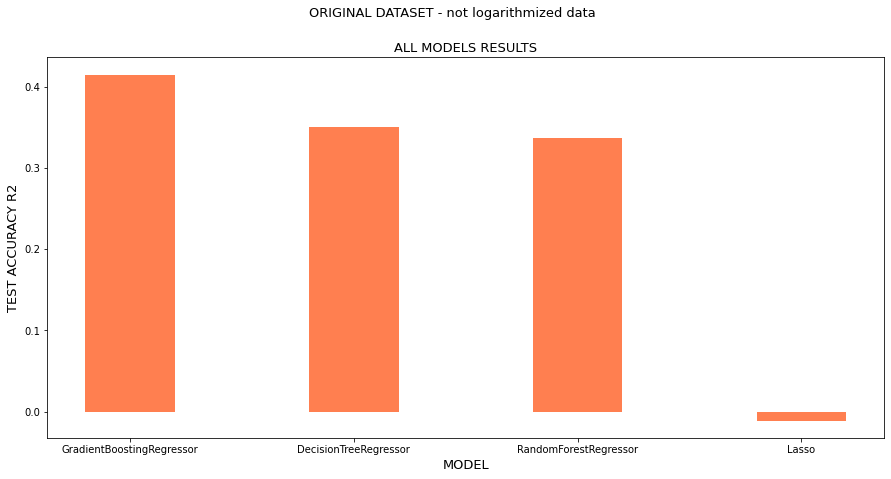

In [79]:
results = pd.read_csv(f"../results/all_models_results_not_log.csv")
plt.figure(figsize=(15, 7))
plt.bar(results['Model'], results['test_accuracy_R2'], width = 0.4, color='coral')
plt.title(f"ALL MODELS RESULTS", fontsize=13)
plt.suptitle(f"ORIGINAL DATASET - not logarithmized data", fontsize=13)
plt.xlabel("MODEL", fontsize=13)
plt.ylabel("TEST ACCURACY R2", fontsize=13)
plt.yticks(range(0.0, 0.7, 0.1))
for i in range(len(results)):
     plt.text(i, results['test_accuracy_R2'][i] + 0.007, "{:.3f}".format(results['test_accuracy_R2'][i]), ha = 'center', fontsize=14)
plt.savefig(f'../results/all_models_results_not_log.jpg')
plt.show()